# 🧠 LLM Learning Notebook: From Scratch to Pro

A comprehensive, hands-on guide to understanding Large Language Models and Transformer architectures using PyTorch.

**What you'll learn:**
- PyTorch fundamentals and neural network basics
- Attention mechanisms and transformer architecture from scratch
- BERT, GPT, and modern LLM architectures
- Advanced topics: MoE, efficient attention, scaling laws
- Fine-tuning techniques: LoRA, QLoRA, adapters
- Inference optimization and deployment
- Vision Transformers and multi-modal models
- VLA and World Foundation Models

---

## 📚 Table of Contents

### Foundations
1. [PyTorch and Neural Network Fundamentals](#module-1-pytorch-fundamentals) ⏱️ ~2 hours
2. [Text Representation and Embeddings](#module-2-text-representation) ⏱️ ~1.5 hours
3. [Core Attention Mechanisms](#module-3-attention-mechanisms) ⏱️ ~2 hours
4. [Transformer Architecture from Scratch](#module-4-transformer-architecture) ⏱️ ~3 hours

### Architecture Variants
5. [BERT: Encoder-Only Architecture](#module-5-bert) ⏱️ ~2 hours
6. [GPT: Decoder-Only Architecture](#module-6-gpt) ⏱️ ~2 hours

### Advanced Architectures
7. [Efficient Attention Variants](#module-7-efficient-attention) ⏱️ ~1.5 hours
8. [Mixture of Experts (MoE)](#module-8-moe) ⏱️ ~2 hours

### Modern Techniques
9. [Modern LLM Techniques](#module-9-modern-techniques) ⏱️ ~2 hours
10. [Training Fundamentals](#module-10-training) ⏱️ ~1.5 hours
11. [Fine-Tuning Techniques](#module-11-fine-tuning) ⏱️ ~2.5 hours

### Deep Dives
12. [Tokenizer Deep Dive (BPE)](#module-12-tokenizers) ⏱️ ~1.5 hours
13. [Scaling Laws](#module-13-scaling-laws) ⏱️ ~1 hour
14. [Inference Optimization](#module-14-inference) ⏱️ ~2 hours
15. [Context Length Extension](#module-15-context-length) ⏱️ ~1.5 hours

### Multi-Modal & Embodied AI
16. [Vision Transformers](#module-16-vit) ⏱️ ~2 hours
17. [VLA and World Models](#module-17-vla) ⏱️ ~1.5 hours

### Practice
18. [Projects and Exercises](#module-18-projects) ⏱️ ~4 hours

**Total estimated time: ~35 hours**

---

## 🛠️ Setup

Run the cell below to install dependencies and configure the environment.

In [1]:
# Install dependencies (uncomment if needed)
# !pip install torch numpy matplotlib seaborn tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, List
import math
from tqdm.auto import tqdm

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Reproducibility
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("\n✅ Setup complete!")

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
Memory: 17.1 GB

✅ Setup complete!


c:\Users\ibrah\anaconda3\envs\interview_prep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

Utility functions used throughout the notebook.

In [2]:
def print_shape(name: str, tensor: torch.Tensor):
    """Print tensor name and shape."""
    print(f"{name}: {tuple(tensor.shape)}")

def count_parameters(model: nn.Module) -> int:
    """Count trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_attention(attention_weights: torch.Tensor, 
                   x_labels: List[str] = None,
                   y_labels: List[str] = None,
                   title: str = "Attention Weights"):
    """Visualize attention weights as a heatmap."""
    weights = attention_weights.detach().cpu().numpy()
    if weights.ndim > 2:
        weights = weights[0]  # Take first head/batch
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(weights, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=x_labels, yticklabels=y_labels)
    plt.title(title)
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.tight_layout()
    plt.show()

print("Helper functions loaded!")

Helper functions loaded!


---

<a id='module-1-pytorch-fundamentals'></a>
# Module 1: PyTorch and Neural Network Fundamentals

**Prerequisites:** Basic Python programming, familiarity with linear algebra concepts (matrices, vectors)

**Learning Objectives:**
By the end of this module, you will be able to:
- Create and manipulate PyTorch tensors with confidence
- Understand how automatic differentiation (autograd) works under the hood
- Build custom neural network layers from scratch using nn.Module
- Implement activation functions, loss functions, and optimizers manually
- Train a simple neural network and understand each step of the process

**Why This Matters for LLMs:**
Every component of a Large Language Model—from attention mechanisms to feed-forward networks—is built on these fundamentals. Understanding tensors, gradients, and the training loop is essential before diving into transformer architectures.

---

## 1.1 Tensor Basics

### What is a Tensor?

A **tensor** is a multi-dimensional array—the fundamental data structure in PyTorch and the building block of all deep learning. If you're familiar with NumPy arrays, tensors are conceptually identical, but with two game-changing advantages:

1. **GPU Acceleration**: Tensors can live on GPUs, enabling massively parallel computation. A single GPU can perform thousands of operations simultaneously, making training feasible for models with billions of parameters.

2. **Automatic Differentiation**: PyTorch tracks every operation performed on tensors and can automatically compute gradients. This is the magic that makes backpropagation work without manual calculus.

### Understanding Tensor Dimensions

Think of tensors as nested containers:

| Rank | Name | Real-World Analogy | Example Shape |
|------|------|-------------------|---------------|
| 0 | Scalar | A single temperature reading | `()` or `torch.tensor(42.0)` |
| 1 | Vector | A list of daily temperatures | `(7,)` for a week |
| 2 | Matrix | A spreadsheet of data | `(rows, cols)` |
| 3 | 3D Tensor | A stack of spreadsheets | `(sheets, rows, cols)` |
| 4 | 4D Tensor | Multiple stacks (batches) | `(batch, sheets, rows, cols)` |

### Shape Conventions in Transformers

Throughout this notebook, we'll consistently use these dimension names:

| Symbol | Meaning | Typical Values |
|--------|---------|----------------|
| `B` | Batch size | 1-64 (limited by GPU memory) |
| `S` or `T` | Sequence length | 512, 2048, 4096, 128K |
| `D` or `d_model` | Model/embedding dimension | 768, 1024, 4096 |
| `H` | Number of attention heads | 8, 12, 32, 64 |
| `V` | Vocabulary size | 32K, 50K, 100K |
| `d_k` | Key/Query dimension per head | `d_model // H` |

**The Most Important Shape:** `(B, S, D)` = `(batch_size, seq_len, d_model)`

This is the shape of data flowing through most of a transformer. Each token in each sequence in the batch is represented by a D-dimensional vector.

In [3]:
# ============================================
# TENSOR CREATION - Multiple Methods
# ============================================
print("=" * 60)
print("TENSOR CREATION METHODS")
print("=" * 60)

# Method 1: From Python lists (explicit values)
# Use when you have specific data
print("\n📌 Method 1: From Python lists")
x = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
print(f"   torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])")
print(f"   Result: {x}")
print(f"   Shape: {x.shape} (1D tensor with 5 elements)")
print(f"   Dtype: {x.dtype} (32-bit float by default for decimals)")

# 2D tensor (matrix)
matrix = torch.tensor([[1, 2, 3],
                       [4, 5, 6]])
print(f"\n   2D tensor (matrix):")
print(f"   {matrix}")
print(f"   Shape: {matrix.shape} (2 rows, 3 columns)")

# Method 2: Initialized tensors (common patterns)
print("\n📌 Method 2: Initialized tensors")
print(f"   torch.zeros(2, 3):    All zeros")
print(f"   {torch.zeros(2, 3)}")
print(f"\n   torch.ones(2, 3):     All ones")
print(f"   {torch.ones(2, 3)}")
print(f"\n   torch.eye(3):         Identity matrix")
print(f"   {torch.eye(3)}")

# Method 3: Random tensors (crucial for initialization)
print("\n📌 Method 3: Random tensors")
torch.manual_seed(42)  # For reproducibility
print(f"   torch.rand(2, 3):     Uniform [0, 1)")
print(f"   {torch.rand(2, 3)}")
print(f"\n   torch.randn(2, 3):    Normal (mean=0, std=1)")
print(f"   {torch.randn(2, 3)}")
print(f"\n   torch.randint(0, 10, (2, 3)):  Random integers [0, 10)")
print(f"   {torch.randint(0, 10, (2, 3))}")

TENSOR CREATION METHODS

📌 Method 1: From Python lists
   torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
   Result: tensor([1., 2., 3., 4., 5.])
   Shape: torch.Size([5]) (1D tensor with 5 elements)
   Dtype: torch.float32 (32-bit float by default for decimals)

   2D tensor (matrix):
   tensor([[1, 2, 3],
        [4, 5, 6]])
   Shape: torch.Size([2, 3]) (2 rows, 3 columns)

📌 Method 2: Initialized tensors
   torch.zeros(2, 3):    All zeros
   tensor([[0., 0., 0.],
        [0., 0., 0.]])

   torch.ones(2, 3):     All ones
   tensor([[1., 1., 1.],
        [1., 1., 1.]])

   torch.eye(3):         Identity matrix
   tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

📌 Method 3: Random tensors
   torch.rand(2, 3):     Uniform [0, 1)
   tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]])

   torch.randn(2, 3):    Normal (mean=0, std=1)
   tensor([[ 1.1561,  0.3965, -2.4661],
        [ 0.3623,  0.3765, -0.1808]])

   torch.randint(0, 10, (2, 3)):  Random integers [

### Why Random Initialization Matters

When we create neural network weights, we initialize them randomly. This is crucial because:

1. **Symmetry Breaking**: If all weights start the same, all neurons learn the same thing
2. **Gradient Flow**: Proper initialization prevents gradients from vanishing or exploding
3. **Convergence Speed**: Good initialization helps the network learn faster

We'll explore specific initialization strategies (Xavier, He) later in this module.

In [4]:
# ============================================
# TENSOR SHAPES IN TRANSFORMERS - Detailed
# ============================================
print("\n" + "=" * 60)
print("TRANSFORMER TENSOR SHAPES - A Complete Picture")
print("=" * 60)

# Let's trace data through a transformer
batch_size = 2      # Processing 2 sentences simultaneously
seq_len = 4         # Each sentence has 4 tokens
d_model = 8         # Each token represented by 8 numbers
vocab_size = 100    # Our vocabulary has 100 unique tokens
n_heads = 2         # Using 2 attention heads
d_k = d_model // n_heads  # Dimension per head

print(f"""
Configuration:
┌─────────────────────────────────────────┐
│  batch_size (B)  = {batch_size:4d}                  │
│  seq_len (S)     = {seq_len:4d}                  │
│  d_model (D)     = {d_model:4d}                  │
│  vocab_size (V)  = {vocab_size:4d}                 │
│  n_heads (H)     = {n_heads:4d}                  │
│  d_k (D/H)       = {d_k:4d}                  │
└─────────────────────────────────────────┘
""")

# Stage 1: Input - Token IDs
print("Stage 1: INPUT TOKEN IDs")
print("-" * 40)
input_ids = torch.randint(0, vocab_size, (batch_size, seq_len))
print(f"Shape: (B, S) = ({batch_size}, {seq_len})")
print(f"These are integer indices into the vocabulary:")
print(f"{input_ids}")
print(f"Each number represents a word/subword in our vocabulary\n")

# Stage 2: After Embedding
print("Stage 2: AFTER EMBEDDING LAYER")
print("-" * 40)
embeddings = torch.randn(batch_size, seq_len, d_model)
print(f"Shape: (B, S, D) = ({batch_size}, {seq_len}, {d_model})")
print(f"Each token ID is now a {d_model}-dimensional vector:")
print(f"Token 0 of Sentence 0: {embeddings[0, 0, :4]}... (showing first 4 dims)\n")

# Stage 3: Inside Attention
print("Stage 3: INSIDE MULTI-HEAD ATTENTION")
print("-" * 40)
# Q, K, V after projection and head splitting
Q = torch.randn(batch_size, n_heads, seq_len, d_k)
K = torch.randn(batch_size, n_heads, seq_len, d_k)
V = torch.randn(batch_size, n_heads, seq_len, d_k)
print(f"Q, K, V shapes: (B, H, S, d_k) = ({batch_size}, {n_heads}, {seq_len}, {d_k})")
print(f"Each head processes {d_k}-dimensional queries, keys, values\n")

# Attention weights
attn_weights = torch.softmax(torch.randn(batch_size, n_heads, seq_len, seq_len), dim=-1)
print(f"Attention weights: (B, H, S, S) = {attn_weights.shape}")
print(f"This is a {seq_len}x{seq_len} matrix showing how each token attends to others")
print(f"Head 0, Sentence 0 attention pattern:")
print(f"{attn_weights[0, 0].round(decimals=2)}\n")

# Stage 4: Output Logits
print("Stage 4: OUTPUT LOGITS")
print("-" * 40)
logits = torch.randn(batch_size, seq_len, vocab_size)
print(f"Shape: (B, S, V) = ({batch_size}, {seq_len}, {vocab_size})")
print(f"For each position, we have {vocab_size} scores (one per vocab token)")
print(f"Apply softmax to get probability distribution over vocabulary")


TRANSFORMER TENSOR SHAPES - A Complete Picture

Configuration:
┌─────────────────────────────────────────┐
│  batch_size (B)  =    2                  │
│  seq_len (S)     =    4                  │
│  d_model (D)     =    8                  │
│  vocab_size (V)  =  100                 │
│  n_heads (H)     =    2                  │
│  d_k (D/H)       =    4                  │
└─────────────────────────────────────────┘

Stage 1: INPUT TOKEN IDs
----------------------------------------
Shape: (B, S) = (2, 4)
These are integer indices into the vocabulary:
tensor([[99, 13, 41, 69],
        [87, 19, 72, 80]])
Each number represents a word/subword in our vocabulary

Stage 2: AFTER EMBEDDING LAYER
----------------------------------------
Shape: (B, S, D) = (2, 4, 8)
Each token ID is now a 8-dimensional vector:
Token 0 of Sentence 0: tensor([-1.3847, -0.8712, -0.2234,  1.7174])... (showing first 4 dims)

Stage 3: INSIDE MULTI-HEAD ATTENTION
----------------------------------------
Q, K, V shape

## 1.2 Tensor Operations

### The Operations That Power Transformers

Understanding tensor operations is crucial because transformers are essentially a carefully orchestrated sequence of:
1. **Matrix multiplications** (attention scores, projections)
2. **Element-wise operations** (activations, residual connections)
3. **Reductions** (softmax normalization, loss computation)

Let's master each category.

In [5]:
# ============================================
# MATRIX MULTIPLICATION - The Heart of Deep Learning
# ============================================
print("=" * 60)
print("MATRIX MULTIPLICATION")
print("=" * 60)

print("""
Matrix multiplication is THE most important operation in deep learning.
Every linear layer, every attention computation uses it.

For matrices A (m×n) and B (n×p), the result C = A @ B has shape (m×p)
Each element C[i,j] = sum of A[i,:] * B[:,j] (dot product of row and column)
""")

# Simple example
A = torch.tensor([[1., 2.],
                  [3., 4.]])
B = torch.tensor([[5., 6.],
                  [7., 8.]])

print("A =")
print(A)
print("\nB =")
print(B)

# Three equivalent ways to multiply
C1 = A @ B                    # Preferred syntax
C2 = torch.matmul(A, B)       # Explicit function
C3 = torch.mm(A, B)           # Only for 2D matrices

print(f"\nA @ B =")
print(C1)
print(f"\nManual calculation of C[0,0]:")
print(f"  A[0,:] · B[:,0] = [1,2] · [5,7] = 1*5 + 2*7 = {1*5 + 2*7}")

# Batched matrix multiplication (crucial for transformers!)
print("\n" + "-" * 40)
print("BATCHED MATRIX MULTIPLICATION")
print("-" * 40)
print("""
In transformers, we process multiple samples (batch) and multiple heads simultaneously.
torch.matmul handles this automatically!
""")

batch, heads, seq, dim = 2, 4, 8, 16
Q = torch.randn(batch, heads, seq, dim)
K = torch.randn(batch, heads, seq, dim)

# Attention scores: Q @ K^T
# We want (B, H, S, D) @ (B, H, D, S) -> (B, H, S, S)
scores = torch.matmul(Q, K.transpose(-2, -1))  # Transpose last two dims
print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"K transposed shape: {K.transpose(-2, -1).shape}")
print(f"Attention scores (Q @ K^T) shape: {scores.shape}")
print(f"\nThis gives us a {seq}x{seq} attention matrix for each head in each batch!")

MATRIX MULTIPLICATION

Matrix multiplication is THE most important operation in deep learning.
Every linear layer, every attention computation uses it.

For matrices A (m×n) and B (n×p), the result C = A @ B has shape (m×p)
Each element C[i,j] = sum of A[i,:] * B[:,j] (dot product of row and column)

A =
tensor([[1., 2.],
        [3., 4.]])

B =
tensor([[5., 6.],
        [7., 8.]])

A @ B =
tensor([[19., 22.],
        [43., 50.]])

Manual calculation of C[0,0]:
  A[0,:] · B[:,0] = [1,2] · [5,7] = 1*5 + 2*7 = 19

----------------------------------------
BATCHED MATRIX MULTIPLICATION
----------------------------------------

In transformers, we process multiple samples (batch) and multiple heads simultaneously.
torch.matmul handles this automatically!

Q shape: torch.Size([2, 4, 8, 16])
K shape: torch.Size([2, 4, 8, 16])
K transposed shape: torch.Size([2, 4, 16, 8])
Attention scores (Q @ K^T) shape: torch.Size([2, 4, 8, 8])

This gives us a 8x8 attention matrix for each head in each batc

In [6]:
# ============================================
# ELEMENT-WISE OPERATIONS
# ============================================
print("\n" + "=" * 60)
print("ELEMENT-WISE OPERATIONS")
print("=" * 60)

print("""
Element-wise operations apply the same operation to each element independently.
Used for: activations, residual connections, scaling, masking
""")

a = torch.tensor([1., 2., 3., 4.])
b = torch.tensor([10., 20., 30., 40.])

print(f"a = {a.tolist()}")
print(f"b = {b.tolist()}")
print(f"\na + b = {(a + b).tolist()}  (element-wise addition)")
print(f"a * b = {(a * b).tolist()}  (element-wise multiplication, NOT dot product)")
print(f"a / b = {(a / b).tolist()}  (element-wise division)")
print(f"a ** 2 = {(a ** 2).tolist()}  (element-wise power)")

# Residual connection example
print("\n" + "-" * 40)
print("RESIDUAL CONNECTION EXAMPLE")
print("-" * 40)
x = torch.randn(2, 4)  # Input
sublayer_output = torch.randn(2, 4)  # Output of attention or FFN

# Residual: add input to output
residual_output = x + sublayer_output
print(f"Input shape: {x.shape}")
print(f"Sublayer output shape: {sublayer_output.shape}")
print(f"Residual (x + sublayer) shape: {residual_output.shape}")
print("\nResidual connections help gradients flow and enable training deep networks!")


ELEMENT-WISE OPERATIONS

Element-wise operations apply the same operation to each element independently.
Used for: activations, residual connections, scaling, masking

a = [1.0, 2.0, 3.0, 4.0]
b = [10.0, 20.0, 30.0, 40.0]

a + b = [11.0, 22.0, 33.0, 44.0]  (element-wise addition)
a * b = [10.0, 40.0, 90.0, 160.0]  (element-wise multiplication, NOT dot product)
a / b = [0.10000000149011612, 0.10000000149011612, 0.10000000149011612, 0.10000000149011612]  (element-wise division)
a ** 2 = [1.0, 4.0, 9.0, 16.0]  (element-wise power)

----------------------------------------
RESIDUAL CONNECTION EXAMPLE
----------------------------------------
Input shape: torch.Size([2, 4])
Sublayer output shape: torch.Size([2, 4])
Residual (x + sublayer) shape: torch.Size([2, 4])

Residual connections help gradients flow and enable training deep networks!


In [12]:
# ============================================
# BROADCASTING - Automatic Shape Expansion
# ============================================
print("\n" + "=" * 60)
print("BROADCASTING")
print("=" * 60)

print("""
Broadcasting automatically expands smaller tensors to match larger ones.
Rules:
1. Dimensions are compared from right to left
2. Dimensions match if they're equal OR one of them is 1
3. Missing dimensions are treated as 1

This is ESSENTIAL for efficient transformer operations!
""")

# Example 1: Scalar + Matrix
matrix = torch.ones(2, 3)
scalar = 5
result = matrix + scalar
print("Example 1: Scalar + Matrix")
print(f"Matrix (2,3) + Scalar () = Result (2,3)")
print(f"{matrix} + {scalar} =\n{result}\n")

# Example 2: Vector + Matrix (add to each row)
matrix = torch.ones(2, 3)
row_vector = torch.tensor([1., 2., 3.])
result = matrix + row_vector
print("Example 2: Matrix + Row Vector")
print(f"Matrix (2,3) + Vector (3,) = Result (2,3)")
print(f"Vector is broadcast across rows:\n{result}\n")

# Example 3: Attention mask broadcasting (CRITICAL for transformers)
print("Example 3: Attention Mask Broadcasting")
print("-" * 40)
batch, heads, seq = 2, 4, 8

# Attention scores: (B, H, S, S)
scores = torch.randn(batch, heads, seq, seq)

# Causal mask: (1, 1, S, S) - same mask for all batches and heads
# Upper triangular = future positions = -inf
mask = torch.triu(torch.ones(1, 1, seq, seq) * float('-inf'), diagonal=1)

print(f"Scores shape: {scores.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask (showing 4x4 corner):")
print(mask[0, 0, :4, :4])

# Broadcasting: (B, H, S, S) + (1, 1, S, S) -> (B, H, S, S)
masked_scores = scores + mask
print(f"\nMasked scores shape: {masked_scores.shape}")
print("The mask broadcasts across all batches and heads automatically!")


BROADCASTING

Broadcasting automatically expands smaller tensors to match larger ones.
Rules:
1. Dimensions are compared from right to left
2. Dimensions match if they're equal OR one of them is 1
3. Missing dimensions are treated as 1

This is ESSENTIAL for efficient transformer operations!

Example 1: Scalar + Matrix
Matrix (2,3) + Scalar () = Result (2,3)
tensor([[1., 1., 1.],
        [1., 1., 1.]]) + 5 =
tensor([[6., 6., 6.],
        [6., 6., 6.]])

Example 2: Matrix + Row Vector
Matrix (2,3) + Vector (3,) = Result (2,3)
Vector is broadcast across rows:
tensor([[2., 3., 4.],
        [2., 3., 4.]])

Example 3: Attention Mask Broadcasting
----------------------------------------
Scores shape: torch.Size([2, 4, 8, 8])
Mask shape: torch.Size([1, 1, 8, 8])
Mask (showing 4x4 corner):
tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

Masked scores shape: torch.Size([2, 4, 8, 8])
The mask broadcasts across all batches and

## 1.3 Automatic Differentiation (Autograd)

### The Magic Behind Training Neural Networks

Training a neural network requires computing **gradients**—derivatives that tell us how to adjust each parameter to reduce the loss. For a network with millions of parameters, computing these manually would be impossible.

PyTorch's **autograd** system solves this by:
1. Building a **computational graph** as you perform operations
2. Automatically computing gradients via the **chain rule** when you call `.backward()`

### How It Works

```
Forward Pass:  x → [operation] → y → [operation] → loss
                    ↓                    ↓
Backward Pass: ∂loss/∂x ← [gradient] ← ∂loss/∂y ← [gradient] ← 1
```

The chain rule states: if `y = f(x)` and `loss = g(y)`, then:
$$\frac{\partial loss}{\partial x} = \frac{\partial loss}{\partial y} \cdot \frac{\partial y}{\partial x}$$

PyTorch applies this automatically through the entire computation graph.

In [13]:
# ============================================
# AUTOGRAD BASICS
# ============================================
print("=" * 60)
print("AUTOGRAD - Automatic Differentiation")
print("=" * 60)

# Create a tensor that tracks gradients
x = torch.tensor([2.0, 3.0], requires_grad=True)
print(f"x = {x}")
print(f"requires_grad = {x.requires_grad}")

# Perform operations (PyTorch builds computational graph)
y = x ** 2          # y = [4, 9]
z = y * 3           # z = [12, 27]
loss = z.sum()      # loss = 39 (need scalar for backward)

print(f"\nForward pass:")
print(f"  y = x² = {y.tolist()}")
print(f"  z = 3y = {z.tolist()}")
print(f"  loss = sum(z) = {loss.item()}")

# Compute gradients
loss.backward()

print(f"\nBackward pass (chain rule):")
print(f"  ∂loss/∂z = [1, 1] (derivative of sum)")
print(f"  ∂z/∂y = [3, 3] (derivative of 3y)")
print(f"  ∂y/∂x = [2x₁, 2x₂] = [4, 6] (derivative of x²)")
print(f"  ∂loss/∂x = ∂loss/∂z · ∂z/∂y · ∂y/∂x = 1 · 3 · 2x = 6x")
print(f"\nComputed gradient: x.grad = {x.grad.tolist()}")
print(f"Expected: 6 * [2, 3] = [12, 18] ✓")

AUTOGRAD - Automatic Differentiation
x = tensor([2., 3.], requires_grad=True)
requires_grad = True

Forward pass:
  y = x² = [4.0, 9.0]
  z = 3y = [12.0, 27.0]
  loss = sum(z) = 39.0

Backward pass (chain rule):
  ∂loss/∂z = [1, 1] (derivative of sum)
  ∂z/∂y = [3, 3] (derivative of 3y)
  ∂y/∂x = [2x₁, 2x₂] = [4, 6] (derivative of x²)
  ∂loss/∂x = ∂loss/∂z · ∂z/∂y · ∂y/∂x = 1 · 3 · 2x = 6x

Computed gradient: x.grad = [12.0, 18.0]
Expected: 6 * [2, 3] = [12, 18] ✓


In [14]:
# ============================================
# COMPUTATIONAL GRAPH VISUALIZATION
# ============================================
print("\n" + "=" * 60)
print("COMPUTATIONAL GRAPH")
print("=" * 60)

print("""
For the computation: loss = sum(3 * x²)

Forward Pass (building the graph):
                                    
    x ──────┬──► x² ──► *3 ──► sum ──► loss
            │    ↑       ↑       ↑
            │   y=x²    z=3y   scalar
            │
    Each node remembers how to compute its gradient!

Backward Pass (traversing the graph):

    ∂loss/∂x ◄── ∂y/∂x ◄── ∂z/∂y ◄── ∂loss/∂z ◄── 1
       6x    ·    2x    ·    3    ·     1
""")

# More complex example: neural network layer
print("\nNeural Network Layer Example:")
print("-" * 40)

# Simulating: output = relu(x @ W + b)
x = torch.randn(2, 3, requires_grad=True)   # Input
W = torch.randn(3, 4, requires_grad=True)   # Weights
b = torch.randn(4, requires_grad=True)      # Bias

# Forward pass
linear = x @ W + b                           # Linear transformation
output = torch.relu(linear)                  # Activation
loss = output.sum()                          # Dummy loss

print(f"x shape: {x.shape}")
print(f"W shape: {W.shape}")
print(f"b shape: {b.shape}")
print(f"output shape: {output.shape}")

# Backward pass
loss.backward()

print(f"\nGradients computed:")
print(f"  x.grad shape: {x.grad.shape} (same as x)")
print(f"  W.grad shape: {W.grad.shape} (same as W)")
print(f"  b.grad shape: {b.grad.shape} (same as b)")
print("\nThese gradients tell us how to update W and b to reduce loss!")


COMPUTATIONAL GRAPH

For the computation: loss = sum(3 * x²)

Forward Pass (building the graph):

    x ──────┬──► x² ──► *3 ──► sum ──► loss
            │    ↑       ↑       ↑
            │   y=x²    z=3y   scalar
            │
    Each node remembers how to compute its gradient!

Backward Pass (traversing the graph):

    ∂loss/∂x ◄── ∂y/∂x ◄── ∂z/∂y ◄── ∂loss/∂z ◄── 1
       6x    ·    2x    ·    3    ·     1


Neural Network Layer Example:
----------------------------------------
x shape: torch.Size([2, 3])
W shape: torch.Size([3, 4])
b shape: torch.Size([4])
output shape: torch.Size([2, 4])

Gradients computed:
  x.grad shape: torch.Size([2, 3]) (same as x)
  W.grad shape: torch.Size([3, 4]) (same as W)
  b.grad shape: torch.Size([4]) (same as b)

These gradients tell us how to update W and b to reduce loss!


In [15]:
# ============================================
# GRADIENT ACCUMULATION (Important!)
# ============================================
print("\n" + "=" * 60)
print("GRADIENT ACCUMULATION")
print("=" * 60)

print("""
⚠️ IMPORTANT: Gradients ACCUMULATE by default!
Each call to .backward() ADDS to existing gradients.
You must call optimizer.zero_grad() or tensor.grad.zero_() before each backward pass.
""")

x = torch.tensor([1.0, 2.0], requires_grad=True)

# First backward
y1 = (x ** 2).sum()
y1.backward()
print(f"After first backward: x.grad = {x.grad.tolist()}")

# Second backward WITHOUT zeroing
y2 = (x ** 2).sum()
y2.backward()
print(f"After second backward (accumulated!): x.grad = {x.grad.tolist()}")

# Correct approach: zero gradients first
x.grad.zero_()
y3 = (x ** 2).sum()
y3.backward()
print(f"After zeroing and third backward: x.grad = {x.grad.tolist()}")

print("""
This is why every training loop has:
    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Compute new gradients
    optimizer.step()       # Update parameters
""")


GRADIENT ACCUMULATION

⚠️ IMPORTANT: Gradients ACCUMULATE by default!
Each call to .backward() ADDS to existing gradients.
You must call optimizer.zero_grad() or tensor.grad.zero_() before each backward pass.

After first backward: x.grad = [2.0, 4.0]
After second backward (accumulated!): x.grad = [4.0, 8.0]
After zeroing and third backward: x.grad = [2.0, 4.0]

This is why every training loop has:
    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Compute new gradients
    optimizer.step()       # Update parameters



## 1.4 Building Custom Layers with nn.Module

### The nn.Module Pattern

Every neural network component in PyTorch inherits from `nn.Module`. This base class provides:

1. **Parameter Management**: Automatically tracks learnable parameters
2. **Device Movement**: `.to(device)` moves all parameters to GPU/CPU
3. **Training Mode**: `.train()` and `.eval()` for dropout/batchnorm behavior
4. **Serialization**: `.state_dict()` for saving/loading models

### The Standard Pattern

```python
class MyLayer(nn.Module):
    def __init__(self, ...):
        super().__init__()  # Always call parent __init__
        # Define parameters and sub-modules here
        self.weight = nn.Parameter(torch.randn(...))
        self.sublayer = nn.Linear(...)
        
    def forward(self, x):
        # Define computation here
        return self.weight * x + self.sublayer(x)
```

### nn.Parameter vs Regular Tensor

- `nn.Parameter`: Automatically registered, included in `.parameters()`, saved in state_dict
- Regular tensor: Not tracked, not saved, not updated by optimizer

In [16]:
# ============================================
# IMPLEMENTING LINEAR LAYER FROM SCRATCH
# ============================================
print("=" * 60)
print("LINEAR LAYER FROM SCRATCH")
print("=" * 60)

class LinearFromScratch(nn.Module):
    """
    Linear transformation: y = xW^T + b
    
    This is the fundamental building block of neural networks.
    Every projection in a transformer (Q, K, V, output) uses this.
    
    Args:
        in_features: Size of each input sample
        out_features: Size of each output sample
        bias: If True, adds a learnable bias
    
    Shape:
        - Input: (*, in_features) where * means any number of dimensions
        - Output: (*, out_features)
    
    Example:
        For d_model=512, projecting to d_k=64:
        >>> proj = LinearFromScratch(512, 64)
        >>> x = torch.randn(batch, seq_len, 512)
        >>> out = proj(x)  # Shape: (batch, seq_len, 64)
    """
    
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using Xavier/Glorot initialization
        # This helps maintain variance of activations across layers
        std = math.sqrt(2.0 / (in_features + out_features))
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * std)
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            # Register as None so it's tracked but not a parameter
            self.register_parameter('bias', None)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass: y = xW^T + b
        
        Why W^T? Convention is weight shape (out, in), but we want
        x @ W^T where x is (..., in) to get (..., out)
        """
        # Matrix multiplication: (..., in) @ (in, out) -> (..., out)
        output = torch.matmul(x, self.weight.T)
        
        if self.bias is not None:
            output = output + self.bias  # Broadcasting handles this
        
        return output
    
    def extra_repr(self) -> str:
        """String representation for print(model)"""
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'

# Test our implementation
print("\nTesting LinearFromScratch:")
print("-" * 40)

in_features, out_features = 4, 3
batch_size, seq_len = 2, 5

layer = LinearFromScratch(in_features, out_features)
x = torch.randn(batch_size, seq_len, in_features)

print(f"Input shape: {x.shape}")
print(f"Weight shape: {layer.weight.shape}")
print(f"Bias shape: {layer.bias.shape}")
output = layer(x)
print(f"Output shape: {output.shape}")

print(f"\nModel structure:")
print(layer)

print(f"\nParameters:")
for name, param in layer.named_parameters():
    print(f"  {name}: {param.shape}, requires_grad={param.requires_grad}")

print(f"\nTotal parameters: {sum(p.numel() for p in layer.parameters())}")

LINEAR LAYER FROM SCRATCH

Testing LinearFromScratch:
----------------------------------------
Input shape: torch.Size([2, 5, 4])
Weight shape: torch.Size([3, 4])
Bias shape: torch.Size([3])
Output shape: torch.Size([2, 5, 3])

Model structure:
LinearFromScratch(in_features=4, out_features=3, bias=True)

Parameters:
  weight: torch.Size([3, 4]), requires_grad=True
  bias: torch.Size([3]), requires_grad=True

Total parameters: 15


In [17]:
# ============================================
# VERIFY AGAINST PYTORCH'S nn.Linear
# ============================================
print("\n" + "=" * 60)
print("VERIFICATION: Our Implementation vs PyTorch")
print("=" * 60)

# Create both layers
our_layer = LinearFromScratch(4, 3)
pytorch_layer = nn.Linear(4, 3)

# Copy weights from PyTorch to our layer
with torch.no_grad():
    our_layer.weight.copy_(pytorch_layer.weight)
    our_layer.bias.copy_(pytorch_layer.bias)

# Test with same input
x = torch.randn(2, 5, 4)
our_output = our_layer(x)
pytorch_output = pytorch_layer(x)

print(f"Input shape: {x.shape}")
print(f"Our output shape: {our_output.shape}")
print(f"PyTorch output shape: {pytorch_output.shape}")

# Check if outputs match
match = torch.allclose(our_output, pytorch_output, atol=1e-6)
print(f"\nOutputs match: {match} ✓" if match else f"\nOutputs DON'T match ✗")

if match:
    print("\n🎉 Our from-scratch implementation is correct!")


VERIFICATION: Our Implementation vs PyTorch
Input shape: torch.Size([2, 5, 4])
Our output shape: torch.Size([2, 5, 3])
PyTorch output shape: torch.Size([2, 5, 3])

Outputs match: True ✓

🎉 Our from-scratch implementation is correct!


## 1.5 Activation Functions

### Why Do We Need Activation Functions?

Without activation functions, a neural network is just a series of linear transformations:
```
y = W₃(W₂(W₁x + b₁) + b₂) + b₃ = W_combined · x + b_combined
```

No matter how many layers, it collapses to a single linear transformation! **Activation functions introduce non-linearity**, allowing networks to learn complex patterns.

### The Activation Functions You'll See in Transformers

| Function | Formula | Used In | Why |
|----------|---------|---------|-----|
| ReLU | max(0, x) | Classic FFN | Simple, fast, sparse |
| GELU | x · Φ(x) | BERT, GPT-2+ | Smooth, probabilistic |
| SiLU/Swish | x · σ(x) | LLaMA, modern LLMs | Smooth, self-gated |
| SwiGLU | Swish(xW) ⊙ (xV) | LLaMA 2, Mistral | Best performance |
| Softmax | exp(xᵢ)/Σexp(xⱼ) | Attention | Probability distribution |

ACTIVATION FUNCTIONS


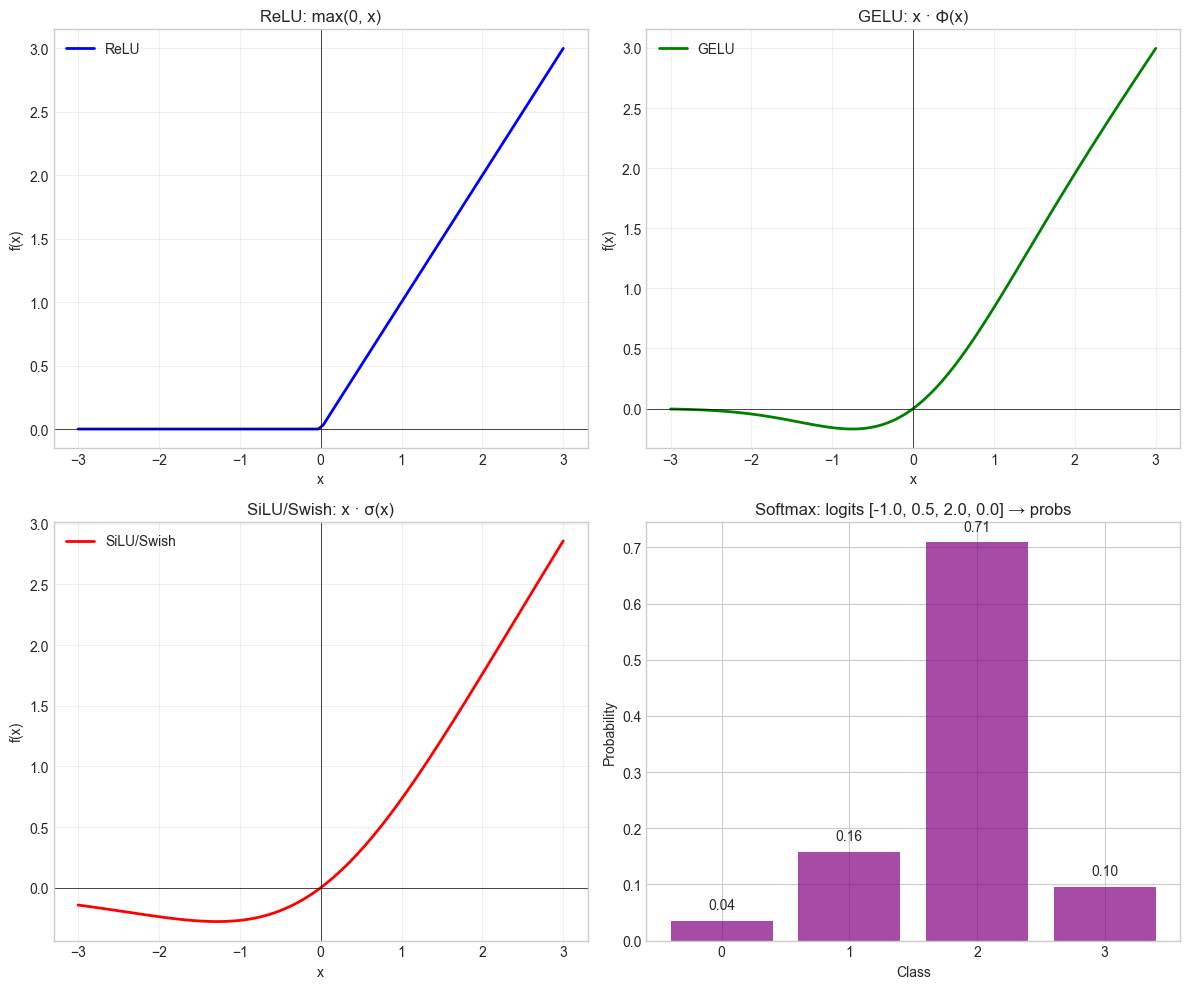


✅ Activation functions visualized!

Key insight: GELU and SiLU are smooth approximations of ReLU
that allow small negative gradients, helping with training stability.


In [18]:
# ============================================
# ACTIVATION FUNCTIONS FROM SCRATCH
# ============================================
print("=" * 60)
print("ACTIVATION FUNCTIONS")
print("=" * 60)

class ActivationFunctions:
    """Collection of activation functions implemented from scratch."""
    
    @staticmethod
    def relu(x: torch.Tensor) -> torch.Tensor:
        """
        ReLU: Rectified Linear Unit
        f(x) = max(0, x)
        
        Pros: Simple, fast, creates sparsity
        Cons: "Dying ReLU" - neurons can get stuck at 0
        """
        return torch.maximum(x, torch.tensor(0.0))
    
    @staticmethod
    def gelu(x: torch.Tensor) -> torch.Tensor:
        """
        GELU: Gaussian Error Linear Unit
        f(x) = x * Φ(x) where Φ is the CDF of standard normal
        
        Approximation: 0.5 * x * (1 + tanh(sqrt(2/π) * (x + 0.044715 * x³)))
        
        Used in: BERT, GPT-2, GPT-3
        Why: Smooth, allows small negative values, probabilistic interpretation
        """
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * x ** 3)))
    
    @staticmethod
    def silu(x: torch.Tensor) -> torch.Tensor:
        """
        SiLU/Swish: Sigmoid Linear Unit
        f(x) = x * sigmoid(x)
        
        Used in: LLaMA, modern LLMs
        Why: Self-gated, smooth, works well in practice
        """
        return x * torch.sigmoid(x)
    
    @staticmethod
    def softmax(x: torch.Tensor, dim: int = -1) -> torch.Tensor:
        """
        Softmax: Converts logits to probability distribution
        f(xᵢ) = exp(xᵢ) / Σⱼ exp(xⱼ)
        
        Used in: Attention weights, output layer
        
        Numerical stability: Subtract max before exp to prevent overflow
        """
        x_max = x.max(dim=dim, keepdim=True).values
        exp_x = torch.exp(x - x_max)  # Subtract max for stability
        return exp_x / exp_x.sum(dim=dim, keepdim=True)

# Visualize activation functions
x = torch.linspace(-3, 3, 100)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ReLU
ax = axes[0, 0]
y_relu = ActivationFunctions.relu(x)
ax.plot(x.numpy(), y_relu.numpy(), 'b-', linewidth=2, label='ReLU')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax.set_title('ReLU: max(0, x)', fontsize=12)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid(True, alpha=0.3)

# GELU
ax = axes[0, 1]
y_gelu = ActivationFunctions.gelu(x)
ax.plot(x.numpy(), y_gelu.numpy(), 'g-', linewidth=2, label='GELU')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax.set_title('GELU: x · Φ(x)', fontsize=12)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid(True, alpha=0.3)

# SiLU/Swish
ax = axes[1, 0]
y_silu = ActivationFunctions.silu(x)
ax.plot(x.numpy(), y_silu.numpy(), 'r-', linewidth=2, label='SiLU/Swish')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax.set_title('SiLU/Swish: x · σ(x)', fontsize=12)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.legend()
ax.grid(True, alpha=0.3)

# Softmax
ax = axes[1, 1]
logits = torch.tensor([-1.0, 0.5, 2.0, 0.0])
probs = ActivationFunctions.softmax(logits)
ax.bar(range(len(logits)), probs.numpy(), color='purple', alpha=0.7)
ax.set_title(f'Softmax: logits {logits.tolist()} → probs', fontsize=12)
ax.set_xlabel('Class')
ax.set_ylabel('Probability')
ax.set_xticks(range(len(logits)))
for i, (l, p) in enumerate(zip(logits, probs)):
    ax.annotate(f'{p:.2f}', (i, p + 0.02), ha='center')

plt.tight_layout()
plt.show()

print("\n✅ Activation functions visualized!")
print("\nKey insight: GELU and SiLU are smooth approximations of ReLU")
print("that allow small negative gradients, helping with training stability.")

## 1.6 Loss Functions

### What is a Loss Function?

A **loss function** (or cost function) measures how wrong our model's predictions are. Training minimizes this loss by adjusting parameters via gradient descent.

### Loss Functions in Language Models

| Loss | Formula | Used For |
|------|---------|----------|
| Cross-Entropy | -Σ yᵢ log(ŷᵢ) | Classification, next-token prediction |
| MSE | (1/n) Σ(y - ŷ)² | Regression, embeddings |
| Binary CE | -[y log(ŷ) + (1-y) log(1-ŷ)] | Binary classification |

### Cross-Entropy: The Language Model Loss

For language models, we predict the next token from a vocabulary of V tokens. Cross-entropy loss measures how well our predicted probability distribution matches the true distribution (which is 1 for the correct token, 0 for others).

**Intuition**: If the model assigns probability 0.9 to the correct token, loss is low (-log(0.9) ≈ 0.1). If it assigns 0.01, loss is high (-log(0.01) ≈ 4.6).

LOSS FUNCTIONS

📌 Cross-Entropy Loss Example (Language Modeling)
--------------------------------------------------
Logits shape: torch.Size([2, 3, 5]) (batch, seq, vocab)
Targets shape: torch.Size([2, 3])
Targets: tensor([[0, 0, 1],
        [1, 4, 0]])

Our cross-entropy loss: 1.4190
PyTorch cross-entropy:  1.4190
Match: True ✓

📌 Loss vs Confidence Visualization
--------------------------------------------------


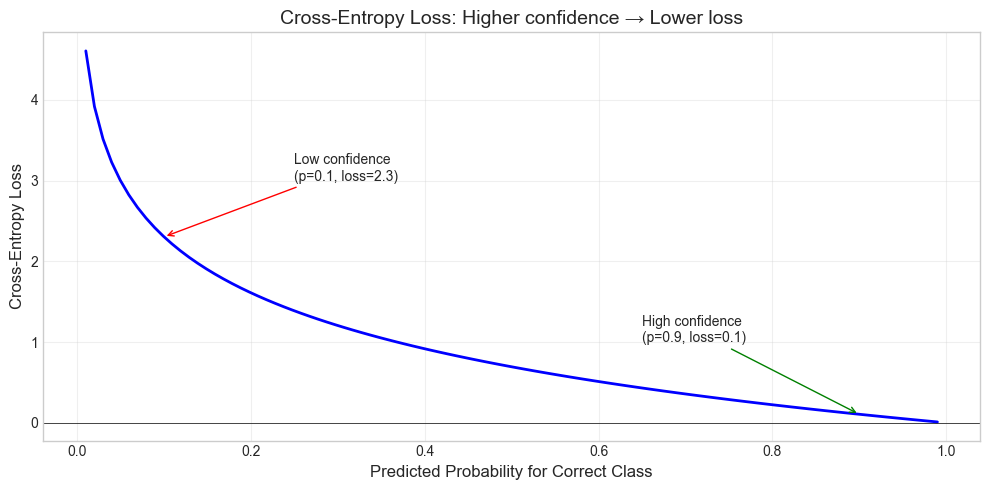

In [19]:
# ============================================
# LOSS FUNCTIONS FROM SCRATCH
# ============================================
print("=" * 60)
print("LOSS FUNCTIONS")
print("=" * 60)

class LossFunctions:
    """Loss functions implemented from scratch."""
    
    @staticmethod
    def mse_loss(predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Mean Squared Error Loss
        L = (1/n) Σ(y - ŷ)²
        
        Used for: Regression tasks, embedding similarity
        """
        return ((predictions - targets) ** 2).mean()
    
    @staticmethod
    def cross_entropy_loss(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Cross-Entropy Loss for classification
        L = -Σ yᵢ log(softmax(logits)ᵢ)
        
        For one-hot targets, this simplifies to: L = -log(softmax(logits)[target])
        
        Args:
            logits: Raw scores, shape (batch, num_classes) or (batch, seq, vocab)
            targets: Class indices, shape (batch,) or (batch, seq)
        
        Used for: Classification, language modeling (next token prediction)
        """
        # Numerical stability: log_softmax is more stable than log(softmax)
        # log_softmax(x) = x - log(Σexp(x))
        log_probs = logits - torch.logsumexp(logits, dim=-1, keepdim=True)
        
        # Gather the log probability of the correct class
        # targets shape: (...) -> (..., 1) for gather
        targets_expanded = targets.unsqueeze(-1)
        correct_log_probs = log_probs.gather(dim=-1, index=targets_expanded)
        
        # Return negative mean log probability
        return -correct_log_probs.mean()

# Example: Cross-entropy for language modeling
print("\n📌 Cross-Entropy Loss Example (Language Modeling)")
print("-" * 50)

batch_size = 2
seq_len = 3
vocab_size = 5

# Model outputs logits for each position
logits = torch.randn(batch_size, seq_len, vocab_size)
print(f"Logits shape: {logits.shape} (batch, seq, vocab)")

# True next tokens
targets = torch.randint(0, vocab_size, (batch_size, seq_len))
print(f"Targets shape: {targets.shape}")
print(f"Targets: {targets}")

# Compute loss
our_loss = LossFunctions.cross_entropy_loss(logits.view(-1, vocab_size), targets.view(-1))
pytorch_loss = F.cross_entropy(logits.view(-1, vocab_size), targets.view(-1))

print(f"\nOur cross-entropy loss: {our_loss.item():.4f}")
print(f"PyTorch cross-entropy:  {pytorch_loss.item():.4f}")
print(f"Match: {torch.allclose(our_loss, pytorch_loss, atol=1e-5)} ✓")

# Visualize: How loss changes with confidence
print("\n📌 Loss vs Confidence Visualization")
print("-" * 50)

confidences = torch.linspace(0.01, 0.99, 100)
losses = -torch.log(confidences)

plt.figure(figsize=(10, 5))
plt.plot(confidences.numpy(), losses.numpy(), 'b-', linewidth=2)
plt.xlabel('Predicted Probability for Correct Class', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.title('Cross-Entropy Loss: Higher confidence → Lower loss', fontsize=14)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)

# Annotate key points
plt.annotate('Low confidence\n(p=0.1, loss=2.3)', xy=(0.1, -np.log(0.1)), 
             xytext=(0.25, 3), fontsize=10, arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate('High confidence\n(p=0.9, loss=0.1)', xy=(0.9, -np.log(0.9)), 
             xytext=(0.65, 1), fontsize=10, arrowprops=dict(arrowstyle='->', color='green'))

plt.tight_layout()
plt.show()

## 1.7 Optimizers: How Models Learn

### The Optimization Loop

Training a neural network is an optimization problem: find parameters θ that minimize the loss L(θ).

```
repeat:
    1. Forward pass: compute predictions and loss
    2. Backward pass: compute gradients ∂L/∂θ
    3. Update: θ = θ - learning_rate × ∂L/∂θ
```

### Optimizer Evolution

| Optimizer | Update Rule | Key Idea |
|-----------|-------------|----------|
| SGD | θ -= lr × g | Simple gradient descent |
| Momentum | v = βv + g; θ -= lr × v | Accumulate velocity |
| Adam | Combines momentum + adaptive lr | Best of both worlds |
| AdamW | Adam + decoupled weight decay | Standard for transformers |

### Adam: The Transformer's Optimizer

Adam (Adaptive Moment Estimation) maintains:
- **m**: First moment (mean of gradients) - like momentum
- **v**: Second moment (variance of gradients) - for adaptive learning rate

This allows different learning rates for different parameters, which is crucial for training transformers where some parameters need larger updates than others.

OPTIMIZERS FROM SCRATCH

📌 Optimizer Comparison: Minimize f(x) = x²
--------------------------------------------------


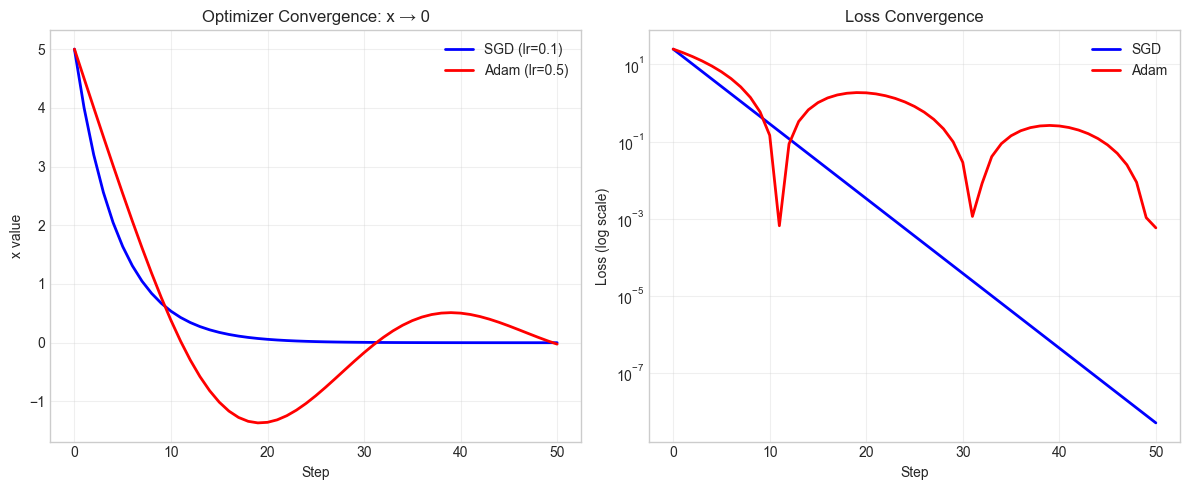


✅ Both optimizers find the minimum (x=0), but Adam adapts faster!


In [20]:
# ============================================
# OPTIMIZERS FROM SCRATCH
# ============================================
print("=" * 60)
print("OPTIMIZERS FROM SCRATCH")
print("=" * 60)

class SGD:
    """
    Stochastic Gradient Descent
    
    Update rule: θ = θ - lr × ∂L/∂θ
    
    Simple but effective. The foundation of all optimizers.
    """
    def __init__(self, parameters, lr: float = 0.01):
        self.parameters = list(parameters)
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for param in self.parameters:
                if param.grad is not None:
                    param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()


class Adam:
    """
    Adam Optimizer (Adaptive Moment Estimation)
    
    Maintains running averages of:
    - m: First moment (mean of gradients)
    - v: Second moment (uncentered variance of gradients)
    
    Update rule:
        m = β₁m + (1-β₁)g
        v = β₂v + (1-β₂)g²
        m̂ = m / (1-β₁ᵗ)  # Bias correction
        v̂ = v / (1-β₂ᵗ)
        θ = θ - lr × m̂ / (√v̂ + ε)
    
    Default hyperparameters (from the paper):
        lr = 0.001, β₁ = 0.9, β₂ = 0.999, ε = 1e-8
    """
    def __init__(self, parameters, lr: float = 0.001, 
                 betas: Tuple[float, float] = (0.9, 0.999), eps: float = 1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.t = 0  # Time step
        
        # Initialize moment estimates
        self.m = [torch.zeros_like(p) for p in self.parameters]
        self.v = [torch.zeros_like(p) for p in self.parameters]
    
    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, param in enumerate(self.parameters):
                if param.grad is None:
                    continue
                
                g = param.grad
                
                # Update biased first moment estimate
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
                
                # Update biased second moment estimate
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g ** 2)
                
                # Bias correction
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                
                # Update parameters
                param -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)
    
    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()


# Compare optimizers on a simple problem
print("\n📌 Optimizer Comparison: Minimize f(x) = x²")
print("-" * 50)

def run_optimization(optimizer_class, optimizer_kwargs, n_steps=50):
    x = torch.tensor([5.0], requires_grad=True)
    optimizer = optimizer_class([x], **optimizer_kwargs)
    history = [x.item()]
    
    for _ in range(n_steps):
        loss = x ** 2  # f(x) = x²
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        history.append(x.item())
    
    return history

# Run both optimizers
sgd_history = run_optimization(SGD, {'lr': 0.1})
adam_history = run_optimization(Adam, {'lr': 0.5})

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sgd_history, 'b-', label='SGD (lr=0.1)', linewidth=2)
plt.plot(adam_history, 'r-', label='Adam (lr=0.5)', linewidth=2)
plt.xlabel('Step')
plt.ylabel('x value')
plt.title('Optimizer Convergence: x → 0')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sgd_loss = [x**2 for x in sgd_history]
adam_loss = [x**2 for x in adam_history]
plt.semilogy(sgd_loss, 'b-', label='SGD', linewidth=2)
plt.semilogy(adam_loss, 'r-', label='Adam', linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss (log scale)')
plt.title('Loss Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Both optimizers find the minimum (x=0), but Adam adapts faster!")

## 1.8 Putting It All Together: Training an MLP

Now let's combine everything we've learned to train a simple Multi-Layer Perceptron (MLP) from scratch. This is the same pattern used to train transformers—just with different architectures.

### The Training Loop

```python
for epoch in range(num_epochs):
    for batch in dataloader:
        # 1. Forward pass
        predictions = model(batch.inputs)
        loss = loss_fn(predictions, batch.targets)
        
        # 2. Backward pass
        optimizer.zero_grad()  # Clear old gradients
        loss.backward()        # Compute new gradients
        
        # 3. Update parameters
        optimizer.step()
```

This exact pattern scales from our simple MLP to GPT-4.

TRAINING AN MLP FROM SCRATCH

📌 Creating Dataset: XOR Problem
--------------------------------------------------
XOR Truth Table:
  Input  | Output
  -------|-------
  [0.0, 0.0] |   0
  [0.0, 1.0] |   1
  [1.0, 0.0] |   1
  [1.0, 1.0] |   0

Model Architecture:
MLP(
  (fc1): Linear(in_features=2, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=2, bias=True)
)

Total parameters: 42

📌 Training
--------------------------------------------------
Epoch    1 | Loss: 0.7270 | Accuracy: 50.00%
Epoch  200 | Loss: 0.0001 | Accuracy: 100.00%
Epoch  400 | Loss: 0.0000 | Accuracy: 100.00%
Epoch  600 | Loss: 0.0000 | Accuracy: 100.00%
Epoch  800 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 1000 | Loss: 0.0000 | Accuracy: 100.00%

✅ Training complete!


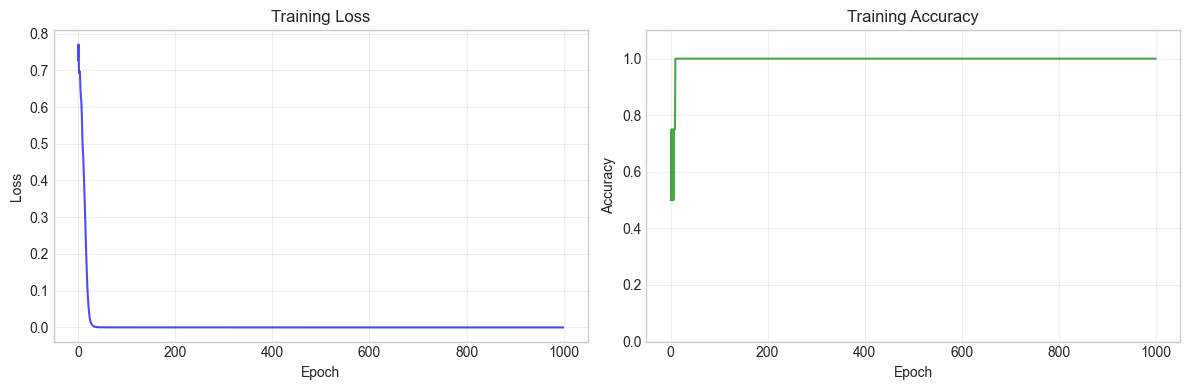


📌 Testing Trained Model
--------------------------------------------------
  Input  | True | Pred | Confidence
  -------|------|------|------------
  [0.0, 0.0] |  0   |  0   | 100.00% ✓
  [0.0, 1.0] |  1   |  1   | 100.00% ✓
  [1.0, 0.0] |  1   |  1   | 100.00% ✓
  [1.0, 1.0] |  0   |  0   | 100.00% ✓


In [21]:
# ============================================
# COMPLETE MLP TRAINING EXAMPLE
# ============================================
print("=" * 60)
print("TRAINING AN MLP FROM SCRATCH")
print("=" * 60)

# Create a simple classification dataset
print("\n📌 Creating Dataset: XOR Problem")
print("-" * 50)

# XOR is not linearly separable - needs hidden layer!
X = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
y = torch.tensor([0, 1, 1, 0])  # XOR outputs

print("XOR Truth Table:")
print("  Input  | Output")
print("  -------|-------")
for xi, yi in zip(X, y):
    print(f"  {xi.tolist()} |   {yi.item()}")

# Define MLP
class MLP(nn.Module):
    """
    Multi-Layer Perceptron for binary classification.
    
    Architecture: Input(2) -> Hidden(8) -> ReLU -> Output(2)
    """
    def __init__(self, input_dim: int = 2, hidden_dim: int = 8, output_dim: int = 2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x  # Return logits (raw scores)

# Initialize model, loss, optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {count_parameters(model)}")

# Training loop
print("\n📌 Training")
print("-" * 50)

losses = []
accuracies = []
n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    logits = model(X)
    loss = criterion(logits, y)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track metrics
    losses.append(loss.item())
    predictions = logits.argmax(dim=1)
    accuracy = (predictions == y).float().mean().item()
    accuracies.append(accuracy)
    
    # Print progress
    if (epoch + 1) % 200 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:4d} | Loss: {loss.item():.4f} | Accuracy: {accuracy:.2%}")

print("\n✅ Training complete!")

# Visualize training
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses, 'b-', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(accuracies, 'g-', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].set_ylim([0, 1.1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test the trained model
print("\n📌 Testing Trained Model")
print("-" * 50)
with torch.no_grad():
    logits = model(X)
    probs = F.softmax(logits, dim=1)
    predictions = logits.argmax(dim=1)
    
print("  Input  | True | Pred | Confidence")
print("  -------|------|------|------------")
for xi, yi, pred, prob in zip(X, y, predictions, probs):
    conf = prob[pred].item()
    status = "✓" if yi == pred else "✗"
    print(f"  {xi.tolist()} |  {yi.item()}   |  {pred.item()}   | {conf:.2%} {status}")

---

## 🎯 Module 1: Key Takeaways

### Tensors
- Tensors are multi-dimensional arrays that support GPU acceleration and automatic differentiation
- The key shape in transformers is `(batch, sequence, d_model)` or `(B, S, D)`
- Master tensor operations: matrix multiplication (`@`), element-wise ops, broadcasting

### Autograd
- PyTorch builds a computational graph during forward pass
- `.backward()` computes gradients via chain rule automatically
- Always call `optimizer.zero_grad()` before `.backward()` to clear accumulated gradients

### nn.Module
- All neural network components inherit from `nn.Module`
- Use `nn.Parameter` for learnable weights (automatically tracked)
- Implement `__init__` for setup and `forward` for computation

### Activation Functions
- ReLU: Simple, fast, but can "die" (stuck at 0)
- GELU: Smooth, used in BERT/GPT, allows small negative values
- SiLU/Swish: Self-gated, used in modern LLMs like LLaMA
- Softmax: Converts logits to probability distribution

### Loss Functions
- Cross-entropy: Standard for classification and language modeling
- Measures how well predicted distribution matches true distribution
- Lower loss = higher confidence in correct answer

### Optimizers
- SGD: Simple gradient descent, foundation of all optimizers
- Adam: Adaptive learning rates + momentum, standard for transformers
- AdamW: Adam with proper weight decay, used in most LLM training

### The Training Loop
```python
for batch in data:
    predictions = model(batch.inputs)      # Forward
    loss = loss_fn(predictions, targets)   # Compute loss
    optimizer.zero_grad()                  # Clear gradients
    loss.backward()                        # Backward
    optimizer.step()                       # Update weights
```

---

**Next Module:** [Text Representation and Embeddings](#module-2-text-representation) - How do we convert text into tensors that transformers can process?

---

---

<a id='module-2-text-representation'></a>
# Module 2: Text Representation and Embeddings

**Prerequisites:** Module 1 (PyTorch fundamentals, tensors, nn.Module)

**Learning Objectives:**
By the end of this module, you will be able to:
- Understand different tokenization strategies and their trade-offs
- Implement an embedding layer from scratch
- Understand why positional encodings are necessary
- Implement both sinusoidal and learnable positional encodings
- Visualize and interpret embedding spaces

**Why This Matters for LLMs:**
Before a transformer can process text, it must convert discrete tokens into continuous vectors. This module covers the critical first step of any language model: turning text into numbers that neural networks can manipulate.

---

## 2.1 Tokenization: From Text to Numbers

### The Tokenization Problem

Neural networks operate on numbers, not text. **Tokenization** is the process of converting text into a sequence of integers (token IDs) that can be processed by a model.

### Tokenization Strategies

| Strategy | Unit | Vocabulary Size | Example |
|----------|------|-----------------|---------|
| Character-level | Single characters | ~100-300 | "hello" → ['h','e','l','l','o'] |
| Word-level | Whole words | 50K-200K | "hello world" → ['hello', 'world'] |
| Subword (BPE) | Variable chunks | 32K-100K | "unhappiness" → ['un', 'happiness'] |

### Why Subword Tokenization Won

**Character-level** problems:
- Very long sequences (expensive attention: O(n²))
- Hard to learn word meanings from individual characters

**Word-level** problems:
- Huge vocabulary (memory intensive)
- Can't handle new/rare words (OOV problem)
- No morphological awareness ("run", "running", "runs" are unrelated)

**Subword** advantages:
- Balanced sequence length
- Manageable vocabulary size
- Handles rare words by breaking them down
- Captures morphology ("un" + "happy" + "ness")

### The BPE Algorithm (Preview)

Byte Pair Encoding (BPE) builds vocabulary by iteratively merging frequent character pairs:
1. Start with character vocabulary
2. Count all adjacent pairs
3. Merge most frequent pair into new token
4. Repeat until desired vocabulary size

We'll implement BPE from scratch in Module 12.

In [22]:
# ============================================
# TOKENIZATION IMPLEMENTATIONS
# ============================================
print("=" * 60)
print("TOKENIZATION STRATEGIES")
print("=" * 60)

class CharacterTokenizer:
    """
    Character-level tokenizer.
    
    Pros: Small vocabulary, handles any text
    Cons: Long sequences, hard to learn semantics
    
    Used by: Early models, some specialized applications
    """
    def __init__(self):
        self.char_to_id = {}
        self.id_to_char = {}
        self.vocab_size = 0
    
    def fit(self, text: str):
        """Build vocabulary from text."""
        chars = sorted(set(text))
        self.char_to_id = {c: i for i, c in enumerate(chars)}
        self.id_to_char = {i: c for c, i in self.char_to_id.items()}
        self.vocab_size = len(chars)
        return self
    
    def encode(self, text: str) -> List[int]:
        """Convert text to token IDs."""
        return [self.char_to_id[c] for c in text]
    
    def decode(self, ids: List[int]) -> str:
        """Convert token IDs back to text."""
        return ''.join(self.id_to_char[i] for i in ids)

class WordTokenizer:
    """
    Word-level tokenizer with special tokens.
    
    Pros: Semantically meaningful units
    Cons: Large vocabulary, OOV problem
    
    Special tokens:
    - [PAD]: Padding for batch alignment
    - [UNK]: Unknown/out-of-vocabulary words
    - [CLS]: Classification token (BERT)
    - [SEP]: Separator between sentences
    - [MASK]: Masked token for MLM
    """
    def __init__(self):
        self.word_to_id = {}
        self.id_to_word = {}
        self.special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
        self.vocab_size = 0
    
    def fit(self, text: str, min_freq: int = 1):
        """Build vocabulary from text."""
        # Count word frequencies
        words = text.lower().split()
        word_counts = {}
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1
        
        # Build vocabulary with special tokens first
        vocab = self.special_tokens.copy()
        vocab.extend([w for w, c in sorted(word_counts.items()) if c >= min_freq])
        
        self.word_to_id = {w: i for i, w in enumerate(vocab)}
        self.id_to_word = {i: w for w, i in self.word_to_id.items()}
        self.vocab_size = len(vocab)
        return self
    
    def encode(self, text: str) -> List[int]:
        """Convert text to token IDs."""
        words = text.lower().split()
        unk_id = self.word_to_id['[UNK]']
        return [self.word_to_id.get(w, unk_id) for w in words]
    
    def decode(self, ids: List[int]) -> str:
        """Convert token IDs back to text."""
        return ' '.join(self.id_to_word[i] for i in ids)

# Demo both tokenizers
sample_text = "The quick brown fox jumps over the lazy dog"

print("\n📌 Character-level Tokenization")
print("-" * 50)
char_tok = CharacterTokenizer().fit(sample_text)
char_ids = char_tok.encode(sample_text)
print(f"Text: '{sample_text}'")
print(f"Vocabulary size: {char_tok.vocab_size}")
print(f"Token IDs: {char_ids}")
print(f"Sequence length: {len(char_ids)}")
print(f"Decoded: '{char_tok.decode(char_ids)}'")

print("\n📌 Word-level Tokenization")
print("-" * 50)
word_tok = WordTokenizer().fit(sample_text)
word_ids = word_tok.encode(sample_text)
print(f"Text: '{sample_text}'")
print(f"Vocabulary size: {word_tok.vocab_size}")
print(f"Token IDs: {word_ids}")
print(f"Sequence length: {len(word_ids)}")
print(f"Decoded: '{word_tok.decode(word_ids)}'")

# Show OOV handling
print("\n📌 Out-of-Vocabulary (OOV) Handling")
print("-" * 50)
new_text = "The quick red cat"
new_ids = word_tok.encode(new_text)
print(f"New text: '{new_text}'")
print(f"Token IDs: {new_ids}")
print(f"Decoded: '{word_tok.decode(new_ids)}'")
print("Note: 'red' and 'cat' become [UNK] because they weren't in training data!")

TOKENIZATION STRATEGIES

📌 Character-level Tokenization
--------------------------------------------------
Text: 'The quick brown fox jumps over the lazy dog'
Vocabulary size: 28
Token IDs: [1, 9, 6, 0, 18, 22, 10, 4, 12, 0, 3, 19, 16, 24, 15, 0, 7, 16, 25, 0, 11, 22, 14, 17, 20, 0, 16, 23, 6, 19, 0, 21, 9, 6, 0, 13, 2, 27, 26, 0, 5, 16, 8]
Sequence length: 43
Decoded: 'The quick brown fox jumps over the lazy dog'

📌 Word-level Tokenization
--------------------------------------------------
Text: 'The quick brown fox jumps over the lazy dog'
Vocabulary size: 13
Token IDs: [12, 11, 5, 7, 8, 10, 12, 9, 6]
Sequence length: 9
Decoded: 'the quick brown fox jumps over the lazy dog'

📌 Out-of-Vocabulary (OOV) Handling
--------------------------------------------------
New text: 'The quick red cat'
Token IDs: [12, 11, 1, 1]
Decoded: 'the quick [UNK] [UNK]'
Note: 'red' and 'cat' become [UNK] because they weren't in training data!


## 2.2 Embeddings: From Token IDs to Vectors

### What is an Embedding?

An **embedding** is a learned mapping from discrete tokens to continuous vectors. Each token ID becomes a dense vector of real numbers that captures semantic meaning.

### The Embedding Matrix

$$\text{Embedding}(x) = W_e[x]$$

Where:
- $W_e \in \mathbb{R}^{V \times D}$ is the embedding matrix
- $V$ = vocabulary size
- $D$ = embedding dimension (d_model)
- $x$ = token ID (integer index)

The embedding operation is simply a **table lookup**: row $x$ of the embedding matrix.

### Why Embeddings Work

Through training, embeddings learn to place semantically similar words close together in the vector space:
- "king" - "man" + "woman" ≈ "queen"
- "Paris" - "France" + "Germany" ≈ "Berlin"

This emergent structure enables transformers to reason about relationships between concepts.

### Embedding Dimension Trade-offs

| d_model | Model Size | Capacity | Examples |
|---------|------------|----------|----------|
| 256 | Small | Limited | DistilBERT |
| 768 | Medium | Good | BERT-base, GPT-2 |
| 1024 | Large | Better | BERT-large |
| 4096 | Very Large | Excellent | GPT-3, LLaMA |
| 8192+ | Huge | Maximum | GPT-4, Claude |

In [23]:
# Why specific embedding dimensions like 256, 768, 1024, 4096?

print("Embedding Dimension Design Principles:")
print("=" * 50)

# 1. Powers of 2 for computational efficiency
powers_of_2 = [2**i for i in range(8, 14)]
print(f"Powers of 2: {powers_of_2}")
print("✓ Efficient memory alignment and GPU operations")
print()

# 2. Multiples of attention head counts
common_heads = [8, 12, 16, 32]
print("Common attention head counts:", common_heads)
print("Embedding dimensions must be divisible by head count:")
for dim in [256, 768, 1024, 4096]:
    compatible_heads = [h for h in common_heads if dim % h == 0]
    print(f"  {dim}: works with {compatible_heads} heads")
print()

# 3. Hardware optimization
print("Hardware Considerations:")
print("• GPU tensor cores work best with multiples of 8/16")
print("• Memory bandwidth optimized for aligned sizes")
print("• Matrix multiplication efficiency")
print()

# 4. Why not 257, 1025, etc.?
print("Why NOT 257, 1025, etc.:")
print("❌ 257: Not divisible by common head counts (8, 12, 16)")
print("❌ 1025: Odd number, poor GPU utilization")
print("❌ Non-powers-of-2: Suboptimal memory access patterns")
print()

# 5. Historical evolution
evolution = {
    "Early transformers (2017)": 512,
    "BERT-base (2018)": 768,
    "GPT-2 (2019)": 768,
    "BERT-large": 1024,
    "GPT-3 (2020)": 4096,
    "Modern LLMs": "8192+"
}

print("Historical Evolution:")
for model, dim in evolution.items():
    print(f"  {model}: {dim}")


Embedding Dimension Design Principles:
Powers of 2: [256, 512, 1024, 2048, 4096, 8192]
✓ Efficient memory alignment and GPU operations

Common attention head counts: [8, 12, 16, 32]
Embedding dimensions must be divisible by head count:
  256: works with [8, 16, 32] heads
  768: works with [8, 12, 16, 32] heads
  1024: works with [8, 16, 32] heads
  4096: works with [8, 16, 32] heads

Hardware Considerations:
• GPU tensor cores work best with multiples of 8/16
• Memory bandwidth optimized for aligned sizes
• Matrix multiplication efficiency

Why NOT 257, 1025, etc.:
❌ 257: Not divisible by common head counts (8, 12, 16)
❌ 1025: Odd number, poor GPU utilization
❌ Non-powers-of-2: Suboptimal memory access patterns

Historical Evolution:
  Early transformers (2017): 512
  BERT-base (2018): 768
  GPT-2 (2019): 768
  BERT-large: 1024
  GPT-3 (2020): 4096
  Modern LLMs: 8192+


In [24]:
# ============================================
# EMBEDDING LAYER FROM SCRATCH
# ============================================
print("=" * 60)
print("EMBEDDING LAYER FROM SCRATCH")
print("=" * 60)

class EmbeddingFromScratch(nn.Module):
    """
    Embedding layer: maps token IDs to dense vectors.
    
    Mathematically: E(x) = W_e[x] (table lookup)
    
    This is equivalent to one-hot encoding followed by matrix multiplication,
    but implemented as a direct lookup for efficiency.
    
    Args:
        vocab_size (V): Number of unique tokens
        embedding_dim (D): Dimension of embedding vectors
    
    Shape:
        - Input: (*, ) where * is any shape of integer indices
        - Output: (*, D) where D is embedding_dim
    
    Example:
        >>> embed = EmbeddingFromScratch(vocab_size=1000, embedding_dim=256)
        >>> x = torch.tensor([[1, 2, 3], [4, 5, 6]])  # (batch=2, seq=3)
        >>> out = embed(x)  # (2, 3, 256)
    """
    
    def __init__(self, vocab_size: int, embedding_dim: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # The embedding matrix: each row is a token's vector
        # Initialize from normal distribution (will be learned during training)
        self.weight = nn.Parameter(torch.randn(vocab_size, embedding_dim) * 0.02)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Look up embeddings for input token IDs.
        
        This is equivalent to:
            one_hot = F.one_hot(x, self.vocab_size).float()  # (*, V)
            return one_hot @ self.weight  # (*, V) @ (V, D) -> (*, D)
        
        But direct indexing is much more efficient!
        """
        return self.weight[x]  # Advanced indexing: select rows
    
    def extra_repr(self) -> str:
        return f'vocab_size={self.vocab_size}, embedding_dim={self.embedding_dim}'

# Test our implementation
print("\n📌 Testing EmbeddingFromScratch")
print("-" * 50)

vocab_size = 100
embedding_dim = 8
batch_size = 2
seq_len = 4

embed = EmbeddingFromScratch(vocab_size, embedding_dim)
token_ids = torch.randint(0, vocab_size, (batch_size, seq_len))

print(f"Vocabulary size (V): {vocab_size}")
print(f"Embedding dimension (D): {embedding_dim}")
print(f"Embedding matrix shape: {embed.weight.shape}")
print(f"\nInput token IDs shape: {token_ids.shape}")
print(f"Input token IDs:\n{token_ids}")

embeddings = embed(token_ids)
print(f"\nOutput embeddings shape: {embeddings.shape}")
print(f"First token embedding (truncated): {embeddings[0, 0, :4]}...")

# Verify against PyTorch
print("\n📌 Verification against PyTorch nn.Embedding")
print("-" * 50)
pytorch_embed = nn.Embedding(vocab_size, embedding_dim)
with torch.no_grad():
    embed.weight.copy_(pytorch_embed.weight)

our_output = embed(token_ids)
pytorch_output = pytorch_embed(token_ids)

match = torch.allclose(our_output, pytorch_output)
print(f"Outputs match: {match} ✓" if match else "Outputs DON'T match ✗")

EMBEDDING LAYER FROM SCRATCH

📌 Testing EmbeddingFromScratch
--------------------------------------------------
Vocabulary size (V): 100
Embedding dimension (D): 8
Embedding matrix shape: torch.Size([100, 8])

Input token IDs shape: torch.Size([2, 4])
Input token IDs:
tensor([[51, 81, 88, 71],
        [29, 31, 80, 68]])

Output embeddings shape: torch.Size([2, 4, 8])
First token embedding (truncated): tensor([0.0211, 0.0425, 0.0279, 0.0377], grad_fn=<SliceBackward0>)...

📌 Verification against PyTorch nn.Embedding
--------------------------------------------------
Outputs match: True ✓



EMBEDDING SPACE VISUALIZATION


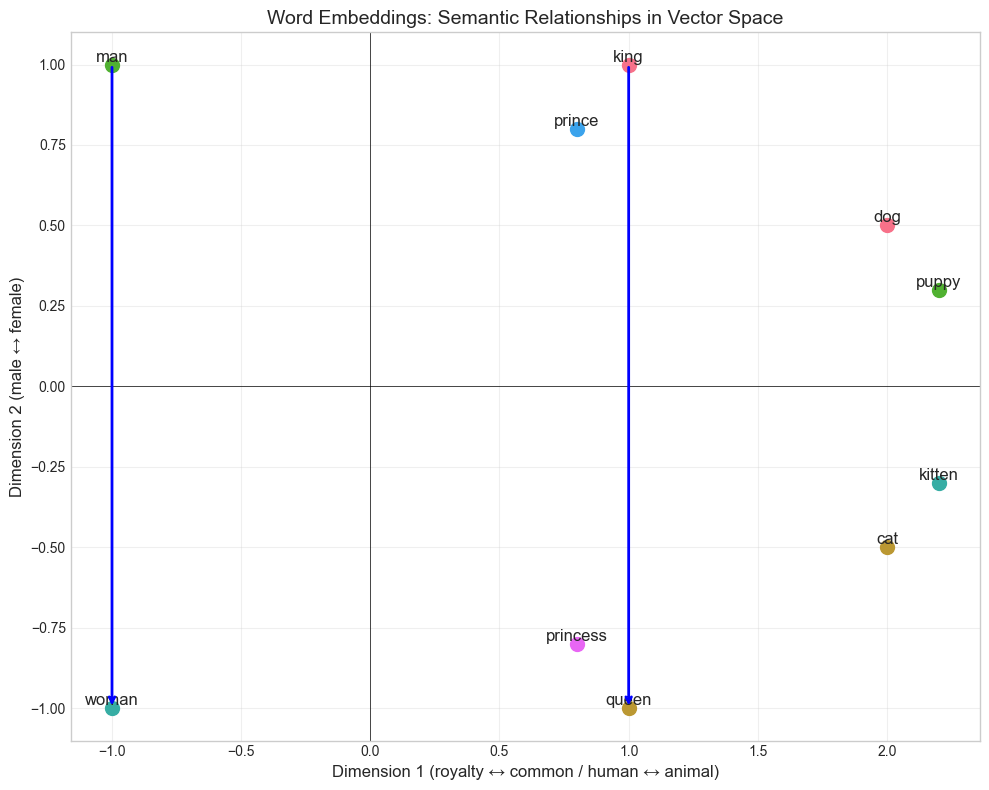


📌 Word Vector Arithmetic
--------------------------------------------------
king - man + woman = [1.0, -1.0]
queen embedding =    [1.0, -1.0]

The result is close to 'queen'! This is the famous word2vec analogy.


In [25]:
# ============================================
# EMBEDDING VISUALIZATION
# ============================================
print("\n" + "=" * 60)
print("EMBEDDING SPACE VISUALIZATION")
print("=" * 60)

# Create a small vocabulary with semantic relationships
words = ['king', 'queen', 'man', 'woman', 'prince', 'princess', 
         'dog', 'cat', 'puppy', 'kitten']
word_to_id = {w: i for i, w in enumerate(words)}

# Create embeddings with some structure (normally learned)
# We'll manually create embeddings that show semantic relationships
torch.manual_seed(42)
embed_dim = 2  # 2D for visualization

# Create embeddings with semantic structure
embeddings_2d = torch.tensor([
    [1.0, 1.0],    # king (royal, male)
    [1.0, -1.0],   # queen (royal, female)
    [-1.0, 1.0],   # man (common, male)
    [-1.0, -1.0],  # woman (common, female)
    [0.8, 0.8],    # prince (royal, male, young)
    [0.8, -0.8],   # princess (royal, female, young)
    [2.0, 0.5],    # dog (animal, larger)
    [2.0, -0.5],   # cat (animal, smaller)
    [2.2, 0.3],    # puppy (animal, larger, young)
    [2.2, -0.3],   # kitten (animal, smaller, young)
])

# Visualize
plt.figure(figsize=(10, 8))
for i, word in enumerate(words):
    x, y = embeddings_2d[i]
    plt.scatter(x, y, s=100)
    plt.annotate(word, (x, y), fontsize=12, ha='center', va='bottom')

# Draw relationship arrows
plt.annotate('', xy=embeddings_2d[1], xytext=embeddings_2d[0],
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
plt.annotate('', xy=embeddings_2d[3], xytext=embeddings_2d[2],
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))

plt.xlabel('Dimension 1 (royalty ↔ common / human ↔ animal)', fontsize=12)
plt.ylabel('Dimension 2 (male ↔ female)', fontsize=12)
plt.title('Word Embeddings: Semantic Relationships in Vector Space', fontsize=14)
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Demonstrate vector arithmetic
print("\n📌 Word Vector Arithmetic")
print("-" * 50)
king = embeddings_2d[word_to_id['king']]
man = embeddings_2d[word_to_id['man']]
woman = embeddings_2d[word_to_id['woman']]

result = king - man + woman
print(f"king - man + woman = {result.tolist()}")
print(f"queen embedding =    {embeddings_2d[word_to_id['queen']].tolist()}")
print("\nThe result is close to 'queen'! This is the famous word2vec analogy.")

## 2.3 Positional Encodings: Adding Position Information

### The Position Problem

Unlike RNNs that process tokens sequentially, transformers process all tokens in parallel. This is great for speed, but it means **the model has no inherent notion of position**.

Without positional information:
- "The cat sat on the mat" 
- "mat the on sat cat The"

Would produce identical representations! We need to inject position information.

### Positional Encoding Approaches

| Method | Formula | Learned? | Used In |
|--------|---------|----------|---------|
| Sinusoidal | sin/cos functions | No | Original Transformer |
| Learned | Embedding lookup | Yes | BERT, GPT-2 |
| Rotary (RoPE) | Rotation matrices | No | LLaMA, GPT-NeoX |
| ALiBi | Attention bias | No | BLOOM, MPT |

### Sinusoidal Positional Encoding (Vaswani et al., 2017)

From "Attention Is All You Need":

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- $pos$ = position in sequence (0, 1, 2, ...)
- $i$ = dimension index (0, 1, 2, ..., d_model/2)
- $d_{model}$ = embedding dimension

**Why sin/cos?**
1. Bounded values [-1, 1] (stable training)
2. Unique encoding for each position
3. Can extrapolate to longer sequences than seen in training
4. Relative positions can be computed via linear transformation

SINUSOIDAL POSITIONAL ENCODING

📌 Creating Sinusoidal Positional Encoding
--------------------------------------------------
d_model: 64
max_len: 100
PE matrix shape: torch.Size([1, 100, 64])


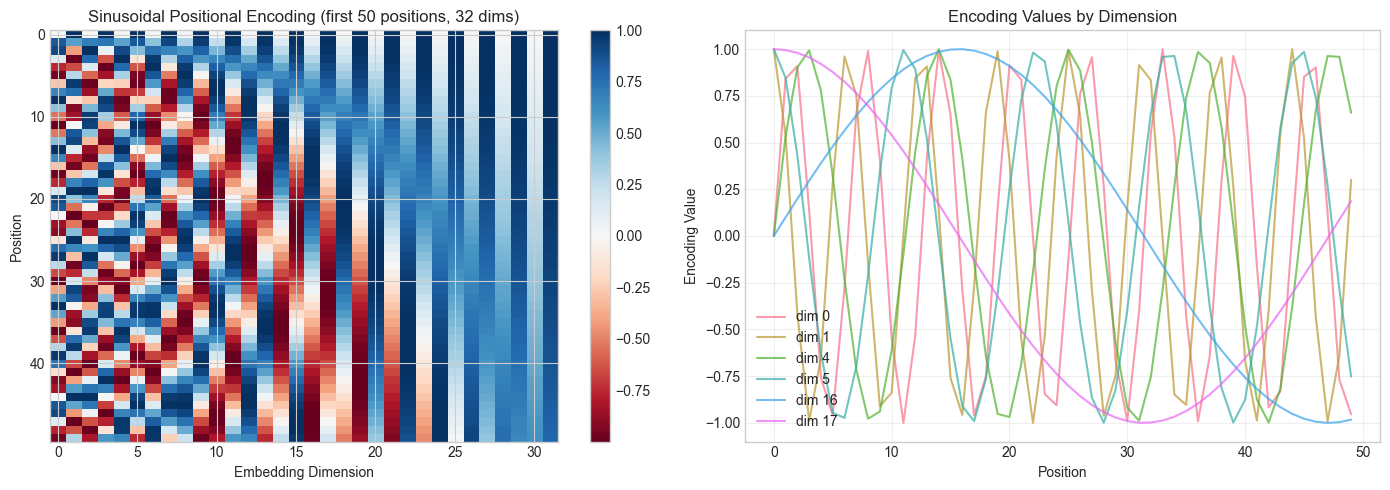


✅ Notice: Lower dimensions have higher frequency, higher dimensions have lower frequency
   This allows the model to attend to both fine-grained and coarse positions.


In [26]:
# ============================================
# SINUSOIDAL POSITIONAL ENCODING
# ============================================
print("=" * 60)
print("SINUSOIDAL POSITIONAL ENCODING")
print("=" * 60)

class SinusoidalPositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding from "Attention Is All You Need".
    
    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    
    The encoding is precomputed and stored as a buffer (not a parameter).
    
    Args:
        d_model: Embedding dimension
        max_len: Maximum sequence length to precompute
        dropout: Dropout probability
    
    Shape:
        - Input: (batch, seq_len, d_model)
        - Output: (batch, seq_len, d_model)
    """
    
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        
        # Compute the divisor term: 10000^(2i/d_model)
        # Using exp and log for numerical stability:
        # 10000^(2i/d_model) = exp(2i * log(10000) / d_model)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # (d_model/2,)
        
        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions
        
        # Add batch dimension and register as buffer (not a parameter)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encoding to input embeddings.
        
        Args:
            x: Token embeddings (batch, seq_len, d_model)
        
        Returns:
            Embeddings with positional information added
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return self.dropout(x)

# Test and visualize
print("\n📌 Creating Sinusoidal Positional Encoding")
print("-" * 50)

d_model = 64
max_len = 100
pe_layer = SinusoidalPositionalEncoding(d_model, max_len, dropout=0.0)

print(f"d_model: {d_model}")
print(f"max_len: {max_len}")
print(f"PE matrix shape: {pe_layer.pe.shape}")

# Visualize the encoding
pe_matrix = pe_layer.pe.squeeze(0).numpy()  # (max_len, d_model)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full encoding heatmap
ax = axes[0]
im = ax.imshow(pe_matrix[:50, :32], aspect='auto', cmap='RdBu')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Position')
ax.set_title('Sinusoidal Positional Encoding (first 50 positions, 32 dims)')
plt.colorbar(im, ax=ax)

# Individual dimension patterns
ax = axes[1]
positions = np.arange(50)
for dim in [0, 1, 4, 5, 16, 17]:
    ax.plot(positions, pe_matrix[:50, dim], label=f'dim {dim}', alpha=0.7)
ax.set_xlabel('Position')
ax.set_ylabel('Encoding Value')
ax.set_title('Encoding Values by Dimension')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Notice: Lower dimensions have higher frequency, higher dimensions have lower frequency")
print("   This allows the model to attend to both fine-grained and coarse positions.")


LEARNABLE POSITIONAL ENCODING

📌 Comparing Positional Encoding Approaches
--------------------------------------------------
Input shape: torch.Size([2, 20, 64])
Sinusoidal output shape: torch.Size([2, 20, 64])
Learned output shape: torch.Size([2, 20, 64])

Sinusoidal PE parameters: 0 (fixed)
Learned PE parameters: 6400


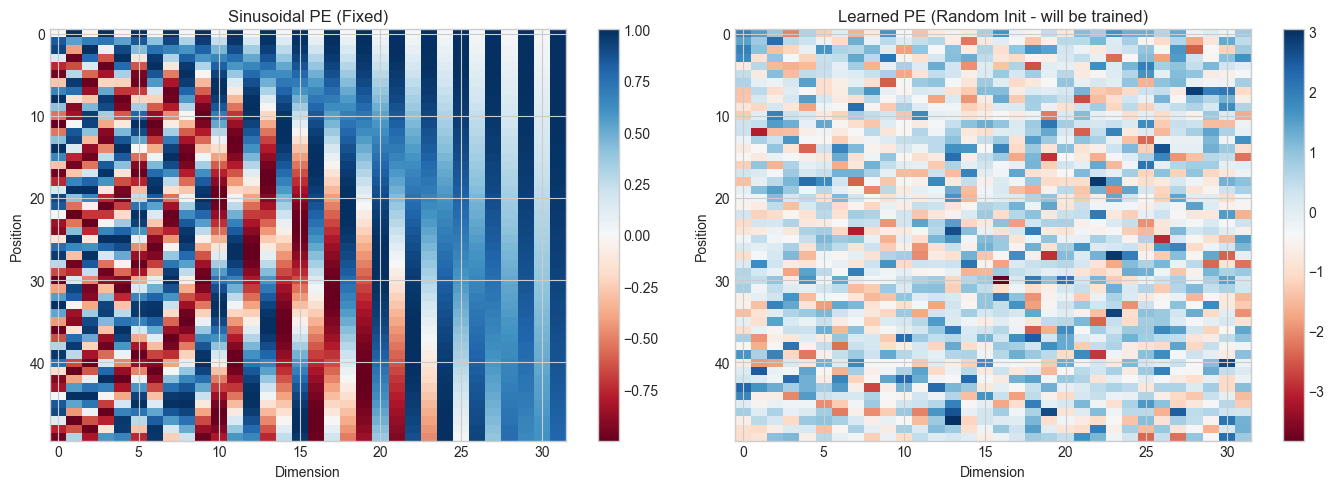


✅ Sinusoidal: Structured patterns, extrapolates to longer sequences
   Learned: Random at init, adapts during training, fixed max length


In [27]:
# ============================================
# LEARNABLE POSITIONAL ENCODING
# ============================================
print("\n" + "=" * 60)
print("LEARNABLE POSITIONAL ENCODING")
print("=" * 60)

class LearnedPositionalEncoding(nn.Module):
    """
    Learned positional encoding (used in BERT, GPT-2).
    
    Instead of fixed sin/cos patterns, we learn a separate embedding
    for each position. This is simply another embedding layer!
    
    Pros:
    - Can learn task-specific position patterns
    - Simple implementation
    
    Cons:
    - Cannot extrapolate beyond max_len seen in training
    - Adds parameters to the model
    
    Args:
        d_model: Embedding dimension
        max_len: Maximum sequence length
        dropout: Dropout probability
    """
    
    def __init__(self, d_model: int, max_len: int = 512, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Learnable position embeddings
        self.position_embedding = nn.Embedding(max_len, d_model)
        
        # Register position indices as buffer
        positions = torch.arange(max_len)
        self.register_buffer('positions', positions)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add learned positional encoding to input embeddings.
        
        Args:
            x: Token embeddings (batch, seq_len, d_model)
        
        Returns:
            Embeddings with positional information added
        """
        seq_len = x.size(1)
        positions = self.positions[:seq_len]  # (seq_len,)
        pos_embeddings = self.position_embedding(positions)  # (seq_len, d_model)
        x = x + pos_embeddings  # Broadcasting: (batch, seq_len, d_model) + (seq_len, d_model)
        return self.dropout(x)

# Compare both approaches
print("\n📌 Comparing Positional Encoding Approaches")
print("-" * 50)

d_model = 64
max_len = 100
batch_size = 2
seq_len = 20

# Create both encodings
sinusoidal_pe = SinusoidalPositionalEncoding(d_model, max_len, dropout=0.0)
learned_pe = LearnedPositionalEncoding(d_model, max_len, dropout=0.0)

# Create dummy embeddings
x = torch.randn(batch_size, seq_len, d_model)

# Apply both
sin_output = sinusoidal_pe(x)
learned_output = learned_pe(x)

print(f"Input shape: {x.shape}")
print(f"Sinusoidal output shape: {sin_output.shape}")
print(f"Learned output shape: {learned_output.shape}")

print(f"\nSinusoidal PE parameters: 0 (fixed)")
print(f"Learned PE parameters: {sum(p.numel() for p in learned_pe.parameters())}")

# Visualize learned embeddings (random initialization)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
sin_pe = sinusoidal_pe.pe.squeeze(0)[:50, :32].numpy()
im = ax.imshow(sin_pe, aspect='auto', cmap='RdBu')
ax.set_xlabel('Dimension')
ax.set_ylabel('Position')
ax.set_title('Sinusoidal PE (Fixed)')
plt.colorbar(im, ax=ax)

ax = axes[1]
learned_pe_matrix = learned_pe.position_embedding.weight[:50, :32].detach().numpy()
im = ax.imshow(learned_pe_matrix, aspect='auto', cmap='RdBu')
ax.set_xlabel('Dimension')
ax.set_ylabel('Position')
ax.set_title('Learned PE (Random Init - will be trained)')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("\n✅ Sinusoidal: Structured patterns, extrapolates to longer sequences")
print("   Learned: Random at init, adapts during training, fixed max length")

## 2.4 Complete Embedding Pipeline

### The Full Picture

In a transformer, the input goes through this pipeline:

```
Text → Tokenizer → Token IDs → Token Embedding → + Position Encoding → Transformer Input
```

Let's implement the complete pipeline that converts raw text into the tensor format transformers expect.

In [28]:
# ============================================
# COMPLETE EMBEDDING PIPELINE
# ============================================
print("=" * 60)
print("COMPLETE EMBEDDING PIPELINE")
print("=" * 60)

class TransformerEmbedding(nn.Module):
    """
    Complete embedding layer for transformers.
    
    Combines:
    1. Token embedding: token_id → vector
    2. Positional encoding: adds position information
    3. Dropout: regularization
    
    This is the first layer of any transformer model.
    
    Args:
        vocab_size: Size of vocabulary
        d_model: Embedding dimension
        max_len: Maximum sequence length
        dropout: Dropout probability
        use_learned_pe: If True, use learned positional encoding
    """
    
    def __init__(self, vocab_size: int, d_model: int, max_len: int = 512,
                 dropout: float = 0.1, use_learned_pe: bool = False):
        super().__init__()
        
        self.d_model = d_model
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        if use_learned_pe:
            self.pos_encoding = LearnedPositionalEncoding(d_model, max_len, dropout)
        else:
            self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len, dropout)
        
        # Scale factor (from original paper)
        # Embeddings are scaled by sqrt(d_model) to maintain variance
        self.scale = math.sqrt(d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Convert token IDs to transformer input.
        
        Args:
            x: Token IDs (batch, seq_len)
        
        Returns:
            Embeddings with position info (batch, seq_len, d_model)
        """
        # Token embedding with scaling
        # Scaling helps maintain gradient magnitude during training
        embeddings = self.token_embedding(x) * self.scale
        
        # Add positional encoding
        return self.pos_encoding(embeddings)

# Demo the complete pipeline
print("\n📌 Complete Embedding Pipeline Demo")
print("-" * 50)

# Configuration (typical small model)
vocab_size = 1000
d_model = 64
max_len = 128
batch_size = 2
seq_len = 10

# Create embedding layer
embedding_layer = TransformerEmbedding(
    vocab_size=vocab_size,
    d_model=d_model,
    max_len=max_len,
    dropout=0.1,
    use_learned_pe=False  # Using sinusoidal
)

# Simulate tokenized input
token_ids = torch.randint(0, vocab_size, (batch_size, seq_len))

print(f"Configuration:")
print(f"  vocab_size: {vocab_size}")
print(f"  d_model: {d_model}")
print(f"  max_len: {max_len}")
print(f"\nInput token IDs shape: {token_ids.shape}")
print(f"Input token IDs (first sequence): {token_ids[0].tolist()}")

# Forward pass
transformer_input = embedding_layer(token_ids)

print(f"\nOutput shape: {transformer_input.shape}")
print(f"Output dtype: {transformer_input.dtype}")
print(f"\nThis tensor is now ready to be fed into transformer layers!")

# Parameter count
total_params = sum(p.numel() for p in embedding_layer.parameters())
print(f"\nTotal embedding parameters: {total_params:,}")
print(f"  Token embedding: {vocab_size * d_model:,} ({vocab_size} × {d_model})")

COMPLETE EMBEDDING PIPELINE

📌 Complete Embedding Pipeline Demo
--------------------------------------------------
Configuration:
  vocab_size: 1000
  d_model: 64
  max_len: 128

Input token IDs shape: torch.Size([2, 10])
Input token IDs (first sequence): [751, 563, 635, 715, 708, 395, 354, 459, 707, 853]

Output shape: torch.Size([2, 10, 64])
Output dtype: torch.float32

This tensor is now ready to be fed into transformer layers!

Total embedding parameters: 64,000
  Token embedding: 64,000 (1000 × 64)


---

## 🎯 Module 2: Key Takeaways

### Tokenization
- **Character-level**: Small vocab, long sequences, hard to learn semantics
- **Word-level**: Large vocab, OOV problems, no morphology
- **Subword (BPE)**: Best of both worlds, used by all modern LLMs
- Special tokens: [PAD], [UNK], [CLS], [SEP], [MASK] serve specific purposes

### Embeddings
- Embedding = learned lookup table mapping token IDs to vectors
- Embedding matrix shape: (vocab_size, d_model)
- Semantically similar words cluster together in embedding space
- Famous property: king - man + woman ≈ queen

### Positional Encoding
- Transformers have no inherent position awareness (parallel processing)
- Must explicitly add position information

**Sinusoidal (Original Transformer)**:
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
- Fixed, no parameters, can extrapolate to longer sequences

**Learned (BERT, GPT-2)**:
- Separate embedding for each position
- Adapts to task, but fixed max length

### The Complete Pipeline
```
Text → Tokenize → Token IDs → Embed → Scale by √d_model → Add Position → Dropout → Transformer
```

### Embedding Scaling
- Embeddings are scaled by $\sqrt{d_{model}}$ to maintain variance
- This helps with gradient flow during training

---

**Next Module:** [Core Attention Mechanisms](#module-3-attention-mechanisms) - The heart of the transformer architecture

---

---

<a id='module-3-attention-mechanisms'></a>
# Module 3: Core Attention Mechanisms

**Prerequisites:** Module 1-2 (PyTorch, embeddings, positional encoding)

**Learning Objectives:**
By the end of this module, you will be able to:
- Understand the intuition behind attention mechanisms
- Implement scaled dot-product attention from scratch
- Implement multi-head attention with proper head splitting
- Visualize and interpret attention patterns
- Implement causal masking for autoregressive models

**Why This Matters:**
Attention is THE breakthrough that enabled transformers. It allows the model to dynamically focus on relevant parts of the input, regardless of distance. This module is the heart of everything that follows.

---

## 3.1 The Attention Mechanism: Intuition

### What Problem Does Attention Solve?

Before attention, sequence models (RNNs, LSTMs) had a fundamental limitation: information had to flow sequentially through the network. To connect the first and last words of a long sentence, information had to pass through every intermediate step, leading to:

1. **Vanishing gradients**: Hard to learn long-range dependencies
2. **Sequential bottleneck**: Can't parallelize computation
3. **Fixed context**: Each position has the same "view" of context

### The Attention Solution

Attention allows **direct connections** between any two positions:

```
"The cat sat on the mat because it was tired"
                                    ↑
                                   "it" attends directly to "cat"
```

Instead of passing information step-by-step, attention computes a weighted sum of all positions, where weights indicate relevance.

### Query, Key, Value: The Database Analogy

Think of attention like a database query:

| Concept | Database | Attention |
|---------|----------|-----------|
| **Query (Q)** | What you're searching for | Current token asking "what should I attend to?" |
| **Key (K)** | Index/tags of stored items | Each token's "identifier" for matching |
| **Value (V)** | Actual stored content | Information to retrieve if matched |

The attention process:
1. Compare Query with all Keys (compute similarity scores)
2. Convert scores to weights (softmax)
3. Weighted sum of Values

### The Attention Formula (Vaswani et al., 2017)

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- $Q \in \mathbb{R}^{n \times d_k}$ = Query matrix
- $K \in \mathbb{R}^{m \times d_k}$ = Key matrix  
- $V \in \mathbb{R}^{m \times d_v}$ = Value matrix
- $d_k$ = Key/Query dimension
- $\sqrt{d_k}$ = Scaling factor (prevents softmax saturation)

ATTENTION MECHANISM - STEP BY STEP

📌 Step 1: Query, Key, Value matrices
--------------------------------------------------
Q (Query) shape: torch.Size([4, 3])
K (Key) shape: torch.Size([4, 3])
V (Value) shape: torch.Size([4, 3])

📌 Step 2: Compute attention scores (Q @ K^T)
--------------------------------------------------
Scores shape: torch.Size([4, 4])
Scores matrix (how much each query matches each key):
tensor([[-0.0800,  0.6800, -0.0400,  0.3800],
        [ 2.3400, -1.4200,  0.4100,  0.3800],
        [ 3.0700,  1.6500, -0.5900,  2.0900],
        [-1.4100,  1.6200,  0.4900,  0.6500]])

📌 Step 3: Scale by sqrt(d_k)
--------------------------------------------------
d_k = 3, sqrt(d_k) = 1.732
Scaled scores:
tensor([[-0.0400,  0.4000, -0.0200,  0.2200],
        [ 1.3500, -0.8200,  0.2400,  0.2200],
        [ 1.7700,  0.9500, -0.3400,  1.2100],
        [-0.8100,  0.9400,  0.2800,  0.3800]])

Why scale? Large dot products → extreme softmax → vanishing gradients

📌 Step 4: Apply softm

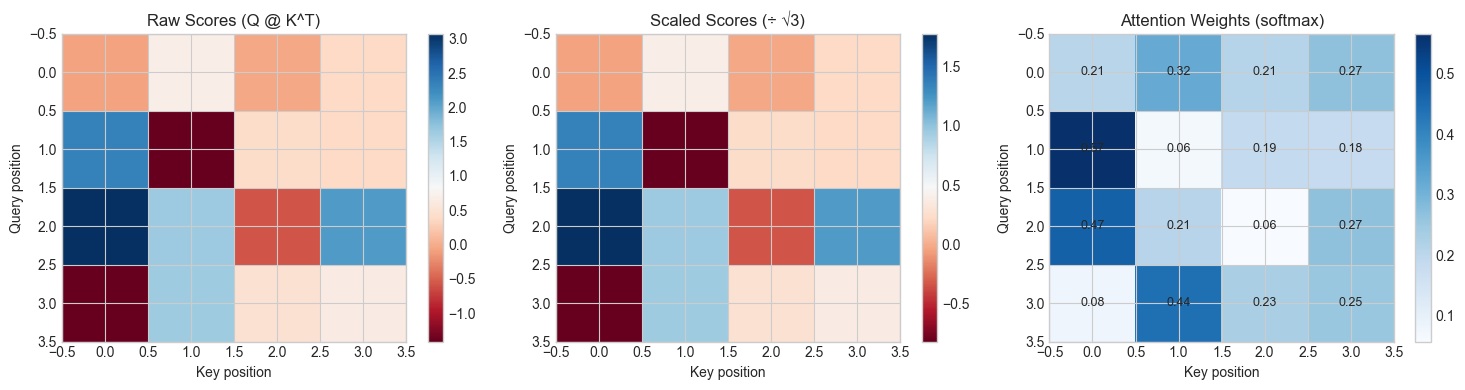

In [29]:
# ============================================
# ATTENTION STEP BY STEP
# ============================================
print("=" * 60)
print("ATTENTION MECHANISM - STEP BY STEP")
print("=" * 60)

# Simple example: 4 tokens, dimension 3
seq_len = 4
d_k = 3

# Create Q, K, V (normally these come from linear projections)
torch.manual_seed(42)
Q = torch.randn(seq_len, d_k)
K = torch.randn(seq_len, d_k)
V = torch.randn(seq_len, d_k)

print("\n📌 Step 1: Query, Key, Value matrices")
print("-" * 50)
print(f"Q (Query) shape: {Q.shape}")
print(f"K (Key) shape: {K.shape}")
print(f"V (Value) shape: {V.shape}")

print("\n📌 Step 2: Compute attention scores (Q @ K^T)")
print("-" * 50)
# Each query attends to all keys
scores = Q @ K.T  # (seq_len, seq_len)
print(f"Scores shape: {scores.shape}")
print(f"Scores matrix (how much each query matches each key):")
print(scores.round(decimals=2))

print("\n📌 Step 3: Scale by sqrt(d_k)")
print("-" * 50)
print(f"d_k = {d_k}, sqrt(d_k) = {math.sqrt(d_k):.3f}")
scaled_scores = scores / math.sqrt(d_k)
print(f"Scaled scores:")
print(scaled_scores.round(decimals=2))
print("\nWhy scale? Large dot products → extreme softmax → vanishing gradients")

print("\n📌 Step 4: Apply softmax (convert to probabilities)")
print("-" * 50)
attention_weights = F.softmax(scaled_scores, dim=-1)
print(f"Attention weights (each row sums to 1):")
print(attention_weights.round(decimals=2))
print(f"Row sums: {attention_weights.sum(dim=-1).tolist()}")

print("\n📌 Step 5: Weighted sum of values")
print("-" * 50)
output = attention_weights @ V  # (seq_len, d_k)
print(f"Output shape: {output.shape}")
print(f"Output (each row is a weighted combination of V rows):")
print(output.round(decimals=2))

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
im = ax.imshow(scores.numpy(), cmap='RdBu', aspect='auto')
ax.set_title('Raw Scores (Q @ K^T)')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
plt.colorbar(im, ax=ax)

ax = axes[1]
im = ax.imshow(scaled_scores.numpy(), cmap='RdBu', aspect='auto')
ax.set_title(f'Scaled Scores (÷ √{d_k})')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
plt.colorbar(im, ax=ax)

ax = axes[2]
im = ax.imshow(attention_weights.numpy(), cmap='Blues', aspect='auto')
ax.set_title('Attention Weights (softmax)')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
for i in range(seq_len):
    for j in range(seq_len):
        ax.text(j, i, f'{attention_weights[i,j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## 3.2 Scaled Dot-Product Attention Implementation

### The Complete Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### Why Scale by $\sqrt{d_k}$?

From the original paper: "We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients."

**Mathematical intuition**: If Q and K have components with mean 0 and variance 1, then $Q \cdot K$ has variance $d_k$. Dividing by $\sqrt{d_k}$ normalizes this back to variance 1.

### Handling Masks

We often need to prevent attention to certain positions:
- **Padding mask**: Don't attend to padding tokens
- **Causal mask**: Don't attend to future tokens (for autoregressive models)

Masking is done by setting scores to $-\infty$ before softmax, so those positions get weight 0.

In [30]:
# ============================================
# SCALED DOT-PRODUCT ATTENTION FROM SCRATCH
# ============================================
print("=" * 60)
print("SCALED DOT-PRODUCT ATTENTION")
print("=" * 60)

def scaled_dot_product_attention(
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    mask: Optional[torch.Tensor] = None,
    dropout: float = 0.0,
    training: bool = True
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Scaled Dot-Product Attention from "Attention Is All You Need".
    
    Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
    
    Args:
        query: Query tensor (..., seq_len_q, d_k)
        key: Key tensor (..., seq_len_k, d_k)
        value: Value tensor (..., seq_len_k, d_v)
        mask: Optional mask tensor, 1 = keep, 0 = mask out
        dropout: Dropout probability on attention weights
        training: Whether in training mode (for dropout)
    
    Returns:
        output: Attention output (..., seq_len_q, d_v)
        attention_weights: Attention weights (..., seq_len_q, seq_len_k)
    
    Shape notation:
        ... = batch dimensions (can be multiple, e.g., batch, heads)
        seq_len_q = query sequence length
        seq_len_k = key/value sequence length (can differ from q in cross-attention)
        d_k = key/query dimension
        d_v = value dimension
    """
    d_k = query.size(-1)
    
    # Step 1: Compute attention scores
    # (..., seq_len_q, d_k) @ (..., d_k, seq_len_k) -> (..., seq_len_q, seq_len_k)
    scores = torch.matmul(query, key.transpose(-2, -1))
    
    # Step 2: Scale by sqrt(d_k)
    scores = scores / math.sqrt(d_k)
    
    # Step 3: Apply mask (if provided)
    if mask is not None:
        # Mask positions with -inf so softmax gives 0
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Step 4: Softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Handle case where entire row is masked (all -inf -> nan after softmax)
    attention_weights = attention_weights.nan_to_num(0.0)
    
    # Step 5: Apply dropout (during training)
    if dropout > 0 and training:
        attention_weights = F.dropout(attention_weights, p=dropout, training=training)
    
    # Step 6: Weighted sum of values
    # (..., seq_len_q, seq_len_k) @ (..., seq_len_k, d_v) -> (..., seq_len_q, d_v)
    output = torch.matmul(attention_weights, value)
    
    return output, attention_weights

# Test the implementation
print("\n📌 Testing Scaled Dot-Product Attention")
print("-" * 50)

batch_size = 2
seq_len = 4
d_k = 8
d_v = 8

Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_v)

output, attn_weights = scaled_dot_product_attention(Q, K, V)

print(f"Query shape: {Q.shape}")
print(f"Key shape: {K.shape}")
print(f"Value shape: {V.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")

# Verify against PyTorch's implementation
pytorch_output = F.scaled_dot_product_attention(Q, K, V)
match = torch.allclose(output, pytorch_output, atol=1e-5)
print(f"\nMatches PyTorch F.scaled_dot_product_attention: {match} ✓")

SCALED DOT-PRODUCT ATTENTION

📌 Testing Scaled Dot-Product Attention
--------------------------------------------------
Query shape: torch.Size([2, 4, 8])
Key shape: torch.Size([2, 4, 8])
Value shape: torch.Size([2, 4, 8])
Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 4, 4])

Matches PyTorch F.scaled_dot_product_attention: True ✓


## 3.3 Multi-Head Attention

### Why Multiple Heads?

Single attention can only focus on one type of relationship at a time. **Multi-head attention** runs multiple attention operations in parallel, each learning different patterns:

- Head 1 might learn syntactic relationships (subject-verb)
- Head 2 might learn semantic relationships (synonyms)
- Head 3 might learn positional patterns (adjacent words)

### The Multi-Head Formula (Vaswani et al., 2017)

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

Where each head is:
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

### Dimension Management

For efficiency, we don't run $h$ separate attention operations. Instead:

1. Project Q, K, V to full dimension: $(B, S, d_{model})$
2. Reshape to separate heads: $(B, S, d_{model}) \rightarrow (B, h, S, d_k)$ where $d_k = d_{model}/h$
3. Run attention in parallel across heads
4. Reshape back and project: $(B, h, S, d_k) \rightarrow (B, S, d_{model})$

### Parameter Count

- $W^Q, W^K, W^V$: Each is $(d_{model}, d_{model})$ = $3 \times d_{model}^2$
- $W^O$: $(d_{model}, d_{model})$ = $d_{model}^2$
- **Total**: $4 \times d_{model}^2$ parameters

In [42]:
# ============================================
# MULTI-HEAD ATTENTION FROM SCRATCH
# ============================================
print("=" * 60)
print("MULTI-HEAD ATTENTION FROM SCRATCH")
print("=" * 60)

class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention from "Attention Is All You Need".
    
    MultiHead(Q, K, V) = Concat(head_1, ..., head_h) W^O
    where head_i = Attention(Q W_i^Q, K W_i^K, V W_i^V)
    
    Args:
        d_model: Model dimension (embedding size)
        n_heads: Number of attention heads
        dropout: Dropout probability
    
    Shape:
        - Input: query, key, value each (batch, seq_len, d_model)
        - Output: (batch, seq_len, d_model)
    """
    
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads  # Dimension per head
        
        # Linear projections for Q, K, V
        # Each projects from d_model to d_model (all heads combined)
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        
        self.dropout = nn.Dropout(dropout)
        
        # Store attention weights for visualization
        self.attention_weights = None
    
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Forward pass of multi-head attention.
        
        Args:
            query: (batch, seq_len_q, d_model)
            key: (batch, seq_len_k, d_model)
            value: (batch, seq_len_k, d_model)
            mask: Optional attention mask
        
        Returns:
            output: (batch, seq_len_q, d_model)
        """
        batch_size = query.size(0)
        
        # Step 1: Linear projections
        # (batch, seq_len, d_model) -> (batch, seq_len, d_model)
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # Step 2: Reshape to (batch, n_heads, seq_len, d_k)
        # This splits d_model into n_heads × d_k
        Q = Q.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        # Step 3: Scaled dot-product attention for all heads in parallel
        # Q, K, V: (batch, n_heads, seq_len, d_k)
        attn_output, self.attention_weights = scaled_dot_product_attention(
            Q, K, V, mask=mask, dropout=self.dropout.p, training=self.training
        )
        
        # Step 4: Concatenate heads
        # (batch, n_heads, seq_len, d_k) -> (batch, seq_len, n_heads, d_k) -> (batch, seq_len, d_model)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)
        
        # Step 5: Final linear projection
        output = self.W_o(attn_output)
        
        return output

# Test the implementation
print("\n📌 Testing Multi-Head Attention")
print("-" * 50)

d_model = 8192
n_heads = 64
batch_size = 2
seq_len = 10

mha = MultiHeadAttention(d_model, n_heads, dropout=0.0)

# Self-attention: Q = K = V
x = torch.randn(batch_size, seq_len, d_model)
output = mha(x, x, x)

print(f"Configuration:")
print(f"  d_model: {d_model}")
print(f"  n_heads: {n_heads}")
print(f"  d_k (per head): {d_model // n_heads}")
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {mha.attention_weights.shape}")

# Parameter count
total_params = sum(p.numel() for p in mha.parameters())
print(f"\nTotal parameters: {total_params:,}")
print(f"  W_q, W_k, W_v: 3 × {d_model}² = {3 * d_model**2:,}")
print(f"  W_o: {d_model}² = {d_model**2:,}")

MULTI-HEAD ATTENTION FROM SCRATCH

📌 Testing Multi-Head Attention
--------------------------------------------------
Configuration:
  d_model: 8192
  n_heads: 64
  d_k (per head): 128

Input shape: torch.Size([2, 10, 8192])
Output shape: torch.Size([2, 10, 8192])
Attention weights shape: torch.Size([2, 64, 10, 10])

Total parameters: 268,435,456
  W_q, W_k, W_v: 3 × 8192² = 201,326,592
  W_o: 8192² = 67,108,864



ATTENTION PATTERN VISUALIZATION


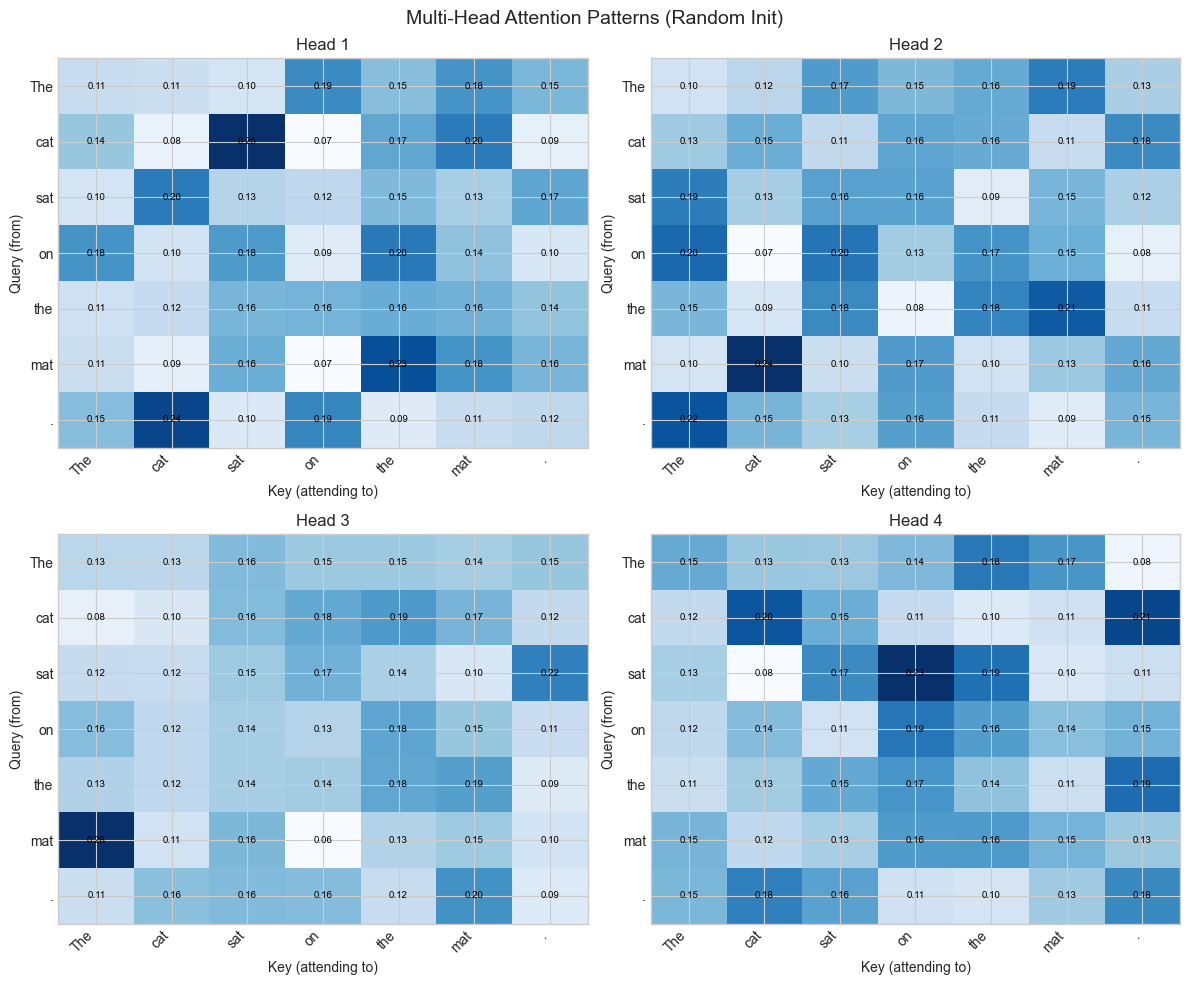


✅ Each head learns different attention patterns!
   After training, heads specialize in different linguistic relationships.


In [43]:
# ============================================
# VISUALIZE MULTI-HEAD ATTENTION PATTERNS
# ============================================
print("\n" + "=" * 60)
print("ATTENTION PATTERN VISUALIZATION")
print("=" * 60)

# Create a simple example with interpretable patterns
tokens = ["The", "cat", "sat", "on", "the", "mat", "."]
seq_len = len(tokens)
d_model = 32
n_heads = 4

# Create MHA and run on random embeddings
mha = MultiHeadAttention(d_model, n_heads, dropout=0.0)
x = torch.randn(1, seq_len, d_model)
_ = mha(x, x, x)

# Get attention weights: (1, n_heads, seq_len, seq_len)
attn = mha.attention_weights[0].detach()  # (n_heads, seq_len, seq_len)

# Visualize each head
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for head_idx in range(n_heads):
    ax = axes[head_idx]
    weights = attn[head_idx].numpy()
    
    im = ax.imshow(weights, cmap='Blues', aspect='auto')
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)
    ax.set_xlabel('Key (attending to)')
    ax.set_ylabel('Query (from)')
    ax.set_title(f'Head {head_idx + 1}')
    
    # Add values
    for i in range(seq_len):
        for j in range(seq_len):
            ax.text(j, i, f'{weights[i,j]:.2f}', ha='center', va='center', 
                   fontsize=7, color='white' if weights[i,j] > 0.5 else 'black')

plt.suptitle('Multi-Head Attention Patterns (Random Init)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✅ Each head learns different attention patterns!")
print("   After training, heads specialize in different linguistic relationships.")

## 3.4 Self-Attention vs Cross-Attention

### Self-Attention

In **self-attention**, Q, K, and V all come from the same sequence:

```python
output = attention(x, x, x)  # Q=K=V=x
```

Used in:
- Encoder layers (BERT)
- Decoder self-attention (GPT)

Each token attends to all other tokens in the same sequence.

### Cross-Attention

In **cross-attention**, Q comes from one sequence, K and V from another:

```python
output = attention(decoder_state, encoder_output, encoder_output)
```

Used in:
- Encoder-decoder models (original Transformer, T5)
- Decoder attending to encoder output

The decoder "queries" the encoder to find relevant information.

### Comparison

| Aspect | Self-Attention | Cross-Attention |
|--------|---------------|-----------------|
| Q source | Same sequence | Target sequence |
| K, V source | Same sequence | Source sequence |
| Purpose | Model relationships within sequence | Connect two sequences |
| Example | "The cat sat" understanding itself | Translation: English → French |

In [ ]:
# ============================================
# SELF-ATTENTION VS CROSS-ATTENTION
# ============================================
print("=" * 60)
print("SELF-ATTENTION VS CROSS-ATTENTION")
print("=" * 60)

d_model = 32
n_heads = 4
batch_size = 1

# Create attention layer
attn = MultiHeadAttention(d_model, n_heads, dropout=0.0)

# Self-attention example
print("\n📌 Self-Attention")
print("-" * 50)
encoder_seq = torch.randn(batch_size, 5, d_model)  # 5 tokens
self_attn_output = attn(encoder_seq, encoder_seq, encoder_seq)
print(f"Input sequence shape: {encoder_seq.shape}")
print(f"Q = K = V (same sequence)")
print(f"Output shape: {self_attn_output.shape}")
print(f"Attention matrix shape: {attn.attention_weights.shape[2:]} (5×5)")

# Cross-attention example
print("\n📌 Cross-Attention")
print("-" * 50)
decoder_seq = torch.randn(batch_size, 3, d_model)  # 3 tokens (target)
encoder_output = torch.randn(batch_size, 5, d_model)  # 5 tokens (source)

cross_attn_output = attn(decoder_seq, encoder_output, encoder_output)
print(f"Query (decoder) shape: {decoder_seq.shape}")
print(f"Key/Value (encoder) shape: {encoder_output.shape}")
print(f"Output shape: {cross_attn_output.shape}")
print(f"Attention matrix shape: {attn.attention_weights.shape[2:]} (3×5)")
print("\nNote: Each decoder token (3) attends to all encoder tokens (5)")

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Self-attention
_ = attn(encoder_seq, encoder_seq, encoder_seq)
self_weights = attn.attention_weights[0, 0].detach().numpy()
ax = axes[0]
im = ax.imshow(self_weights, cmap='Blues', aspect='auto')
ax.set_title('Self-Attention (5×5)')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
plt.colorbar(im, ax=ax)

# Cross-attention
_ = attn(decoder_seq, encoder_output, encoder_output)
cross_weights = attn.attention_weights[0, 0].detach().numpy()
ax = axes[1]
im = ax.imshow(cross_weights, cmap='Blues', aspect='auto')
ax.set_title('Cross-Attention (3×5)')
ax.set_xlabel('Encoder position (Key)')
ax.set_ylabel('Decoder position (Query)')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## 3.5 Causal Masking for Autoregressive Models

### The Autoregressive Constraint

In language models like GPT, we predict the next token based only on previous tokens:

$$P(x_t | x_1, x_2, ..., x_{t-1})$$

During training, we process entire sequences at once for efficiency, but each position should only "see" previous positions. This is enforced with a **causal mask**.

### The Causal Mask

A causal (or "look-ahead") mask is a lower triangular matrix:

```
Position:  0  1  2  3
        ┌─────────────┐
    0   │ 1  0  0  0  │  Token 0 sees only itself
    1   │ 1  1  0  0  │  Token 1 sees 0, 1
    2   │ 1  1  1  0  │  Token 2 sees 0, 1, 2
    3   │ 1  1  1  1  │  Token 3 sees all
        └─────────────┘
```

Positions with 0 are set to $-\infty$ before softmax, giving attention weight 0.

### Why Causal Masking Matters

Without causal masking:
- Model could "cheat" by looking at future tokens
- Would learn to copy rather than predict
- Wouldn't work for generation (no future tokens exist)

With causal masking:
- Each position learns to predict from context only
- Same model works for training and generation
- Enables parallel training of autoregressive models

CAUSAL MASKING

📌 Causal Mask Structure
--------------------------------------------------
Causal mask for sequence length 6:
tensor([[1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]], dtype=torch.int32)

1 = can attend, 0 = masked (cannot attend)

📌 Effect of Causal Mask on Attention
--------------------------------------------------


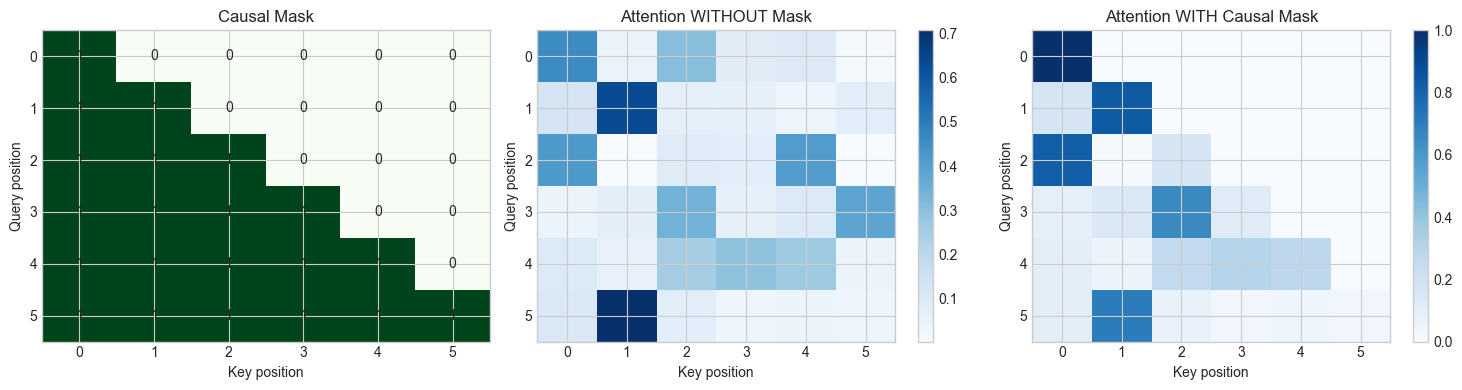


✅ With causal mask, each position can only attend to itself and earlier positions!
   This is essential for autoregressive language models like GPT.


In [44]:
# ============================================
# CAUSAL MASKING IMPLEMENTATION
# ============================================
print("=" * 60)
print("CAUSAL MASKING")
print("=" * 60)

def create_causal_mask(seq_len: int) -> torch.Tensor:
    """
    Create a causal (look-ahead) mask for autoregressive attention.
    
    Returns a lower triangular matrix where:
    - 1 = can attend (current and past positions)
    - 0 = cannot attend (future positions)
    
    Args:
        seq_len: Sequence length
    
    Returns:
        mask: (seq_len, seq_len) boolean tensor
    """
    # torch.tril creates lower triangular matrix
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

# Visualize causal mask
print("\n📌 Causal Mask Structure")
print("-" * 50)

seq_len = 6
mask = create_causal_mask(seq_len)

print(f"Causal mask for sequence length {seq_len}:")
print(mask.int())
print("\n1 = can attend, 0 = masked (cannot attend)")

# Show effect on attention
print("\n📌 Effect of Causal Mask on Attention")
print("-" * 50)

d_k = 8
Q = torch.randn(1, seq_len, d_k)
K = torch.randn(1, seq_len, d_k)
V = torch.randn(1, seq_len, d_k)

# Without mask
output_no_mask, weights_no_mask = scaled_dot_product_attention(Q, K, V)

# With causal mask
output_masked, weights_masked = scaled_dot_product_attention(Q, K, V, mask=mask)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
im = ax.imshow(mask.numpy(), cmap='Greens', aspect='auto')
ax.set_title('Causal Mask')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
for i in range(seq_len):
    for j in range(seq_len):
        ax.text(j, i, int(mask[i,j].item()), ha='center', va='center')

ax = axes[1]
im = ax.imshow(weights_no_mask[0].numpy(), cmap='Blues', aspect='auto')
ax.set_title('Attention WITHOUT Mask')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
plt.colorbar(im, ax=ax)

ax = axes[2]
im = ax.imshow(weights_masked[0].numpy(), cmap='Blues', aspect='auto')
ax.set_title('Attention WITH Causal Mask')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("\n✅ With causal mask, each position can only attend to itself and earlier positions!")
print("   This is essential for autoregressive language models like GPT.")

In [45]:
# ============================================
# MASKED MULTI-HEAD ATTENTION
# ============================================
print("\n" + "=" * 60)
print("MASKED MULTI-HEAD ATTENTION (GPT-style)")
print("=" * 60)

class CausalMultiHeadAttention(nn.Module):
    """
    Multi-Head Attention with built-in causal masking.
    
    This is the attention used in decoder-only models like GPT.
    Each position can only attend to previous positions.
    """
    
    def __init__(self, d_model: int, n_heads: int, max_len: int = 512, dropout: float = 0.1):
        super().__init__()
        
        self.mha = MultiHeadAttention(d_model, n_heads, dropout)
        
        # Pre-compute causal mask for efficiency
        # Register as buffer (not a parameter)
        mask = create_causal_mask(max_len)
        self.register_buffer('causal_mask', mask)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with automatic causal masking.
        
        Args:
            x: Input tensor (batch, seq_len, d_model)
        
        Returns:
            output: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        # Get the appropriate slice of the pre-computed mask
        mask = self.causal_mask[:seq_len, :seq_len]
        return self.mha(x, x, x, mask=mask)

# Test causal MHA
d_model = 64
n_heads = 8
batch_size = 2
seq_len = 10

causal_mha = CausalMultiHeadAttention(d_model, n_heads, max_len=100)
x = torch.randn(batch_size, seq_len, d_model)
output = causal_mha(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nThis is the attention layer used in GPT-style models!")

# Verify masking is working
attn_weights = causal_mha.mha.attention_weights[0, 0].detach()
print(f"\nAttention weights (first head, first batch):")
print(f"Upper triangle should be ~0 (masked):")
upper_triangle = torch.triu(attn_weights, diagonal=1)
print(f"Max value in upper triangle: {upper_triangle.max().item():.6f}")
print(f"(Should be ~0, confirming future positions are masked)")


MASKED MULTI-HEAD ATTENTION (GPT-style)
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

This is the attention layer used in GPT-style models!

Attention weights (first head, first batch):
Upper triangle should be ~0 (masked):
Max value in upper triangle: 0.000000
(Should be ~0, confirming future positions are masked)


---

## 🎯 Module 3: Key Takeaways

### The Attention Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

- **Q (Query)**: What am I looking for?
- **K (Key)**: What do I contain?
- **V (Value)**: What information do I provide?
- **Scaling by $\sqrt{d_k}$**: Prevents softmax saturation for large dimensions

### Multi-Head Attention

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

- Multiple heads learn different attention patterns in parallel
- Each head has dimension $d_k = d_{model} / h$
- Total parameters: $4 \times d_{model}^2$

### Self-Attention vs Cross-Attention

| Type | Q, K, V Source | Use Case |
|------|---------------|----------|
| Self-Attention | Same sequence | Encoder, decoder self-attention |
| Cross-Attention | Q: target, K/V: source | Encoder-decoder connection |

### Causal Masking

- Essential for autoregressive models (GPT)
- Lower triangular mask: each position sees only past
- Implemented by setting future positions to $-\infty$ before softmax

### Attention Complexity

- Time: $O(n^2 \cdot d)$ where $n$ = sequence length
- Memory: $O(n^2)$ for attention weights
- This quadratic scaling is why long sequences are challenging!

### Key Implementation Details

1. **Reshape for heads**: $(B, S, d_{model}) \rightarrow (B, h, S, d_k)$
2. **Parallel attention**: All heads computed simultaneously
3. **Concatenate and project**: $(B, h, S, d_k) \rightarrow (B, S, d_{model})$

---

**Next Module:** [Transformer Architecture from Scratch](#module-4-transformer-architecture) - Putting it all together

---

---

<a id='module-4-transformer-architecture'></a>
# Module 4: Transformer Architecture from Scratch

**Prerequisites:** Modules 1-3 (PyTorch, embeddings, attention mechanisms)

**Learning Objectives:**
By the end of this module, you will be able to:
- Implement all transformer sub-components from scratch
- Understand the role of each component in the architecture
- Build complete encoder and decoder blocks
- Assemble a full encoder-decoder transformer
- Train a transformer on a simple sequence-to-sequence task

**The Original Transformer (Vaswani et al., 2017)**

This module implements the architecture from "Attention Is All You Need" - the paper that started the LLM revolution.

---

## 4.1 Position-wise Feed-Forward Network

### The FFN Formula (Vaswani et al., 2017)

$\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$

Or more generally with any activation:

$\text{FFN}(x) = \text{Activation}(xW_1 + b_1)W_2 + b_2$

### Architecture Details

The FFN is applied **identically** to each position (hence "position-wise"):
- Input: $(\text{batch}, \text{seq\_len}, d_{model})$
- Hidden: $(\text{batch}, \text{seq\_len}, d_{ff})$ where typically $d_{ff} = 4 \times d_{model}$
- Output: $(\text{batch}, \text{seq\_len}, d_{model})$

### Why This Expansion?

The FFN provides:
1. **Non-linearity**: Attention is linear in V; FFN adds non-linear transformations
2. **Capacity**: The 4x expansion increases model capacity
3. **Per-position processing**: Each token gets independent transformation

### Parameter Count

- $W_1$: $(d_{model}, d_{ff})$ = $d_{model} \times 4d_{model}$
- $W_2$: $(d_{ff}, d_{model})$ = $4d_{model} \times d_{model}$
- **Total**: $8 \times d_{model}^2$ (2x the attention parameters!)

In [46]:
# ============================================
# POSITION-WISE FEED-FORWARD NETWORK
# ============================================
print("=" * 60)
print("POSITION-WISE FEED-FORWARD NETWORK")
print("=" * 60)

class PositionwiseFFN(nn.Module):
    """
    Position-wise Feed-Forward Network from "Attention Is All You Need".
    
    FFN(x) = Activation(x @ W1 + b1) @ W2 + b2
    
    Applied identically to each position in the sequence.
    
    Args:
        d_model: Model dimension
        d_ff: Feed-forward hidden dimension (typically 4 * d_model)
        dropout: Dropout probability
        activation: Activation function ('relu' or 'gelu')
    """
    
    def __init__(
        self, 
        d_model: int, 
        d_ff: int = None, 
        dropout: float = 0.1,
        activation: str = 'relu'
    ):
        super().__init__()
        
        if d_ff is None:
            d_ff = 4 * d_model
        
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError(f"Unknown activation: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            output: (batch, seq_len, d_model)
        """
        # x: (batch, seq_len, d_model)
        # -> (batch, seq_len, d_ff)
        # -> (batch, seq_len, d_model)
        
        x = self.linear1(x)      # Expand: d_model -> d_ff
        x = self.activation(x)    # Non-linearity
        x = self.dropout(x)       # Regularization
        x = self.linear2(x)       # Contract: d_ff -> d_model
        
        return x

# Test FFN
print("\n📌 Testing Position-wise FFN")
print("-" * 50)

d_model = 64
d_ff = 256  # 4x expansion
batch_size = 2
seq_len = 10

ffn = PositionwiseFFN(d_model, d_ff, dropout=0.0)
x = torch.randn(batch_size, seq_len, d_model)
output = ffn(x)

print(f"d_model: {d_model}")
print(f"d_ff: {d_ff} (4x expansion)")
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

# Parameter count
total_params = sum(p.numel() for p in ffn.parameters())
print(f"\nParameter count:")
print(f"  W1: {d_model} × {d_ff} = {d_model * d_ff:,}")
print(f"  b1: {d_ff:,}")
print(f"  W2: {d_ff} × {d_model} = {d_ff * d_model:,}")
print(f"  b2: {d_model:,}")
print(f"  Total: {total_params:,}")

# Verify position-wise independence
print("\n📌 Verifying Position-wise Independence")
print("-" * 50)
# Each position should be processed independently
x_single = x[:, 0:1, :]  # Just first position
output_single = ffn(x_single)
output_first = output[:, 0:1, :]

# They should be identical
match = torch.allclose(output_single, output_first, atol=1e-6)
print(f"Single position output matches full sequence: {match} ✓")
print("Each position is processed independently (no cross-position interaction)")

POSITION-WISE FEED-FORWARD NETWORK

📌 Testing Position-wise FFN
--------------------------------------------------
d_model: 64
d_ff: 256 (4x expansion)
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

Parameter count:
  W1: 64 × 256 = 16,384
  b1: 256
  W2: 256 × 64 = 16,384
  b2: 64
  Total: 33,088

📌 Verifying Position-wise Independence
--------------------------------------------------
Single position output matches full sequence: True ✓
Each position is processed independently (no cross-position interaction)


## 4.2 Layer Normalization from Scratch

### The LayerNorm Formula (Ba et al., 2016)

$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$

Where:
- $\mu = \frac{1}{d}\sum_{i=1}^{d} x_i$ (mean over features)
- $\sigma^2 = \frac{1}{d}\sum_{i=1}^{d} (x_i - \mu)^2$ (variance over features)
- $\gamma, \beta$ are learnable scale and shift parameters
- $\epsilon$ is a small constant for numerical stability

### Why Layer Normalization?

1. **Stabilizes training**: Keeps activations in a reasonable range
2. **Enables deeper networks**: Prevents vanishing/exploding gradients
3. **Position-independent**: Unlike BatchNorm, works the same for any sequence length

### LayerNorm vs BatchNorm

| Aspect | LayerNorm | BatchNorm |
|--------|-----------|-----------|
| Normalizes over | Features (d_model) | Batch dimension |
| Depends on batch size | No | Yes |
| Works for variable seq_len | Yes | Problematic |
| Used in Transformers | Yes | Rarely |

### Pre-Norm vs Post-Norm

**Original Transformer (Post-Norm):**
$x = \text{LayerNorm}(x + \text{Sublayer}(x))$

**Modern Transformers (Pre-Norm):**
$x = x + \text{Sublayer}(\text{LayerNorm}(x))$

Pre-Norm is more stable for training deep networks.

In [48]:
# ============================================
# LAYER NORMALIZATION FROM SCRATCH
# ============================================
print("=" * 60)
print("LAYER NORMALIZATION FROM SCRATCH")
print("=" * 60)

class LayerNorm(nn.Module):
    """
    Layer Normalization from "Layer Normalization" (Ba et al., 2016).
    
    LayerNorm(x) = gamma * (x - mean) / sqrt(var + eps) + beta
    
    Normalizes over the last dimension (features).
    
    Args:
        d_model: Feature dimension to normalize over
        eps: Small constant for numerical stability
    """
    
    def __init__(self, d_model: int, eps: float = 1e-6):
        super().__init__()
        
        self.eps = eps
        
        # Learnable parameters
        self.gamma = nn.Parameter(torch.ones(d_model))   # Scale
        self.beta = nn.Parameter(torch.zeros(d_model))   # Shift
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (..., d_model) - any shape with d_model as last dim
        Returns:
            normalized: Same shape as input
        """
        # Compute mean and variance over last dimension
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        # Normalize
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        # Scale and shift
        output = self.gamma * x_norm + self.beta
        
        return output

# Test our implementation
print("\n📌 Testing LayerNorm Implementation")
print("-" * 50)

d_model = 64
batch_size = 2
seq_len = 10

our_ln = LayerNorm(d_model)
pytorch_ln = nn.LayerNorm(d_model)

# Copy parameters for fair comparison
pytorch_ln.weight.data = our_ln.gamma.data.clone()
pytorch_ln.bias.data = our_ln.beta.data.clone()

x = torch.randn(batch_size, seq_len, d_model)

our_output = our_ln(x)
pytorch_output = pytorch_ln(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {our_output.shape}")

match = torch.allclose(our_output, pytorch_output, atol=1e-5)
print(f"\nMatches PyTorch nn.LayerNorm: {match} ✓")

# Show normalization effect
print("\n📌 Normalization Effect")
print("-" * 50)
print(f"Before LayerNorm:")
print(f"  Mean: {x[0, 0].mean().item():.4f}")
print(f"  Std:  {x[0, 0].std().item():.4f}")
print(f"After LayerNorm:")
print(f"  Mean: {our_output[0, 0].mean().item():.4f} (≈ 0)")
print(f"  Std:  {our_output[0, 0].std().item():.4f} (≈ 1)")

LAYER NORMALIZATION FROM SCRATCH

📌 Testing LayerNorm Implementation
--------------------------------------------------
Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])

Matches PyTorch nn.LayerNorm: True ✓

📌 Normalization Effect
--------------------------------------------------
Before LayerNorm:
  Mean: 0.1008
  Std:  0.9057
After LayerNorm:
  Mean: 0.0000 (≈ 0)
  Std:  1.0079 (≈ 1)



LAYERNORM VISUALIZATION


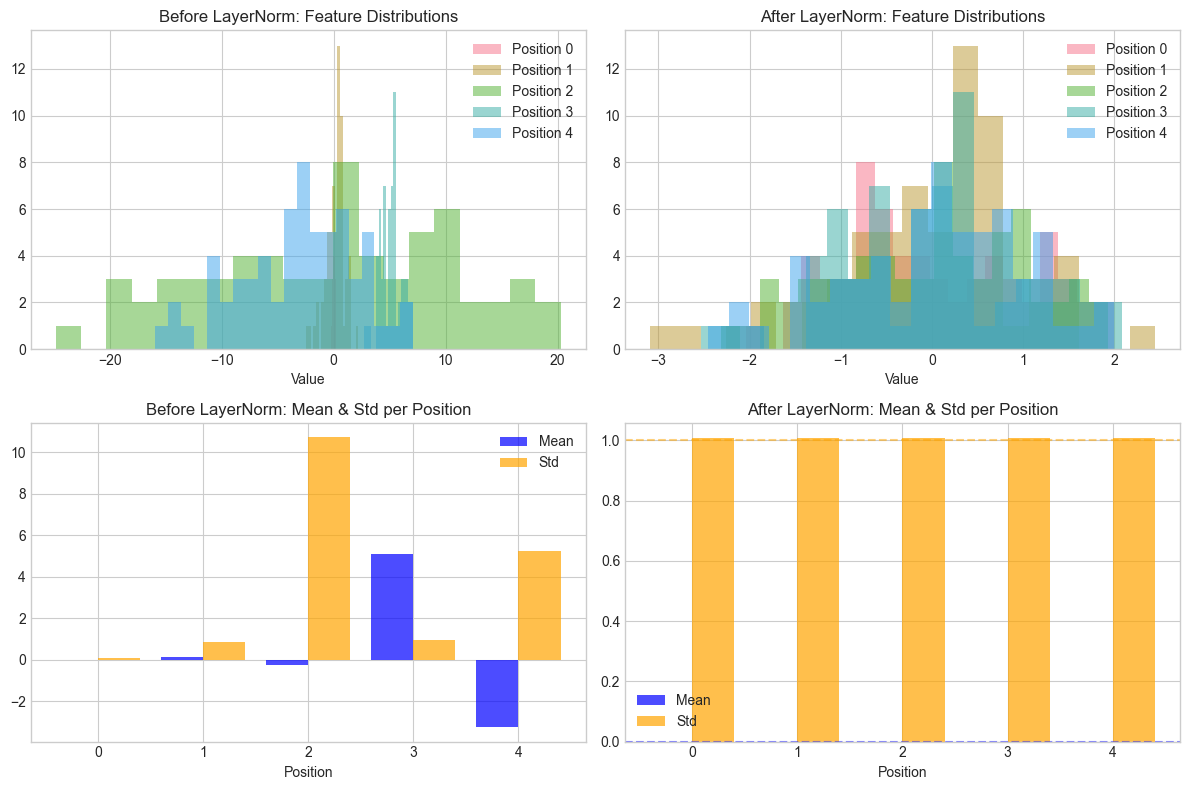


✅ LayerNorm normalizes each position independently to mean≈0, std≈1


In [49]:
# ============================================
# VISUALIZE LAYERNORM EFFECT
# ============================================
print("\n" + "=" * 60)
print("LAYERNORM VISUALIZATION")
print("=" * 60)

# Create data with varying scales
torch.manual_seed(42)
x = torch.randn(1, 5, 64)
x[:, 0, :] *= 0.1   # Small scale
x[:, 1, :] *= 1.0   # Normal scale
x[:, 2, :] *= 10.0  # Large scale
x[:, 3, :] += 5.0   # Shifted mean
x[:, 4, :] = x[:, 4, :] * 5.0 - 3.0  # Both

ln = LayerNorm(64)
x_norm = ln(x)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before normalization - distributions
ax = axes[0, 0]
for i in range(5):
    ax.hist(x[0, i].numpy(), bins=20, alpha=0.5, label=f'Position {i}')
ax.set_title('Before LayerNorm: Feature Distributions')
ax.set_xlabel('Value')
ax.legend()

# After normalization - distributions
ax = axes[0, 1]
for i in range(5):
    ax.hist(x_norm[0, i].detach().numpy(), bins=20, alpha=0.5, label=f'Position {i}')
ax.set_title('After LayerNorm: Feature Distributions')
ax.set_xlabel('Value')
ax.legend()

# Mean and std before
ax = axes[1, 0]
means = [x[0, i].mean().item() for i in range(5)]
stds = [x[0, i].std().item() for i in range(5)]
x_pos = range(5)
ax.bar([p - 0.2 for p in x_pos], means, 0.4, label='Mean', color='blue', alpha=0.7)
ax.bar([p + 0.2 for p in x_pos], stds, 0.4, label='Std', color='orange', alpha=0.7)
ax.set_title('Before LayerNorm: Mean & Std per Position')
ax.set_xlabel('Position')
ax.set_xticks(x_pos)
ax.legend()

# Mean and std after
ax = axes[1, 1]
means = [x_norm[0, i].mean().item() for i in range(5)]
stds = [x_norm[0, i].std().item() for i in range(5)]
ax.bar([p - 0.2 for p in x_pos], means, 0.4, label='Mean', color='blue', alpha=0.7)
ax.bar([p + 0.2 for p in x_pos], stds, 0.4, label='Std', color='orange', alpha=0.7)
ax.set_title('After LayerNorm: Mean & Std per Position')
ax.set_xlabel('Position')
ax.set_xticks(x_pos)
ax.axhline(y=0, color='blue', linestyle='--', alpha=0.5)
ax.axhline(y=1, color='orange', linestyle='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

print("\n✅ LayerNorm normalizes each position independently to mean≈0, std≈1")

## 4.3 Residual Connections

### The Skip Connection Formula (He et al., 2016)

$\text{output} = x + \text{Sublayer}(x)$

Or with Pre-Norm:
$\text{output} = x + \text{Sublayer}(\text{LayerNorm}(x))$

### Why Residual Connections?

**The Gradient Flow Problem:**
In deep networks, gradients must flow through many layers during backpropagation. Each layer can shrink gradients (vanishing) or explode them.

**The Solution:**
Residual connections provide a "gradient highway" - gradients can flow directly through the skip connection, bypassing problematic layers.

$\frac{\partial \mathcal{L}}{\partial x} = \frac{\partial \mathcal{L}}{\partial \text{output}} \cdot \left(1 + \frac{\partial \text{Sublayer}(x)}{\partial x}\right)$

The "1" term ensures gradients always flow, even if the sublayer gradient is small.

### Residual Connections in Transformers

Each transformer block has TWO residual connections:
1. Around the attention sublayer
2. Around the FFN sublayer

```
x ─────────────────────────────────┐
│                                  │
└──► LayerNorm ──► Attention ──────┴──► + ──► output
```

In [ ]:
# ============================================
# RESIDUAL CONNECTIONS
# ============================================
print("=" * 60)
print("RESIDUAL CONNECTIONS")
print("=" * 60)

class ResidualConnection(nn.Module):
    """
    Residual connection with layer normalization.
    
    Implements: output = x + Dropout(Sublayer(LayerNorm(x)))
    
    This is the Pre-Norm variant used in modern transformers.
    """
    
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, sublayer: callable) -> torch.Tensor:
        """
        Args:
            x: Input tensor
            sublayer: Function to apply (attention or FFN)
        Returns:
            x + sublayer(norm(x))
        """
        return x + self.dropout(sublayer(self.norm(x)))

# Demonstrate gradient flow
print("\n📌 Gradient Flow Through Residual Connection")
print("-" * 50)

d_model = 64
batch_size = 2
seq_len = 10

# Simple sublayer that might have vanishing gradients
class PotentiallyProblematicLayer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.linear = nn.Linear(d_model, d_model)
        # Initialize with small weights (could cause vanishing gradients)
        nn.init.normal_(self.linear.weight, std=0.01)
    
    def forward(self, x):
        return torch.tanh(self.linear(x))  # tanh can saturate

# Without residual connection
layer_no_res = PotentiallyProblematicLayer(d_model)
x = torch.randn(batch_size, seq_len, d_model, requires_grad=True)
output_no_res = layer_no_res(x)
loss_no_res = output_no_res.sum()
loss_no_res.backward()
grad_no_res = x.grad.abs().mean().item()

# With residual connection
x = torch.randn(batch_size, seq_len, d_model, requires_grad=True)
residual = ResidualConnection(d_model, dropout=0.0)
layer_with_res = PotentiallyProblematicLayer(d_model)
output_with_res = residual(x, layer_with_res)
loss_with_res = output_with_res.sum()
loss_with_res.backward()
grad_with_res = x.grad.abs().mean().item()

print(f"Mean gradient magnitude WITHOUT residual: {grad_no_res:.6f}")
print(f"Mean gradient magnitude WITH residual:    {grad_with_res:.6f}")
print(f"Ratio (with/without): {grad_with_res/grad_no_res:.2f}x")
print("\n✅ Residual connections help maintain gradient flow!")

In [ ]:
# ============================================
# VISUALIZE GRADIENT FLOW IN DEEP NETWORKS
# ============================================
print("\n" + "=" * 60)
print("GRADIENT FLOW IN DEEP NETWORKS")
print("=" * 60)

def measure_gradient_flow(n_layers, use_residual):
    """Measure gradient magnitude at each layer in a deep network."""
    d_model = 32
    
    class DeepNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.ModuleList([
                nn.Linear(d_model, d_model) for _ in range(n_layers)
            ])
            # Small initialization
            for layer in self.layers:
                nn.init.normal_(layer.weight, std=0.1)
        
        def forward(self, x):
            activations = [x]
            for layer in self.layers:
                if use_residual:
                    x = x + torch.tanh(layer(x))
                else:
                    x = torch.tanh(layer(x))
                activations.append(x)
            return x, activations
    
    model = DeepNetwork()
    x = torch.randn(1, d_model, requires_grad=True)
    output, activations = model(x)
    loss = output.sum()
    loss.backward()
    
    # Measure gradient at each layer
    gradients = []
    for layer in model.layers:
        grad_norm = layer.weight.grad.abs().mean().item()
        gradients.append(grad_norm)
    
    return gradients

n_layers = 20

grads_no_res = measure_gradient_flow(n_layers, use_residual=False)
grads_with_res = measure_gradient_flow(n_layers, use_residual=True)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_layers + 1), grads_no_res, 'r-o', label='Without Residual')
plt.plot(range(1, n_layers + 1), grads_with_res, 'b-o', label='With Residual')
plt.xlabel('Layer')
plt.ylabel('Mean Gradient Magnitude')
plt.title('Gradient Flow Through Layers')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(range(1, n_layers + 1), grads_no_res, 'r-o', label='Without Residual')
plt.semilogy(range(1, n_layers + 1), grads_with_res, 'b-o', label='With Residual')
plt.xlabel('Layer')
plt.ylabel('Mean Gradient Magnitude (log scale)')
plt.title('Gradient Flow (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Without residual connections, gradients vanish in deep networks!")
print("   Residual connections maintain gradient flow through all layers.")

## 4.4 Dropout from Scratch

### The Dropout Formula (Srivastava et al., 2014)

**During Training:**
$y_i = \frac{x_i \cdot m_i}{1 - p}$ where $m_i \sim \text{Bernoulli}(1-p)$

**During Inference:**
$y = x$ (no dropout)

### Why Scale by $\frac{1}{1-p}$?

This is called "inverted dropout". Without scaling:
- Training: Expected value = $(1-p) \cdot x$
- Inference: Expected value = $x$

With scaling during training:
- Training: Expected value = $\frac{(1-p) \cdot x}{1-p} = x$
- Inference: Expected value = $x$

This keeps expected values consistent between training and inference.

### Dropout in Transformers

Dropout is applied in three places:
1. **After attention weights** (before multiplying with V)
2. **After each sublayer** (attention and FFN)
3. **After embeddings** (input dropout)

Typical dropout rate: 0.1 for large models, 0.3 for smaller models.

In [ ]:
# ============================================
# DROPOUT FROM SCRATCH
# ============================================
print("=" * 60)
print("DROPOUT FROM SCRATCH")
print("=" * 60)

class Dropout(nn.Module):
    """
    Dropout regularization from "Dropout: A Simple Way to Prevent 
    Neural Networks from Overfitting" (Srivastava et al., 2014).
    
    During training: randomly zero out elements with probability p,
    then scale remaining elements by 1/(1-p).
    
    During inference: identity function (no dropout).
    """
    
    def __init__(self, p: float = 0.5):
        super().__init__()
        if not 0 <= p < 1:
            raise ValueError(f"Dropout probability must be in [0, 1), got {p}")
        self.p = p
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.p == 0:
            return x
        
        # Create binary mask: 1 with probability (1-p), 0 with probability p
        mask = torch.bernoulli(torch.full_like(x, 1 - self.p))
        
        # Apply mask and scale
        return x * mask / (1 - self.p)

# Test dropout
print("\n📌 Testing Dropout Implementation")
print("-" * 50)

p = 0.3
our_dropout = Dropout(p)
pytorch_dropout = nn.Dropout(p)

x = torch.ones(1000)

# Training mode
our_dropout.train()
pytorch_dropout.train()

our_output = our_dropout(x)
pytorch_output = pytorch_dropout(x)

print(f"Dropout probability: {p}")
print(f"Input: all ones, shape {x.shape}")
print(f"\nTraining mode:")
print(f"  Our dropout - zeros: {(our_output == 0).sum().item()}, "
      f"non-zeros scaled to: {our_output[our_output > 0].mean():.3f}")
print(f"  Expected zeros: ~{int(p * len(x))}, expected scale: {1/(1-p):.3f}")

# Verify expected value is preserved
print(f"\n  Input mean: {x.mean():.3f}")
print(f"  Output mean (our): {our_output.mean():.3f}")
print(f"  Output mean (pytorch): {pytorch_output.mean():.3f}")
print("  (Should be approximately equal due to scaling)")

# Eval mode
our_dropout.eval()
our_output_eval = our_dropout(x)
print(f"\nEval mode:")
print(f"  Output equals input: {torch.equal(our_output_eval, x)} ✓")

In [ ]:
# ============================================
# DROPOUT EFFECT ON TRAINING
# ============================================
print("\n" + "=" * 60)
print("DROPOUT REGULARIZATION EFFECT")
print("=" * 60)

# Create a simple overfitting scenario
torch.manual_seed(42)

# Small dataset that's easy to overfit
n_samples = 50
n_features = 20
X = torch.randn(n_samples, n_features)
# Non-linear target with noise
y = (X[:, 0] * X[:, 1] + 0.5 * X[:, 2]**2 + torch.randn(n_samples) * 0.1).unsqueeze(1)

# Split
X_train, X_test = X[:40], X[40:]
y_train, y_test = y[:40], y[40:]

class MLPWithDropout(nn.Module):
    def __init__(self, dropout_p):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.net(x)

def train_model(dropout_p, epochs=500):
    model = MLPWithDropout(dropout_p)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        pred = model(X_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Test
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, y_test)
            test_losses.append(test_loss.item())
    
    return train_losses, test_losses

# Train with different dropout rates
results = {}
for p in [0.0, 0.3, 0.5]:
    print(f"Training with dropout={p}...")
    results[p] = train_model(p)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for p, (train_loss, _) in results.items():
    ax.plot(train_loss, label=f'Dropout={p}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss')
ax.legend()
ax.set_yscale('log')

ax = axes[1]
for p, (_, test_loss) in results.items():
    ax.plot(test_loss, label=f'Dropout={p}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Test Loss')
ax.set_title('Test Loss (Generalization)')
ax.legend()
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print("\n✅ Dropout helps prevent overfitting by regularizing the network!")
print("   Without dropout: low train loss, high test loss (overfitting)")
print("   With dropout: slightly higher train loss, but better generalization")

## 4.5 Transformer Encoder Block

### Encoder Block Architecture

The encoder block consists of two sublayers with residual connections:

```
Input x
    │
    ├───────────────────────────────┐
    ▼                               │
LayerNorm                           │
    │                               │
    ▼                               │
Multi-Head Self-Attention           │
    │                               │
    ▼                               │
Dropout                             │
    │                               │
    ▼                               │
    + ◄─────────────────────────────┘
    │
    ├───────────────────────────────┐
    ▼                               │
LayerNorm                           │
    │                               │
    ▼                               │
Position-wise FFN                   │
    │                               │
    ▼                               │
Dropout                             │
    │                               │
    ▼                               │
    + ◄─────────────────────────────┘
    │
    ▼
Output
```

### Key Properties

1. **Bidirectional attention**: Each position attends to all positions
2. **Pre-Norm**: LayerNorm before sublayers (modern variant)
3. **Two residual connections**: One per sublayer
4. **Same input/output dimension**: $(B, S, d_{model})$

In [ ]:
# ============================================
# TRANSFORMER ENCODER BLOCK
# ============================================
print("=" * 60)
print("TRANSFORMER ENCODER BLOCK")
print("=" * 60)

class TransformerEncoderBlock(nn.Module):
    """
    Single Transformer Encoder Block.
    
    Architecture (Pre-Norm variant):
        x -> LayerNorm -> MultiHeadAttention -> Dropout -> + -> 
             LayerNorm -> FFN -> Dropout -> + -> output
    
    Args:
        d_model: Model dimension
        n_heads: Number of attention heads
        d_ff: FFN hidden dimension
        dropout: Dropout probability
    """
    
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int = None,
        dropout: float = 0.1
    ):
        super().__init__()
        
        if d_ff is None:
            d_ff = 4 * d_model
        
        # Self-attention sublayer
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # FFN sublayer
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
            mask: Optional attention mask
        Returns:
            output: (batch, seq_len, d_model)
        """
        # Self-attention with residual
        residual = x
        x = self.norm1(x)
        x = self.self_attn(x, x, x, mask)  # Q=K=V for self-attention
        x = self.dropout1(x)
        x = residual + x
        
        # FFN with residual
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout2(x)
        x = residual + x
        
        return x

# Test encoder block
print("\n📌 Testing Encoder Block")
print("-" * 50)

d_model = 64
n_heads = 8
d_ff = 256
batch_size = 2
seq_len = 10

encoder_block = TransformerEncoderBlock(d_model, n_heads, d_ff, dropout=0.1)
x = torch.randn(batch_size, seq_len, d_model)
output = encoder_block(x)

print(f"Configuration:")
print(f"  d_model: {d_model}")
print(f"  n_heads: {n_heads}")
print(f"  d_ff: {d_ff}")
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")

# Parameter count
total_params = sum(p.numel() for p in encoder_block.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Breakdown
attn_params = sum(p.numel() for p in encoder_block.self_attn.parameters())
ffn_params = sum(p.numel() for p in encoder_block.ffn.parameters())
norm_params = sum(p.numel() for p in encoder_block.norm1.parameters()) + \
              sum(p.numel() for p in encoder_block.norm2.parameters())
print(f"  Attention: {attn_params:,}")
print(f"  FFN: {ffn_params:,}")
print(f"  LayerNorms: {norm_params:,}")

## 4.6 Transformer Decoder Block

### Decoder Block Architecture

The decoder has THREE sublayers (one more than encoder):

```
Input x (target sequence)
    │
    ├───────────────────────────────┐
    ▼                               │
LayerNorm                           │
    │                               │
    ▼                               │
Masked Self-Attention ◄── Causal    │
    │                     Mask      │
    ▼                               │
Dropout                             │
    │                               │
    ▼                               │
    + ◄─────────────────────────────┘
    │
    ├───────────────────────────────┐
    ▼                               │
LayerNorm                           │
    │                               │
    ▼                               │
Cross-Attention ◄── Encoder Output  │
    │                               │
    ▼                               │
Dropout                             │
    │                               │
    ▼                               │
    + ◄─────────────────────────────┘
    │
    ├───────────────────────────────┐
    ▼                               │
LayerNorm                           │
    │                               │
    ▼                               │
Position-wise FFN                   │
    │                               │
    ▼                               │
Dropout                             │
    │                               │
    ▼                               │
    + ◄─────────────────────────────┘
    │
    ▼
Output
```

### Key Differences from Encoder

1. **Masked self-attention**: Causal mask prevents attending to future tokens
2. **Cross-attention**: Attends to encoder output (Q from decoder, K/V from encoder)
3. **Three sublayers**: Self-attn → Cross-attn → FFN

In [ ]:
# ============================================
# TRANSFORMER DECODER BLOCK
# ============================================
print("=" * 60)
print("TRANSFORMER DECODER BLOCK")
print("=" * 60)

class TransformerDecoderBlock(nn.Module):
    """
    Single Transformer Decoder Block.
    
    Architecture (Pre-Norm variant):
        x -> LayerNorm -> MaskedSelfAttention -> Dropout -> + ->
             LayerNorm -> CrossAttention(encoder_output) -> Dropout -> + ->
             LayerNorm -> FFN -> Dropout -> + -> output
    
    Args:
        d_model: Model dimension
        n_heads: Number of attention heads
        d_ff: FFN hidden dimension
        dropout: Dropout probability
    """
    
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int = None,
        dropout: float = 0.1
    ):
        super().__init__()
        
        if d_ff is None:
            d_ff = 4 * d_model
        
        # Masked self-attention sublayer
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # Cross-attention sublayer
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm2 = LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        # FFN sublayer
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout)
        self.norm3 = LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)
    
    def forward(
        self,
        x: torch.Tensor,
        encoder_output: torch.Tensor,
        self_attn_mask: Optional[torch.Tensor] = None,
        cross_attn_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            x: Decoder input (batch, tgt_len, d_model)
            encoder_output: Encoder output (batch, src_len, d_model)
            self_attn_mask: Causal mask for self-attention
            cross_attn_mask: Optional mask for cross-attention (e.g., padding)
        Returns:
            output: (batch, tgt_len, d_model)
        """
        # Masked self-attention with residual
        residual = x
        x = self.norm1(x)
        x = self.self_attn(x, x, x, mask=self_attn_mask)
        x = self.dropout1(x)
        x = residual + x
        
        # Cross-attention with residual
        # Q from decoder, K/V from encoder
        residual = x
        x = self.norm2(x)
        x = self.cross_attn(x, encoder_output, encoder_output, mask=cross_attn_mask)
        x = self.dropout2(x)
        x = residual + x
        
        # FFN with residual
        residual = x
        x = self.norm3(x)
        x = self.ffn(x)
        x = self.dropout3(x)
        x = residual + x
        
        return x

# Test decoder block
print("\n📌 Testing Decoder Block")
print("-" * 50)

d_model = 64
n_heads = 8
d_ff = 256
batch_size = 2
src_len = 10  # Encoder sequence length
tgt_len = 8   # Decoder sequence length

decoder_block = TransformerDecoderBlock(d_model, n_heads, d_ff, dropout=0.1)

# Inputs
decoder_input = torch.randn(batch_size, tgt_len, d_model)
encoder_output = torch.randn(batch_size, src_len, d_model)

# Causal mask for self-attention
causal_mask = torch.tril(torch.ones(tgt_len, tgt_len))

output = decoder_block(decoder_input, encoder_output, self_attn_mask=causal_mask)

print(f"Configuration:")
print(f"  d_model: {d_model}")
print(f"  n_heads: {n_heads}")
print(f"  d_ff: {d_ff}")
print(f"\nDecoder input shape: {decoder_input.shape}")
print(f"Encoder output shape: {encoder_output.shape}")
print(f"Causal mask shape: {causal_mask.shape}")
print(f"Output shape: {output.shape}")

# Parameter count
total_params = sum(p.numel() for p in decoder_block.parameters())
print(f"\nTotal parameters: {total_params:,}")
print(f"  (More than encoder due to cross-attention layer)")

## 4.7 Full Encoder-Decoder Transformer

### Complete Architecture (Vaswani et al., 2017)

```
Source Sequence                          Target Sequence
      │                                        │
      ▼                                        ▼
Input Embedding                          Output Embedding
      │                                        │
      ▼                                        ▼
   + Positional                            + Positional
   Encoding                                Encoding
      │                                        │
      ▼                                        │
┌─────────────┐                                │
│   Encoder   │                                │
│   Block 1   │                                │
└─────────────┘                                │
      │                                        │
      ▼                                        │
┌─────────────┐                                │
│   Encoder   │                                │
│   Block 2   │                                │
└─────────────┘                                │
      │                                        │
      ⋮ (N layers)                             │
      │                                        │
      ▼                                        ▼
Encoder Output ─────────────────────► ┌─────────────┐
                                      │   Decoder   │
                                      │   Block 1   │
                                      └─────────────┘
                                            │
                                            ▼
                                      ┌─────────────┐
                                      │   Decoder   │
                                      │   Block 2   │
                                      └─────────────┘
                                            │
                                            ⋮ (N layers)
                                            │
                                            ▼
                                       LayerNorm
                                            │
                                            ▼
                                    Linear (vocab_size)
                                            │
                                            ▼
                                        Softmax
                                            │
                                            ▼
                                    Output Probabilities
```

### Original Transformer Configuration

| Parameter | Value |
|-----------|-------|
| $d_{model}$ | 512 |
| $d_{ff}$ | 2048 |
| $h$ (heads) | 8 |
| $N$ (layers) | 6 |
| $d_k = d_v$ | 64 |
| Dropout | 0.1 |

In [ ]:
# ============================================
# FULL ENCODER-DECODER TRANSFORMER
# ============================================
print("=" * 60)
print("FULL ENCODER-DECODER TRANSFORMER")
print("=" * 60)

class Transformer(nn.Module):
    """
    Full Encoder-Decoder Transformer from "Attention Is All You Need".
    
    Args:
        src_vocab_size: Source vocabulary size
        tgt_vocab_size: Target vocabulary size
        d_model: Model dimension
        n_heads: Number of attention heads
        n_encoder_layers: Number of encoder layers
        n_decoder_layers: Number of decoder layers
        d_ff: FFN hidden dimension
        max_len: Maximum sequence length
        dropout: Dropout probability
    """
    
    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        d_model: int = 512,
        n_heads: int = 8,
        n_encoder_layers: int = 6,
        n_decoder_layers: int = 6,
        d_ff: int = 2048,
        max_len: int = 512,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = self._create_positional_encoding(max_len, d_model)
        
        # Encoder
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_encoder_layers)
        ])
        self.encoder_norm = LayerNorm(d_model)
        
        # Decoder
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_decoder_layers)
        ])
        self.decoder_norm = LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize parameters
        self._init_parameters()
    
    def _create_positional_encoding(self, max_len: int, d_model: int) -> torch.Tensor:
        """Create sinusoidal positional encoding."""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe.unsqueeze(0)  # (1, max_len, d_model)
    
    def _init_parameters(self):
        """Initialize parameters with Xavier uniform."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def _create_causal_mask(self, size: int) -> torch.Tensor:
        """Create causal mask for decoder self-attention."""
        return torch.tril(torch.ones(size, size))
    
    def encode(
        self,
        src: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Encode source sequence.
        
        Args:
            src: Source token IDs (batch, src_len)
            src_mask: Optional padding mask
        Returns:
            encoder_output: (batch, src_len, d_model)
        """
        # Embed and add positional encoding
        src_len = src.size(1)
        x = self.src_embedding(src) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:, :src_len, :].to(x.device)
        x = self.dropout(x)
        
        # Pass through encoder layers
        for layer in self.encoder_layers:
            x = layer(x, mask=src_mask)
        
        return self.encoder_norm(x)
    
    def decode(
        self,
        tgt: torch.Tensor,
        encoder_output: torch.Tensor,
        tgt_mask: Optional[torch.Tensor] = None,
        memory_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Decode target sequence.
        
        Args:
            tgt: Target token IDs (batch, tgt_len)
            encoder_output: Encoder output (batch, src_len, d_model)
            tgt_mask: Causal mask for self-attention
            memory_mask: Optional mask for cross-attention
        Returns:
            decoder_output: (batch, tgt_len, d_model)
        """
        # Embed and add positional encoding
        tgt_len = tgt.size(1)
        x = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        x = x + self.pos_encoding[:, :tgt_len, :].to(x.device)
        x = self.dropout(x)
        
        # Create causal mask if not provided
        if tgt_mask is None:
            tgt_mask = self._create_causal_mask(tgt_len).to(x.device)
        
        # Pass through decoder layers
        for layer in self.decoder_layers:
            x = layer(x, encoder_output, self_attn_mask=tgt_mask, cross_attn_mask=memory_mask)
        
        return self.decoder_norm(x)
    
    def forward(
        self,
        src: torch.Tensor,
        tgt: torch.Tensor,
        src_mask: Optional[torch.Tensor] = None,
        tgt_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Full forward pass.
        
        Args:
            src: Source token IDs (batch, src_len)
            tgt: Target token IDs (batch, tgt_len)
            src_mask: Optional source padding mask
            tgt_mask: Optional target causal mask
        Returns:
            logits: (batch, tgt_len, tgt_vocab_size)
        """
        encoder_output = self.encode(src, src_mask)
        decoder_output = self.decode(tgt, encoder_output, tgt_mask)
        logits = self.output_projection(decoder_output)
        
        return logits

# Test the full transformer
print("\n📌 Testing Full Transformer")
print("-" * 50)

# Small configuration for testing
config = {
    'src_vocab_size': 1000,
    'tgt_vocab_size': 1000,
    'd_model': 64,
    'n_heads': 4,
    'n_encoder_layers': 2,
    'n_decoder_layers': 2,
    'd_ff': 256,
    'max_len': 100,
    'dropout': 0.1
}

transformer = Transformer(**config)

batch_size = 2
src_len = 10
tgt_len = 8

src = torch.randint(0, config['src_vocab_size'], (batch_size, src_len))
tgt = torch.randint(0, config['tgt_vocab_size'], (batch_size, tgt_len))

logits = transformer(src, tgt)

print(f"Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")
print(f"\nSource shape: {src.shape}")
print(f"Target shape: {tgt.shape}")
print(f"Output logits shape: {logits.shape}")

# Parameter count
total_params = sum(p.numel() for p in transformer.parameters())
print(f"\nTotal parameters: {total_params:,}")

## 4.8 Weight Initialization

### Why Initialization Matters

Poor initialization can cause:
- **Vanishing gradients**: Weights too small → activations shrink → gradients vanish
- **Exploding gradients**: Weights too large → activations explode → training unstable
- **Symmetry**: Identical weights → neurons learn the same thing

### Xavier/Glorot Initialization (Glorot & Bengio, 2010)

For layers with tanh or sigmoid activation:

$W \sim \mathcal{U}\left(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right)$

Or normal distribution:
$W \sim \mathcal{N}\left(0, \frac{2}{n_{in} + n_{out}}\right)$

**Goal**: Keep variance of activations constant across layers.

### He/Kaiming Initialization (He et al., 2015)

For layers with ReLU activation:

$W \sim \mathcal{N}\left(0, \frac{2}{n_{in}}\right)$

**Why different?** ReLU zeros out half the activations, so we need 2x variance.

### Transformer-Specific Initialization

The original paper uses Xavier uniform. Modern practices:
- **Embeddings**: $\mathcal{N}(0, 1)$ or $\mathcal{N}(0, 1/\sqrt{d_{model}})$
- **Linear layers**: Xavier uniform
- **Output projection**: Sometimes scaled by $1/\sqrt{N}$ where N = number of layers

In [ ]:
# ============================================
# WEIGHT INITIALIZATION
# ============================================
print("=" * 60)
print("WEIGHT INITIALIZATION")
print("=" * 60)

def xavier_uniform_(tensor: torch.Tensor) -> torch.Tensor:
    """
    Xavier/Glorot uniform initialization.
    
    W ~ U(-sqrt(6/(fan_in + fan_out)), sqrt(6/(fan_in + fan_out)))
    """
    fan_in, fan_out = tensor.size(-2), tensor.size(-1)
    bound = math.sqrt(6.0 / (fan_in + fan_out))
    return tensor.uniform_(-bound, bound)

def xavier_normal_(tensor: torch.Tensor) -> torch.Tensor:
    """
    Xavier/Glorot normal initialization.
    
    W ~ N(0, 2/(fan_in + fan_out))
    """
    fan_in, fan_out = tensor.size(-2), tensor.size(-1)
    std = math.sqrt(2.0 / (fan_in + fan_out))
    return tensor.normal_(0, std)

def he_normal_(tensor: torch.Tensor) -> torch.Tensor:
    """
    He/Kaiming normal initialization for ReLU.
    
    W ~ N(0, 2/fan_in)
    """
    fan_in = tensor.size(-2)
    std = math.sqrt(2.0 / fan_in)
    return tensor.normal_(0, std)

# Compare initializations
print("\n📌 Comparing Initialization Methods")
print("-" * 50)

fan_in, fan_out = 512, 512

# Create weights with different initializations
w_xavier_u = xavier_uniform_(torch.empty(fan_in, fan_out))
w_xavier_n = xavier_normal_(torch.empty(fan_in, fan_out))
w_he = he_normal_(torch.empty(fan_in, fan_out))
w_random = torch.randn(fan_in, fan_out)  # Standard normal

print(f"Weight matrix shape: ({fan_in}, {fan_out})")
print(f"\nInitialization statistics:")
print(f"  Xavier Uniform: mean={w_xavier_u.mean():.4f}, std={w_xavier_u.std():.4f}")
print(f"  Xavier Normal:  mean={w_xavier_n.mean():.4f}, std={w_xavier_n.std():.4f}")
print(f"  He Normal:      mean={w_he.mean():.4f}, std={w_he.std():.4f}")
print(f"  Random N(0,1):  mean={w_random.mean():.4f}, std={w_random.std():.4f}")

# Expected values
print(f"\nExpected standard deviations:")
print(f"  Xavier: sqrt(2/{fan_in + fan_out}) = {math.sqrt(2/(fan_in + fan_out)):.4f}")
print(f"  He:     sqrt(2/{fan_in}) = {math.sqrt(2/fan_in):.4f}")

In [ ]:
# ============================================
# EFFECT OF INITIALIZATION ON FORWARD PASS
# ============================================
print("\n" + "=" * 60)
print("INITIALIZATION EFFECT ON ACTIVATIONS")
print("=" * 60)

def test_forward_pass(init_fn, name, n_layers=10):
    """Test how activations evolve through layers with given initialization."""
    d = 512
    x = torch.randn(32, d)  # Batch of 32
    
    activation_stds = [x.std().item()]
    
    for _ in range(n_layers):
        w = init_fn(torch.empty(d, d))
        x = torch.relu(x @ w)
        activation_stds.append(x.std().item())
    
    return activation_stds

# Test different initializations
results = {
    'Xavier Uniform': test_forward_pass(xavier_uniform_, 'Xavier Uniform'),
    'Xavier Normal': test_forward_pass(xavier_normal_, 'Xavier Normal'),
    'He Normal': test_forward_pass(he_normal_, 'He Normal'),
    'Random N(0,1)': test_forward_pass(lambda t: t.normal_(0, 1), 'Random'),
    'Too Small': test_forward_pass(lambda t: t.normal_(0, 0.01), 'Too Small'),
}

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, stds in results.items():
    plt.plot(stds, label=name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Activation Std')
plt.title('Activation Standard Deviation Through Layers')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for name, stds in results.items():
    plt.semilogy(stds, label=name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Activation Std (log scale)')
plt.title('Activation Std (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ He initialization maintains activation scale with ReLU!")
print("   Xavier works well for tanh/sigmoid but activations shrink with ReLU.")
print("   Random N(0,1) causes exploding activations.")
print("   Too small initialization causes vanishing activations.")

## 4.9 Training on the Copy Task

### The Copy Task

A simple sanity check for sequence-to-sequence models:
- **Input**: A sequence of tokens, e.g., `[1, 5, 3, 7, 2]`
- **Output**: The same sequence, e.g., `[1, 5, 3, 7, 2]`

If the model can't learn to copy, something is fundamentally wrong!

### Training Setup

- **Loss**: Cross-entropy between predicted and target tokens
- **Teacher forcing**: During training, feed ground truth tokens to decoder
- **Evaluation**: Generate autoregressively (one token at a time)

### What We're Testing

1. Encoder correctly encodes the input sequence
2. Decoder attends to encoder output via cross-attention
3. Model learns to reproduce the input exactly

In [ ]:
# ============================================
# COPY TASK TRAINING
# ============================================
print("=" * 60)
print("TRAINING TRANSFORMER ON COPY TASK")
print("=" * 60)

# Special tokens
PAD_IDX = 0
BOS_IDX = 1  # Beginning of sequence
EOS_IDX = 2  # End of sequence

def generate_copy_data(batch_size: int, seq_len: int, vocab_size: int):
    """
    Generate copy task data.
    
    Source: [BOS, x1, x2, ..., xn, EOS, PAD, ...]
    Target: [BOS, x1, x2, ..., xn, EOS, PAD, ...]
    
    Returns:
        src: (batch_size, seq_len + 2)
        tgt: (batch_size, seq_len + 2)
    """
    # Random tokens (excluding special tokens)
    data = torch.randint(3, vocab_size, (batch_size, seq_len))
    
    # Add BOS and EOS
    bos = torch.full((batch_size, 1), BOS_IDX)
    eos = torch.full((batch_size, 1), EOS_IDX)
    
    src = torch.cat([bos, data, eos], dim=1)
    tgt = torch.cat([bos, data, eos], dim=1)
    
    return src, tgt

# Create a small transformer for the copy task
vocab_size = 20
d_model = 64
n_heads = 4
n_layers = 2
d_ff = 128

model = Transformer(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    n_encoder_layers=n_layers,
    n_decoder_layers=n_layers,
    d_ff=d_ff,
    max_len=50,
    dropout=0.1
)

print(f"Model configuration:")
print(f"  Vocab size: {vocab_size}")
print(f"  d_model: {d_model}")
print(f"  n_heads: {n_heads}")
print(f"  n_layers: {n_layers}")
print(f"  Total params: {sum(p.numel() for p in model.parameters()):,}")

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98))
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Training loop
print("\n📌 Training...")
print("-" * 50)

model.train()
losses = []
n_epochs = 100
batch_size = 32
seq_len = 8

for epoch in range(n_epochs):
    # Generate batch
    src, tgt = generate_copy_data(batch_size, seq_len, vocab_size)
    
    # Forward pass
    # Input to decoder: all tokens except last (teacher forcing)
    # Target: all tokens except first (shifted by 1)
    tgt_input = tgt[:, :-1]
    tgt_output = tgt[:, 1:]
    
    logits = model(src, tgt_input)
    
    # Compute loss
    # logits: (batch, seq_len, vocab_size) -> (batch * seq_len, vocab_size)
    # tgt_output: (batch, seq_len) -> (batch * seq_len,)
    loss = criterion(logits.reshape(-1, vocab_size), tgt_output.reshape(-1))
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1:3d}: Loss = {loss.item():.4f}")

print("\nTraining complete!")

In [ ]:
# ============================================
# EVALUATE COPY TASK
# ============================================
print("\n" + "=" * 60)
print("EVALUATING COPY TASK")
print("=" * 60)

def greedy_decode(model, src, max_len=20):
    """
    Greedy decoding for sequence generation.
    
    Args:
        model: Trained transformer
        src: Source sequence (1, src_len)
        max_len: Maximum output length
    
    Returns:
        output: Generated sequence
    """
    model.eval()
    
    with torch.no_grad():
        # Encode source
        encoder_output = model.encode(src)
        
        # Start with BOS token
        tgt = torch.tensor([[BOS_IDX]])
        
        for _ in range(max_len):
            # Decode
            decoder_output = model.decode(tgt, encoder_output)
            
            # Get next token (greedy: take argmax)
            logits = model.output_projection(decoder_output[:, -1, :])
            next_token = logits.argmax(dim=-1, keepdim=True)
            
            # Append to sequence
            tgt = torch.cat([tgt, next_token], dim=1)
            
            # Stop if EOS
            if next_token.item() == EOS_IDX:
                break
    
    return tgt[0].tolist()

# Test on new sequences
print("\n📌 Testing on New Sequences")
print("-" * 50)

model.eval()
n_tests = 5
correct = 0

for i in range(n_tests):
    # Generate test sequence
    src, tgt = generate_copy_data(1, seq_len, vocab_size)
    
    # Decode
    output = greedy_decode(model, src)
    
    # Compare (excluding BOS)
    src_tokens = src[0].tolist()
    tgt_tokens = tgt[0].tolist()
    
    # Check if output matches target
    match = output == tgt_tokens
    if match:
        correct += 1
    
    print(f"\nTest {i + 1}:")
    print(f"  Source:    {src_tokens}")
    print(f"  Expected:  {tgt_tokens}")
    print(f"  Generated: {output}")
    print(f"  Match: {'✓' if match else '✗'}")

print(f"\nAccuracy: {correct}/{n_tests} = {100*correct/n_tests:.0f}%")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Copy Task Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ If accuracy is high, the transformer is working correctly!")
print("   The model learned to encode input and decode it back.")

---

## 🎯 Module 4: Key Takeaways

### Transformer Components

| Component | Formula | Purpose |
|-----------|---------|---------|
| **FFN** | $\text{ReLU}(xW_1)W_2$ | Non-linear transformation per position |
| **LayerNorm** | $\gamma \frac{x-\mu}{\sigma} + \beta$ | Stabilize activations |
| **Residual** | $x + \text{Sublayer}(x)$ | Enable gradient flow |
| **Dropout** | $\frac{x \cdot m}{1-p}$ | Regularization |

### Encoder vs Decoder

| Aspect | Encoder | Decoder |
|--------|---------|---------|
| Attention | Bidirectional | Causal (masked) |
| Cross-attention | No | Yes (to encoder) |
| Sublayers | 2 | 3 |
| Use case | Understanding | Generation |

### Architecture Choices

**Pre-Norm (Modern):**
$x + \text{Sublayer}(\text{LayerNorm}(x))$
- More stable training
- Used in GPT-2, GPT-3, LLaMA

**Post-Norm (Original):**
$\text{LayerNorm}(x + \text{Sublayer}(x))$
- Original transformer
- Requires careful learning rate warmup

### Parameter Count (per layer)

- **Attention**: $4 \times d_{model}^2$ (Q, K, V, O projections)
- **FFN**: $8 \times d_{model}^2$ (two linear layers with 4x expansion)
- **Total per layer**: $12 \times d_{model}^2$

### Initialization

- **Xavier**: For tanh/sigmoid activations
- **He**: For ReLU activations
- **Transformers**: Typically Xavier uniform

### Training Tips

1. **Learning rate warmup**: Gradually increase LR at start
2. **Gradient clipping**: Prevent exploding gradients
3. **Label smoothing**: Soft targets for better generalization
4. **Dropout**: 0.1 for large models, higher for small

---

**Next Module:** [BERT (Encoder-Only)](#module-5-bert) - Bidirectional understanding

---

---

<a id='module-5-bert'></a>
# Module 5: BERT - Encoder-Only Architecture

**Prerequisites:** Modules 1-4 (PyTorch, embeddings, attention, transformer architecture)

**Learning Objectives:**
By the end of this module, you will be able to:
- Understand the BERT architecture and its innovations
- Implement Masked Language Modeling (MLM) from scratch
- Implement Next Sentence Prediction (NSP)
- Build classification and token classification heads
- Understand bidirectional vs causal attention
- Fine-tune BERT for downstream tasks

**BERT: Bidirectional Encoder Representations from Transformers**
(Devlin et al., 2018)

BERT revolutionized NLP by showing that pre-training bidirectional representations 
leads to massive improvements on downstream tasks.

---

## 5.1 BERT Architecture

### Key Innovation: Bidirectional Pre-training

Before BERT, language models were either:
- **Left-to-right** (GPT): Can only see previous tokens
- **Shallow bidirectional** (ELMo): Separate left-to-right and right-to-left

BERT uses **deep bidirectional** attention - every token can attend to every other token.

### Architecture Overview

BERT is simply a **stack of Transformer encoder blocks**:

```
Input: [CLS] Token1 Token2 ... TokenN [SEP]
         │      │      │          │     │
         ▼      ▼      ▼          ▼     ▼
    ┌─────────────────────────────────────┐
    │         Embedding Layer             │
    │   (Token + Position + Segment)      │
    └─────────────────────────────────────┘
         │      │      │          │     │
         ▼      ▼      ▼          ▼     ▼
    ┌─────────────────────────────────────┐
    │      Transformer Encoder × N        │
    │   (Bidirectional Self-Attention)    │
    └─────────────────────────────────────┘
         │      │      │          │     │
         ▼      ▼      ▼          ▼     ▼
    [CLS]  H1    H2   ...       HN   [SEP]
      │
      ▼
  Classification
```

### BERT Configurations

| Model | Layers | Hidden | Heads | Params |
|-------|--------|--------|-------|--------|
| BERT-Base | 12 | 768 | 12 | 110M |
| BERT-Large | 24 | 1024 | 16 | 340M |

### Special Tokens

- **[CLS]**: Classification token (first position)
- **[SEP]**: Separator between sentences
- **[MASK]**: Placeholder for masked tokens
- **[PAD]**: Padding token

In [ ]:
# ============================================
# BERT MODEL IMPLEMENTATION
# ============================================
print("=" * 60)
print("BERT ARCHITECTURE")
print("=" * 60)

class BertEmbeddings(nn.Module):
    """
    BERT Embeddings: Token + Position + Segment embeddings.
    
    Unlike the original transformer, BERT adds segment embeddings
    to distinguish between sentence A and sentence B.
    """
    
    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        max_len: int = 512,
        n_segments: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.segment_embedding = nn.Embedding(n_segments, d_model)
        
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        # Register position IDs as buffer
        self.register_buffer(
            'position_ids',
            torch.arange(max_len).unsqueeze(0)
        )
    
    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            input_ids: Token IDs (batch, seq_len)
            segment_ids: Segment IDs (batch, seq_len), 0 for sentence A, 1 for B
        Returns:
            embeddings: (batch, seq_len, d_model)
        """
        seq_len = input_ids.size(1)
        
        # Token embeddings
        token_emb = self.token_embedding(input_ids)
        
        # Position embeddings
        position_ids = self.position_ids[:, :seq_len]
        position_emb = self.position_embedding(position_ids)
        
        # Segment embeddings (default to all zeros = sentence A)
        if segment_ids is None:
            segment_ids = torch.zeros_like(input_ids)
        segment_emb = self.segment_embedding(segment_ids)
        
        # Combine
        embeddings = token_emb + position_emb + segment_emb
        embeddings = self.norm(embeddings)
        embeddings = self.dropout(embeddings)
        
        return embeddings

class BertEncoder(nn.Module):
    """Stack of Transformer encoder blocks."""
    
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        n_layers: int,
        d_ff: int,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
    
    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x, mask)
        return x

class BERT(nn.Module):
    """
    BERT: Bidirectional Encoder Representations from Transformers.
    
    This is the base BERT model without task-specific heads.
    """
    
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 768,
        n_heads: int = 12,
        n_layers: int = 12,
        d_ff: int = 3072,
        max_len: int = 512,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        
        self.embeddings = BertEmbeddings(vocab_size, d_model, max_len, dropout=dropout)
        self.encoder = BertEncoder(d_model, n_heads, n_layers, d_ff, dropout)
        
        # Final layer norm
        self.norm = nn.LayerNorm(d_model)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Args:
            input_ids: Token IDs (batch, seq_len)
            segment_ids: Segment IDs for sentence pairs
            attention_mask: Mask for padding (1 = attend, 0 = ignore)
        Returns:
            hidden_states: (batch, seq_len, d_model)
        """
        # Get embeddings
        x = self.embeddings(input_ids, segment_ids)
        
        # Encode
        x = self.encoder(x, mask=attention_mask)
        
        # Final norm
        x = self.norm(x)
        
        return x

# Test BERT
print("\n📌 Testing BERT Model")
print("-" * 50)

# Small BERT for testing
bert = BERT(
    vocab_size=30000,
    d_model=256,
    n_heads=4,
    n_layers=4,
    d_ff=1024,
    max_len=128
)

batch_size = 2
seq_len = 20

input_ids = torch.randint(0, 30000, (batch_size, seq_len))
segment_ids = torch.zeros_like(input_ids)
segment_ids[:, 10:] = 1  # Second half is sentence B

output = bert(input_ids, segment_ids)

print(f"Input shape: {input_ids.shape}")
print(f"Output shape: {output.shape}")
print(f"\nTotal parameters: {sum(p.numel() for p in bert.parameters()):,}")

## 5.2 Masked Language Modeling (MLM)

### The MLM Pre-training Objective

BERT's key innovation is **Masked Language Modeling**:

1. Randomly select 15% of tokens
2. Of those selected:
   - 80%: Replace with [MASK]
   - 10%: Replace with random token
   - 10%: Keep unchanged
3. Predict the original tokens

### Why This Masking Strategy?

- **80% [MASK]**: Main signal for learning
- **10% random**: Prevents model from assuming [MASK] always means "predict here"
- **10% unchanged**: Teaches model that any token might need prediction

### MLM Loss

$\mathcal{L}_{MLM} = -\sum_{i \in \text{masked}} \log P(x_i | \mathbf{x}_{\backslash i})$

Only compute loss on masked positions (not all tokens).

### Bidirectional Context

Unlike GPT (left-to-right), BERT sees context from BOTH directions:

```
GPT:  "The cat sat on the [?]"  → only sees left context
BERT: "The cat sat on the [MASK]" → sees "The cat sat on the" AND nothing after
      "The [MASK] sat on the mat" → sees "The" AND "sat on the mat"
```

In [ ]:
# ============================================
# MASKED LANGUAGE MODELING
# ============================================
print("=" * 60)
print("MASKED LANGUAGE MODELING (MLM)")
print("=" * 60)

class MLMHead(nn.Module):
    """
    Masked Language Modeling head for BERT.
    
    Predicts original tokens at masked positions.
    """
    
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        
        self.dense = nn.Linear(d_model, d_model)
        self.activation = nn.GELU()
        self.norm = nn.LayerNorm(d_model)
        self.decoder = nn.Linear(d_model, vocab_size)
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Args:
            hidden_states: (batch, seq_len, d_model)
        Returns:
            logits: (batch, seq_len, vocab_size)
        """
        x = self.dense(hidden_states)
        x = self.activation(x)
        x = self.norm(x)
        logits = self.decoder(x)
        return logits

def create_mlm_masks(
    input_ids: torch.Tensor,
    vocab_size: int,
    mask_token_id: int,
    special_token_ids: set,
    mlm_probability: float = 0.15
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Create MLM masks following BERT's strategy.
    
    Args:
        input_ids: Original token IDs (batch, seq_len)
        vocab_size: Size of vocabulary
        mask_token_id: ID of [MASK] token
        special_token_ids: Set of special token IDs to never mask
        mlm_probability: Probability of masking a token
    
    Returns:
        masked_input_ids: Input with masks applied
        labels: Original tokens at masked positions, -100 elsewhere
        mask_positions: Boolean mask of which positions are masked
    """
    labels = input_ids.clone()
    
    # Create probability matrix
    probability_matrix = torch.full(input_ids.shape, mlm_probability)
    
    # Don't mask special tokens
    for special_id in special_token_ids:
        probability_matrix.masked_fill_(input_ids == special_id, 0.0)
    
    # Sample which tokens to mask
    masked_indices = torch.bernoulli(probability_matrix).bool()
    
    # Set labels to -100 for non-masked tokens (ignored in loss)
    labels[~masked_indices] = -100
    
    # 80% of masked tokens -> [MASK]
    indices_replaced = torch.bernoulli(torch.full(input_ids.shape, 0.8)).bool() & masked_indices
    input_ids_masked = input_ids.clone()
    input_ids_masked[indices_replaced] = mask_token_id
    
    # 10% of masked tokens -> random token
    indices_random = torch.bernoulli(torch.full(input_ids.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_tokens = torch.randint(vocab_size, input_ids.shape, dtype=input_ids.dtype)
    input_ids_masked[indices_random] = random_tokens[indices_random]
    
    # 10% remain unchanged (already handled - we just don't modify them)
    
    return input_ids_masked, labels, masked_indices

# Demonstrate MLM masking
print("\n📌 MLM Masking Strategy")
print("-" * 50)

# Simulate a sentence
vocab_size = 1000
mask_token_id = 103  # [MASK]
special_tokens = {0, 101, 102}  # [PAD], [CLS], [SEP]

# Create sample input: [CLS] token1 token2 ... tokenN [SEP]
input_ids = torch.tensor([[101, 45, 67, 89, 123, 456, 789, 234, 567, 102]])

masked_ids, labels, mask_positions = create_mlm_masks(
    input_ids, vocab_size, mask_token_id, special_tokens, mlm_probability=0.3
)

print(f"Original:     {input_ids[0].tolist()}")
print(f"Masked input: {masked_ids[0].tolist()}")
print(f"Labels:       {labels[0].tolist()}")
print(f"Mask positions: {mask_positions[0].tolist()}")
print(f"\n[MASK] token ID: {mask_token_id}")
print("Labels show -100 for non-masked positions (ignored in loss)")

In [ ]:
# ============================================
# BERT FOR MLM TRAINING
# ============================================
print("\n" + "=" * 60)
print("BERT FOR MLM PRE-TRAINING")
print("=" * 60)

class BertForMLM(nn.Module):
    """BERT with MLM head for pre-training."""
    
    def __init__(self, bert: BERT, vocab_size: int):
        super().__init__()
        self.bert = bert
        self.mlm_head = MLMHead(bert.d_model, vocab_size)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> dict:
        """
        Args:
            input_ids: Masked input tokens
            labels: Original tokens at masked positions
        Returns:
            dict with 'logits' and optionally 'loss'
        """
        hidden_states = self.bert(input_ids, segment_ids, attention_mask)
        logits = self.mlm_head(hidden_states)
        
        output = {'logits': logits}
        
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()  # Ignores -100 by default
            loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
            output['loss'] = loss
        
        return output

# Test MLM training
print("\n📌 Testing MLM Forward Pass")
print("-" * 50)

vocab_size = 30000
bert = BERT(vocab_size=vocab_size, d_model=256, n_heads=4, n_layers=2, d_ff=512)
bert_mlm = BertForMLM(bert, vocab_size)

# Create masked input
input_ids = torch.randint(100, vocab_size, (2, 20))
masked_ids, labels, _ = create_mlm_masks(
    input_ids, vocab_size, mask_token_id=103, 
    special_token_ids={0, 101, 102}
)

output = bert_mlm(masked_ids, labels=labels)

print(f"Input shape: {masked_ids.shape}")
print(f"Logits shape: {output['logits'].shape}")
print(f"MLM Loss: {output['loss'].item():.4f}")

# Show prediction at a masked position
masked_pos = (labels[0] != -100).nonzero(as_tuple=True)[0]
if len(masked_pos) > 0:
    pos = masked_pos[0].item()
    pred = output['logits'][0, pos].argmax().item()
    true = labels[0, pos].item()
    print(f"\nAt position {pos}:")
    print(f"  True token: {true}")
    print(f"  Predicted:  {pred}")

## 5.3 Next Sentence Prediction (NSP)

### The NSP Task

BERT's second pre-training objective:
- Given two sentences A and B
- Predict: Is B the actual next sentence after A?

### Training Data

- **50% positive**: B is the actual next sentence
- **50% negative**: B is a random sentence from corpus

### Input Format

```
[CLS] Sentence A tokens [SEP] Sentence B tokens [SEP]
  0    0  0  0  0  0  0   0    1  1  1  1  1  1   1   <- Segment IDs
```

### NSP Loss

Binary classification using the [CLS] token representation:

$\mathcal{L}_{NSP} = -\log P(\text{IsNext} | \mathbf{h}_{[CLS]})$

### Controversy

Later work (RoBERTa, ALBERT) showed NSP may not be necessary:
- Removing NSP often improves downstream performance
- MLM alone is sufficient for learning good representations

However, NSP helps for tasks requiring sentence-pair understanding (QA, NLI).

In [ ]:
# ============================================
# NEXT SENTENCE PREDICTION
# ============================================
print("=" * 60)
print("NEXT SENTENCE PREDICTION (NSP)")
print("=" * 60)

class NSPHead(nn.Module):
    """
    Next Sentence Prediction head for BERT.
    
    Binary classification: Is sentence B the next sentence after A?
    """
    
    def __init__(self, d_model: int):
        super().__init__()
        self.classifier = nn.Linear(d_model, 2)  # Binary: IsNext / NotNext
    
    def forward(self, pooled_output: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pooled_output: [CLS] token representation (batch, d_model)
        Returns:
            logits: (batch, 2)
        """
        return self.classifier(pooled_output)

class BertPooler(nn.Module):
    """
    Pool the [CLS] token for classification tasks.
    """
    
    def __init__(self, d_model: int):
        super().__init__()
        self.dense = nn.Linear(d_model, d_model)
        self.activation = nn.Tanh()
    
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Args:
            hidden_states: (batch, seq_len, d_model)
        Returns:
            pooled: (batch, d_model) - [CLS] representation
        """
        # Take [CLS] token (first position)
        cls_token = hidden_states[:, 0]
        pooled = self.dense(cls_token)
        pooled = self.activation(pooled)
        return pooled

class BertForPreTraining(nn.Module):
    """
    BERT with both MLM and NSP heads for pre-training.
    """
    
    def __init__(self, bert: BERT, vocab_size: int):
        super().__init__()
        self.bert = bert
        self.pooler = BertPooler(bert.d_model)
        self.mlm_head = MLMHead(bert.d_model, vocab_size)
        self.nsp_head = NSPHead(bert.d_model)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        mlm_labels: Optional[torch.Tensor] = None,
        nsp_labels: Optional[torch.Tensor] = None
    ) -> dict:
        hidden_states = self.bert(input_ids, segment_ids, attention_mask)
        
        # MLM predictions (all positions)
        mlm_logits = self.mlm_head(hidden_states)
        
        # NSP prediction ([CLS] token)
        pooled = self.pooler(hidden_states)
        nsp_logits = self.nsp_head(pooled)
        
        output = {
            'mlm_logits': mlm_logits,
            'nsp_logits': nsp_logits,
            'pooled_output': pooled
        }
        
        # Compute losses if labels provided
        if mlm_labels is not None:
            mlm_loss = F.cross_entropy(
                mlm_logits.view(-1, mlm_logits.size(-1)),
                mlm_labels.view(-1)
            )
            output['mlm_loss'] = mlm_loss
        
        if nsp_labels is not None:
            nsp_loss = F.cross_entropy(nsp_logits, nsp_labels)
            output['nsp_loss'] = nsp_loss
        
        if mlm_labels is not None and nsp_labels is not None:
            output['loss'] = output['mlm_loss'] + output['nsp_loss']
        
        return output

# Test pre-training model
print("\n📌 Testing BERT Pre-training")
print("-" * 50)

vocab_size = 30000
bert = BERT(vocab_size=vocab_size, d_model=256, n_heads=4, n_layers=2, d_ff=512)
bert_pretrain = BertForPreTraining(bert, vocab_size)

# Create sample data
batch_size = 4
seq_len = 30

input_ids = torch.randint(100, vocab_size, (batch_size, seq_len))
segment_ids = torch.zeros_like(input_ids)
segment_ids[:, 15:] = 1  # Second half is sentence B

# MLM labels
masked_ids, mlm_labels, _ = create_mlm_masks(
    input_ids, vocab_size, 103, {0, 101, 102}
)

# NSP labels (0 = IsNext, 1 = NotNext)
nsp_labels = torch.randint(0, 2, (batch_size,))

output = bert_pretrain(masked_ids, segment_ids, mlm_labels=mlm_labels, nsp_labels=nsp_labels)

print(f"MLM logits shape: {output['mlm_logits'].shape}")
print(f"NSP logits shape: {output['nsp_logits'].shape}")
print(f"MLM Loss: {output['mlm_loss'].item():.4f}")
print(f"NSP Loss: {output['nsp_loss'].item():.4f}")
print(f"Total Loss: {output['loss'].item():.4f}")

## 5.4 Sequence Classification with BERT

### Using [CLS] for Classification

The [CLS] token aggregates information from the entire sequence:

```
[CLS] This movie was great! [SEP]
  │
  ▼
BERT Encoder
  │
  ▼
[CLS] representation → Linear → Softmax → Sentiment
```

### Fine-tuning Process

1. Initialize with pre-trained BERT weights
2. Add task-specific classification head
3. Fine-tune entire model on labeled data

### Common Classification Tasks

| Task | Input | Output |
|------|-------|--------|
| Sentiment | Single sentence | Positive/Negative |
| NLI | Sentence pair | Entailment/Contradiction/Neutral |
| QA | Question + Context | Answer span |
| Topic | Document | Category |

In [ ]:
# ============================================
# BERT FOR SEQUENCE CLASSIFICATION
# ============================================
print("=" * 60)
print("BERT FOR SEQUENCE CLASSIFICATION")
print("=" * 60)

class BertForSequenceClassification(nn.Module):
    """
    BERT with a classification head for tasks like sentiment analysis.
    
    Uses the [CLS] token representation for classification.
    """
    
    def __init__(self, bert: BERT, num_classes: int, dropout: float = 0.1):
        super().__init__()
        self.bert = bert
        self.pooler = BertPooler(bert.d_model)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert.d_model, num_classes)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> dict:
        """
        Args:
            input_ids: Token IDs (batch, seq_len)
            labels: Class labels (batch,)
        Returns:
            dict with 'logits' and optionally 'loss'
        """
        hidden_states = self.bert(input_ids, segment_ids, attention_mask)
        pooled = self.pooler(hidden_states)
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)
        
        output = {'logits': logits}
        
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            output['loss'] = loss
        
        return output

# Test classification
print("\n📌 Testing Sequence Classification")
print("-" * 50)

vocab_size = 30000
num_classes = 3  # e.g., Positive, Negative, Neutral

bert = BERT(vocab_size=vocab_size, d_model=256, n_heads=4, n_layers=2, d_ff=512)
classifier = BertForSequenceClassification(bert, num_classes)

# Sample input
batch_size = 4
seq_len = 20
input_ids = torch.randint(100, vocab_size, (batch_size, seq_len))
labels = torch.randint(0, num_classes, (batch_size,))

output = classifier(input_ids, labels=labels)

print(f"Input shape: {input_ids.shape}")
print(f"Logits shape: {output['logits'].shape}")
print(f"Loss: {output['loss'].item():.4f}")

# Predictions
predictions = output['logits'].argmax(dim=-1)
print(f"\nPredictions: {predictions.tolist()}")
print(f"True labels: {labels.tolist()}")

## 5.5 Token Classification (NER)

### Per-Token Predictions

Unlike sequence classification, token classification predicts a label for EACH token:

```
Input:  [CLS] John works at Google [SEP]
Labels:   O   B-PER  O    O  B-ORG   O

B-PER = Beginning of Person entity
B-ORG = Beginning of Organization entity
O = Outside (not an entity)
```

### Named Entity Recognition (NER)

Common entity types:
- **PER**: Person names
- **ORG**: Organizations
- **LOC**: Locations
- **DATE**: Dates
- **MISC**: Miscellaneous

### BIO Tagging Scheme

- **B-X**: Beginning of entity type X
- **I-X**: Inside entity type X (continuation)
- **O**: Outside any entity

Example:
```
"New York City is great"
 B-LOC I-LOC I-LOC O O
```

In [ ]:
# ============================================
# BERT FOR TOKEN CLASSIFICATION (NER)
# ============================================
print("=" * 60)
print("BERT FOR TOKEN CLASSIFICATION (NER)")
print("=" * 60)

class BertForTokenClassification(nn.Module):
    """
    BERT with a token classification head for tasks like NER.
    
    Predicts a label for each token in the sequence.
    """
    
    def __init__(self, bert: BERT, num_labels: int, dropout: float = 0.1):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert.d_model, num_labels)
    
    def forward(
        self,
        input_ids: torch.Tensor,
        segment_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ) -> dict:
        """
        Args:
            input_ids: Token IDs (batch, seq_len)
            labels: Per-token labels (batch, seq_len)
        Returns:
            dict with 'logits' and optionally 'loss'
        """
        hidden_states = self.bert(input_ids, segment_ids, attention_mask)
        hidden_states = self.dropout(hidden_states)
        logits = self.classifier(hidden_states)
        
        output = {'logits': logits}
        
        if labels is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                labels.view(-1),
                ignore_index=-100  # Ignore padding
            )
            output['loss'] = loss
        
        return output

# Test token classification
print("\n📌 Testing Token Classification (NER)")
print("-" * 50)

# NER labels: O, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC
label_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
num_labels = len(label_names)

vocab_size = 30000
bert = BERT(vocab_size=vocab_size, d_model=256, n_heads=4, n_layers=2, d_ff=512)
ner_model = BertForTokenClassification(bert, num_labels)

# Sample input
batch_size = 2
seq_len = 10
input_ids = torch.randint(100, vocab_size, (batch_size, seq_len))
labels = torch.randint(0, num_labels, (batch_size, seq_len))

output = ner_model(input_ids, labels=labels)

print(f"Input shape: {input_ids.shape}")
print(f"Logits shape: {output['logits'].shape}")
print(f"Loss: {output['loss'].item():.4f}")

# Show predictions for first sequence
predictions = output['logits'][0].argmax(dim=-1)
print(f"\nFirst sequence predictions:")
print(f"  Predicted: {[label_names[p] for p in predictions.tolist()]}")
print(f"  True:      {[label_names[l] for l in labels[0].tolist()]}")

## 5.6 Bidirectional vs Causal Attention

### The Key Difference

| Aspect | BERT (Bidirectional) | GPT (Causal) |
|--------|---------------------|--------------|
| Attention | Full attention matrix | Lower triangular |
| Context | Both left and right | Only left |
| Pre-training | MLM (predict masked) | LM (predict next) |
| Best for | Understanding | Generation |

### Attention Patterns

**Bidirectional (BERT):**
```
     T1  T2  T3  T4
T1 [ 1   1   1   1 ]  ← T1 sees all tokens
T2 [ 1   1   1   1 ]  ← T2 sees all tokens
T3 [ 1   1   1   1 ]  ← T3 sees all tokens
T4 [ 1   1   1   1 ]  ← T4 sees all tokens
```

**Causal (GPT):**
```
     T1  T2  T3  T4
T1 [ 1   0   0   0 ]  ← T1 sees only T1
T2 [ 1   1   0   0 ]  ← T2 sees T1, T2
T3 [ 1   1   1   0 ]  ← T3 sees T1, T2, T3
T4 [ 1   1   1   1 ]  ← T4 sees all
```

### Why BERT Can't Generate

BERT sees the entire sequence during training, so it can't generate autoregressively:
- At generation time, future tokens don't exist
- BERT would need to see [MASK] tokens and fill them in
- This is inefficient and doesn't work well for long generation

In [ ]:
# ============================================
# VISUALIZE BIDIRECTIONAL VS CAUSAL ATTENTION
# ============================================
print("=" * 60)
print("BIDIRECTIONAL VS CAUSAL ATTENTION")
print("=" * 60)

def visualize_attention_patterns():
    seq_len = 6
    tokens = ['[CLS]', 'The', 'cat', 'sat', 'down', '[SEP]']
    
    # Bidirectional attention (BERT)
    bidirectional = torch.ones(seq_len, seq_len)
    
    # Causal attention (GPT)
    causal = torch.tril(torch.ones(seq_len, seq_len))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # BERT attention
    ax = axes[0]
    im = ax.imshow(bidirectional.numpy(), cmap='Blues', aspect='auto')
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)
    ax.set_xlabel('Key (attending to)')
    ax.set_ylabel('Query (from)')
    ax.set_title('BERT: Bidirectional Attention\n(Each token sees ALL tokens)')
    for i in range(seq_len):
        for j in range(seq_len):
            ax.text(j, i, '✓', ha='center', va='center', fontsize=12, color='darkblue')
    
    # GPT attention
    ax = axes[1]
    im = ax.imshow(causal.numpy(), cmap='Oranges', aspect='auto')
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)
    ax.set_xlabel('Key (attending to)')
    ax.set_ylabel('Query (from)')
    ax.set_title('GPT: Causal Attention\n(Each token sees only PAST tokens)')
    for i in range(seq_len):
        for j in range(seq_len):
            if causal[i, j] == 1:
                ax.text(j, i, '✓', ha='center', va='center', fontsize=12, color='darkorange')
            else:
                ax.text(j, i, '✗', ha='center', va='center', fontsize=12, color='gray')
    
    plt.tight_layout()
    plt.show()

visualize_attention_patterns()

print("\n📌 Key Insight:")
print("-" * 50)
print("BERT: 'cat' can see 'sat', 'down' → understands full context")
print("GPT:  'cat' cannot see 'sat', 'down' → must predict without future")
print("\nThis is why BERT excels at understanding tasks (classification, QA)")
print("while GPT excels at generation tasks (text completion, chat)")

## 5.7 Fine-tuning BERT for Sentiment Classification

### Fine-tuning Strategy

1. **Load pre-trained weights**: Start with BERT trained on MLM/NSP
2. **Add task head**: Classification layer on top
3. **Fine-tune all layers**: Update entire model on task data
4. **Use lower learning rate**: Typically 2e-5 to 5e-5

### Training Tips

- **Warmup**: Gradually increase LR at start
- **Epochs**: Usually 2-4 epochs is enough
- **Batch size**: 16-32 works well
- **Max length**: 128-512 depending on task

### Why Fine-tuning Works

Pre-training teaches:
- Syntax and grammar
- Word meanings and relationships
- Common patterns in language

Fine-tuning adapts this knowledge to specific tasks with minimal data.

In [ ]:
# ============================================
# FINE-TUNING BERT ON SENTIMENT DATA
# ============================================
print("=" * 60)
print("FINE-TUNING BERT FOR SENTIMENT CLASSIFICATION")
print("=" * 60)

# Create synthetic sentiment dataset
def create_sentiment_data(n_samples: int, seq_len: int, vocab_size: int):
    """
    Create synthetic sentiment data.
    In practice, you'd use real tokenized text.
    """
    # Random token IDs (simulating tokenized text)
    input_ids = torch.randint(100, vocab_size, (n_samples, seq_len))
    
    # Add [CLS] at start and [SEP] at end
    input_ids[:, 0] = 101  # [CLS]
    input_ids[:, -1] = 102  # [SEP]
    
    # Random labels: 0 = negative, 1 = neutral, 2 = positive
    labels = torch.randint(0, 3, (n_samples,))
    
    return input_ids, labels

# Create model
vocab_size = 30000
num_classes = 3

bert = BERT(vocab_size=vocab_size, d_model=128, n_heads=4, n_layers=2, d_ff=256)
model = BertForSequenceClassification(bert, num_classes)

# Create data
n_train = 200
n_test = 50
seq_len = 32

train_ids, train_labels = create_sentiment_data(n_train, seq_len, vocab_size)
test_ids, test_labels = create_sentiment_data(n_test, seq_len, vocab_size)

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
n_epochs = 10
batch_size = 16

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")

# Training loop
print("\n📌 Training...")
print("-" * 50)

model.train()
train_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0
    n_batches = 0
    
    # Mini-batch training
    for i in range(0, n_train, batch_size):
        batch_ids = train_ids[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size]
        
        optimizer.zero_grad()
        output = model(batch_ids, labels=batch_labels)
        loss = output['loss']
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    avg_loss = epoch_loss / n_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch + 1}: Loss = {avg_loss:.4f}")

# Evaluation
print("\n📌 Evaluation")
print("-" * 50)

model.eval()
with torch.no_grad():
    output = model(test_ids)
    predictions = output['logits'].argmax(dim=-1)
    accuracy = (predictions == test_labels).float().mean()

print(f"Test Accuracy: {accuracy.item():.2%}")
print("(Note: Random baseline = 33.3% for 3 classes)")

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss')
plt.grid(True, alpha=0.3)
plt.show()

---

## 🎯 Module 5: Key Takeaways

### BERT Architecture

- **Encoder-only**: Stack of transformer encoder blocks
- **Bidirectional**: Each token attends to all other tokens
- **Special tokens**: [CLS] for classification, [SEP] for separation, [MASK] for MLM

### Pre-training Objectives

| Objective | Task | Purpose |
|-----------|------|---------|
| **MLM** | Predict masked tokens | Learn bidirectional representations |
| **NSP** | Predict if B follows A | Learn sentence relationships |

### MLM Masking Strategy

- 15% of tokens selected for prediction
- 80% → [MASK], 10% → random, 10% → unchanged

### Task-Specific Heads

| Task | Head | Input |
|------|------|-------|
| Classification | Linear([CLS]) | [CLS] representation |
| Token Classification | Linear(all tokens) | All token representations |
| QA | Linear(start, end) | Token representations |

### BERT vs GPT

| Aspect | BERT | GPT |
|--------|------|-----|
| Architecture | Encoder-only | Decoder-only |
| Attention | Bidirectional | Causal |
| Pre-training | MLM + NSP | Next token prediction |
| Strength | Understanding | Generation |

### Fine-tuning Best Practices

1. **Learning rate**: 2e-5 to 5e-5
2. **Epochs**: 2-4 usually sufficient
3. **Warmup**: 10% of training steps
4. **Batch size**: 16-32

### Key Insight

BERT showed that **pre-training + fine-tuning** is incredibly effective:
- Pre-train once on large corpus
- Fine-tune quickly on small task-specific data
- Achieves state-of-the-art on many NLP tasks

---

**Next Module:** [GPT (Decoder-Only)](#module-6-gpt) - Autoregressive language modeling

---

---

<a id='module-6-gpt'></a>
# Module 6: GPT - Decoder-Only Architecture

**Prerequisites:** Modules 1-5 (PyTorch, embeddings, attention, transformer, BERT)

**Learning Objectives:**
By the end of this module, you will be able to:
- Understand the GPT architecture and autoregressive language modeling
- Implement a minimal GPT model from scratch
- Implement various text generation strategies
- Train a small GPT on text data
- Understand the differences between GPT-1, GPT-2, and GPT-3

**The GPT Family**

| Model | Year | Parameters | Key Innovation |
|-------|------|------------|----------------|
| GPT-1 | 2018 | 117M | Decoder-only pre-training |
| GPT-2 | 2019 | 1.5B | Zero-shot task transfer |
| GPT-3 | 2020 | 175B | In-context learning |
| GPT-4 | 2023 | ~1T? | Multimodal, RLHF |

---

## 6.1 GPT Architecture

### The Key Idea: Autoregressive Language Modeling

GPT predicts the next token given all previous tokens:

$P(x_1, x_2, ..., x_n) = \prod_{i=1}^{n} P(x_i | x_1, ..., x_{i-1})$

This is fundamentally different from BERT's masked prediction.

### Architecture Overview

GPT uses **decoder-only** transformer blocks (no encoder, no cross-attention):

```
Input: Token1 Token2 Token3 ... TokenN
         │      │      │          │
         ▼      ▼      ▼          ▼
    ┌─────────────────────────────────┐
    │      Token + Position           │
    │         Embeddings              │
    └─────────────────────────────────┘
         │      │      │          │
         ▼      ▼      ▼          ▼
    ┌─────────────────────────────────┐
    │   Transformer Decoder Block × N │
    │   (Causal Self-Attention only)  │
    └─────────────────────────────────┘
         │      │      │          │
         ▼      ▼      ▼          ▼
    ┌─────────────────────────────────┐
    │         Layer Norm              │
    └─────────────────────────────────┘
         │      │      │          │
         ▼      ▼      ▼          ▼
    ┌─────────────────────────────────┐
    │    Output Projection (vocab)    │
    └─────────────────────────────────┘
         │      │      │          │
         ▼      ▼      ▼          ▼
      P(T2)  P(T3)  P(T4)  ...  P(TN+1)
```

### GPT-2 Configuration

| Parameter | Small | Medium | Large | XL |
|-----------|-------|--------|-------|-----|
| Layers | 12 | 24 | 36 | 48 |
| d_model | 768 | 1024 | 1280 | 1600 |
| Heads | 12 | 16 | 20 | 25 |
| Params | 117M | 345M | 762M | 1.5B |

In [ ]:
# ============================================
# GPT MODEL IMPLEMENTATION
# ============================================
print("=" * 60)
print("GPT ARCHITECTURE")
print("=" * 60)

class GPTBlock(nn.Module):
    """
    Single GPT Decoder Block.
    
    Unlike the full transformer decoder, GPT blocks have:
    - Causal self-attention (no cross-attention)
    - Pre-norm architecture (LayerNorm before sublayers)
    """
    
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int = None,
        dropout: float = 0.1
    ):
        super().__init__()
        
        if d_ff is None:
            d_ff = 4 * d_model
        
        # Causal self-attention
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # FFN
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout, activation='gelu')
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(
        self,
        x: torch.Tensor,
        causal_mask: torch.Tensor
    ) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
            causal_mask: Lower triangular mask
        Returns:
            output: (batch, seq_len, d_model)
        """
        # Self-attention with residual (Pre-Norm)
        residual = x
        x = self.norm1(x)
        x = self.attn(x, x, x, mask=causal_mask)
        x = self.dropout1(x)
        x = residual + x
        
        # FFN with residual (Pre-Norm)
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.dropout2(x)
        x = residual + x
        
        return x

class GPT(nn.Module):
    """
    GPT: Generative Pre-trained Transformer.
    
    Decoder-only transformer for autoregressive language modeling.
    """
    
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 768,
        n_heads: int = 12,
        n_layers: int = 12,
        d_ff: int = None,
        max_len: int = 1024,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.d_model = d_model
        self.max_len = max_len
        
        # Embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            GPTBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.norm = nn.LayerNorm(d_model)
        
        # Output projection (tied with token embeddings in practice)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        
        # Weight tying (optional but common)
        self.lm_head.weight = self.token_embedding.weight
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def _create_causal_mask(self, seq_len: int, device: torch.device) -> torch.Tensor:
        """Create causal attention mask."""
        return torch.tril(torch.ones(seq_len, seq_len, device=device))
    
    def forward(
        self,
        input_ids: torch.Tensor,
        labels: Optional[torch.Tensor] = None
    ) -> dict:
        """
        Args:
            input_ids: Token IDs (batch, seq_len)
            labels: Target token IDs for loss computation
        Returns:
            dict with 'logits' and optionally 'loss'
        """
        batch_size, seq_len = input_ids.shape
        device = input_ids.device
        
        # Get embeddings
        token_emb = self.token_embedding(input_ids)
        position_ids = torch.arange(seq_len, device=device).unsqueeze(0)
        position_emb = self.position_embedding(position_ids)
        
        x = self.dropout(token_emb + position_emb)
        
        # Create causal mask
        causal_mask = self._create_causal_mask(seq_len, device)
        
        # Pass through transformer blocks
        for block in self.blocks:
            x = block(x, causal_mask)
        
        # Final norm and projection
        x = self.norm(x)
        logits = self.lm_head(x)
        
        output = {'logits': logits}
        
        # Compute loss if labels provided
        if labels is not None:
            # Shift logits and labels for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            
            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100
            )
            output['loss'] = loss
        
        return output

# Test GPT
print("\n📌 Testing GPT Model")
print("-" * 50)

gpt = GPT(
    vocab_size=50257,  # GPT-2 vocab size
    d_model=256,
    n_heads=4,
    n_layers=4,
    max_len=512
)

batch_size = 2
seq_len = 20

input_ids = torch.randint(0, 50257, (batch_size, seq_len))
output = gpt(input_ids, labels=input_ids)

print(f"Input shape: {input_ids.shape}")
print(f"Logits shape: {output['logits'].shape}")
print(f"Loss: {output['loss'].item():.4f}")
print(f"\nTotal parameters: {sum(p.numel() for p in gpt.parameters()):,}")

## 6.2 Autoregressive Text Generation

### The Generation Process

GPT generates text one token at a time:

```
Input:  "The cat"
Step 1: P(next | "The cat") → "sat"
Step 2: P(next | "The cat sat") → "on"
Step 3: P(next | "The cat sat on") → "the"
...
```

### Generation Loop

```python
while not done:
    logits = model(tokens)
    next_token = sample(logits[:, -1, :])  # Only use last position
    tokens = concat(tokens, next_token)
```

### Stopping Conditions

1. **Max length**: Stop after N tokens
2. **EOS token**: Stop when model generates end-of-sequence
3. **Custom**: Stop on specific patterns (e.g., newline)

In [ ]:
# ============================================
# AUTOREGRESSIVE GENERATION
# ============================================
print("=" * 60)
print("AUTOREGRESSIVE TEXT GENERATION")
print("=" * 60)

@torch.no_grad()
def generate_greedy(
    model: GPT,
    input_ids: torch.Tensor,
    max_new_tokens: int = 50,
    eos_token_id: Optional[int] = None
) -> torch.Tensor:
    """
    Greedy decoding: always pick the most likely next token.
    
    Args:
        model: GPT model
        input_ids: Starting tokens (batch, seq_len)
        max_new_tokens: Maximum tokens to generate
        eos_token_id: Stop when this token is generated
    
    Returns:
        Generated token IDs (batch, seq_len + new_tokens)
    """
    model.eval()
    
    for _ in range(max_new_tokens):
        # Get logits for current sequence
        output = model(input_ids)
        logits = output['logits']
        
        # Get logits for last position only
        next_token_logits = logits[:, -1, :]
        
        # Greedy: take argmax
        next_token = next_token_logits.argmax(dim=-1, keepdim=True)
        
        # Append to sequence
        input_ids = torch.cat([input_ids, next_token], dim=1)
        
        # Check for EOS
        if eos_token_id is not None and (next_token == eos_token_id).all():
            break
    
    return input_ids

# Test greedy generation
print("\n📌 Testing Greedy Generation")
print("-" * 50)

# Create a small GPT
gpt = GPT(vocab_size=100, d_model=64, n_heads=2, n_layers=2, max_len=100)

# Start with some tokens
prompt = torch.tensor([[1, 5, 10, 15]])  # Batch of 1
print(f"Prompt: {prompt[0].tolist()}")

generated = generate_greedy(gpt, prompt, max_new_tokens=10)
print(f"Generated: {generated[0].tolist()}")
print(f"New tokens: {generated[0, len(prompt[0]):].tolist()}")

## 6.3 Sampling Strategies

### The Problem with Greedy Decoding

Greedy decoding always picks the most likely token, leading to:
- Repetitive, boring text
- Getting stuck in loops
- Missing creative alternatives

### Temperature Sampling

Scale logits before softmax to control randomness:

$P(x_i) = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}$

- **T < 1**: Sharper distribution (more confident)
- **T = 1**: Original distribution
- **T > 1**: Flatter distribution (more random)

### Top-k Sampling (Fan et al., 2018)

Only sample from the k most likely tokens:

1. Sort tokens by probability
2. Keep only top k
3. Renormalize and sample

### Top-p (Nucleus) Sampling (Holtzman et al., 2019)

Sample from smallest set of tokens whose cumulative probability ≥ p:

1. Sort tokens by probability
2. Find smallest set with cumulative prob ≥ p
3. Renormalize and sample

**Advantage**: Adapts to the distribution - uses more tokens when uncertain, fewer when confident.

In [ ]:
# ============================================
# SAMPLING STRATEGIES
# ============================================
print("=" * 60)
print("SAMPLING STRATEGIES")
print("=" * 60)

def sample_with_temperature(logits: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    """
    Sample from logits with temperature scaling.
    
    Args:
        logits: (batch, vocab_size)
        temperature: Sampling temperature
    
    Returns:
        Sampled token IDs (batch, 1)
    """
    if temperature == 0:
        return logits.argmax(dim=-1, keepdim=True)
    
    scaled_logits = logits / temperature
    probs = F.softmax(scaled_logits, dim=-1)
    return torch.multinomial(probs, num_samples=1)

def sample_top_k(logits: torch.Tensor, k: int, temperature: float = 1.0) -> torch.Tensor:
    """
    Top-k sampling: only consider the k most likely tokens.
    
    Args:
        logits: (batch, vocab_size)
        k: Number of top tokens to consider
        temperature: Sampling temperature
    
    Returns:
        Sampled token IDs (batch, 1)
    """
    # Get top k logits and indices
    top_k_logits, top_k_indices = torch.topk(logits, k, dim=-1)
    
    # Apply temperature and sample
    scaled_logits = top_k_logits / temperature
    probs = F.softmax(scaled_logits, dim=-1)
    sampled_idx = torch.multinomial(probs, num_samples=1)
    
    # Map back to original vocabulary
    return torch.gather(top_k_indices, -1, sampled_idx)

def sample_top_p(logits: torch.Tensor, p: float, temperature: float = 1.0) -> torch.Tensor:
    """
    Top-p (nucleus) sampling: sample from smallest set with cumulative prob >= p.
    
    Args:
        logits: (batch, vocab_size)
        p: Cumulative probability threshold
        temperature: Sampling temperature
    
    Returns:
        Sampled token IDs (batch, 1)
    """
    # Apply temperature
    scaled_logits = logits / temperature
    probs = F.softmax(scaled_logits, dim=-1)
    
    # Sort by probability (descending)
    sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
    
    # Compute cumulative probabilities
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    # Find cutoff: first position where cumulative prob >= p
    # Shift by 1 to include the token that crosses the threshold
    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
    sorted_indices_to_remove[:, 0] = False
    
    # Set removed tokens to 0 probability
    sorted_probs[sorted_indices_to_remove] = 0
    
    # Renormalize
    sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)
    
    # Sample from filtered distribution
    sampled_idx = torch.multinomial(sorted_probs, num_samples=1)
    
    # Map back to original vocabulary
    return torch.gather(sorted_indices, -1, sampled_idx)

# Demonstrate sampling strategies
print("\n📌 Comparing Sampling Strategies")
print("-" * 50)

# Create example logits (simulating model output)
torch.manual_seed(42)
vocab_size = 100
logits = torch.randn(1, vocab_size)

# Make a few tokens much more likely
logits[0, 5] = 5.0   # Very likely
logits[0, 10] = 3.0  # Likely
logits[0, 15] = 2.0  # Somewhat likely

print("Sampling 10 tokens with each strategy:\n")

# Greedy
greedy_samples = [logits.argmax(dim=-1).item() for _ in range(10)]
print(f"Greedy:        {greedy_samples}")
print("  (Always picks the same token)\n")

# Temperature sampling
for temp in [0.5, 1.0, 2.0]:
    samples = [sample_with_temperature(logits, temp).item() for _ in range(10)]
    print(f"Temp={temp}:      {samples}")
print("  (Higher temp = more variety)\n")

# Top-k
for k in [3, 10, 50]:
    samples = [sample_top_k(logits, k).item() for _ in range(10)]
    print(f"Top-k={k}:      {samples}")
print("  (Smaller k = less variety)\n")

# Top-p
for p in [0.5, 0.9, 0.95]:
    samples = [sample_top_p(logits, p).item() for _ in range(10)]
    print(f"Top-p={p}:    {samples}")
print("  (Smaller p = less variety)")

In [ ]:
# ============================================
# VISUALIZE SAMPLING DISTRIBUTIONS
# ============================================
print("\n" + "=" * 60)
print("VISUALIZING SAMPLING DISTRIBUTIONS")
print("=" * 60)

# Create logits with clear structure
vocab_size = 20
logits = torch.tensor([5.0, 3.0, 2.0, 1.5, 1.0] + [0.0] * 15).unsqueeze(0)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original distribution
probs = F.softmax(logits, dim=-1)[0].numpy()
ax = axes[0, 0]
ax.bar(range(vocab_size), probs)
ax.set_title('Original Distribution (T=1)')
ax.set_xlabel('Token ID')
ax.set_ylabel('Probability')

# Temperature effects
for idx, temp in enumerate([0.5, 2.0]):
    scaled_probs = F.softmax(logits / temp, dim=-1)[0].numpy()
    ax = axes[0, idx + 1]
    ax.bar(range(vocab_size), scaled_probs)
    ax.set_title(f'Temperature = {temp}')
    ax.set_xlabel('Token ID')
    ax.set_ylabel('Probability')

# Top-k
k = 3
top_k_probs = probs.copy()
top_k_probs[k:] = 0
top_k_probs = top_k_probs / top_k_probs.sum()
ax = axes[1, 0]
ax.bar(range(vocab_size), top_k_probs)
ax.set_title(f'Top-k (k={k})')
ax.set_xlabel('Token ID')
ax.set_ylabel('Probability')

# Top-p
p = 0.9
sorted_probs = np.sort(probs)[::-1]
cumsum = np.cumsum(sorted_probs)
cutoff_idx = np.searchsorted(cumsum, p) + 1
top_p_probs = probs.copy()
threshold = sorted_probs[min(cutoff_idx, len(sorted_probs)-1)]
top_p_probs[probs < threshold] = 0
top_p_probs = top_p_probs / top_p_probs.sum()
ax = axes[1, 1]
ax.bar(range(vocab_size), top_p_probs)
ax.set_title(f'Top-p (p={p})')
ax.set_xlabel('Token ID')
ax.set_ylabel('Probability')

# Combined: Top-p + Temperature
ax = axes[1, 2]
combined_probs = F.softmax(logits / 0.8, dim=-1)[0].numpy()
combined_probs[combined_probs < threshold] = 0
combined_probs = combined_probs / combined_probs.sum()
ax.bar(range(vocab_size), combined_probs)
ax.set_title('Top-p + Temperature (common combo)')
ax.set_xlabel('Token ID')
ax.set_ylabel('Probability')

plt.tight_layout()
plt.show()

print("\n✅ In practice, top-p=0.9 with temperature=0.7-0.9 works well for most tasks!")

## 6.4 Complete Generation with All Options

### Putting It All Together

A production-ready generation function combines:
- Temperature scaling
- Top-k filtering
- Top-p (nucleus) filtering
- Repetition penalty
- Length penalty
- Beam search (optional)

### Repetition Penalty

Reduce probability of tokens that already appeared:

$\text{logits}[t] = \text{logits}[t] / \theta$ if $t$ in generated tokens

Where $\theta > 1$ penalizes repetition.

In [ ]:
# ============================================
# COMPLETE GENERATION FUNCTION
# ============================================
print("=" * 60)
print("COMPLETE TEXT GENERATION")
print("=" * 60)

@torch.no_grad()
def generate(
    model: GPT,
    input_ids: torch.Tensor,
    max_new_tokens: int = 50,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    top_p: Optional[float] = None,
    repetition_penalty: float = 1.0,
    eos_token_id: Optional[int] = None
) -> torch.Tensor:
    """
    Generate text with various sampling strategies.
    
    Args:
        model: GPT model
        input_ids: Starting tokens (batch, seq_len)
        max_new_tokens: Maximum tokens to generate
        temperature: Sampling temperature (0 = greedy)
        top_k: If set, only sample from top k tokens
        top_p: If set, use nucleus sampling with this threshold
        repetition_penalty: Penalty for repeating tokens (>1 = penalize)
        eos_token_id: Stop when this token is generated
    
    Returns:
        Generated token IDs
    """
    model.eval()
    batch_size = input_ids.size(0)
    
    for _ in range(max_new_tokens):
        # Get logits
        output = model(input_ids)
        logits = output['logits'][:, -1, :]  # (batch, vocab_size)
        
        # Apply repetition penalty
        if repetition_penalty != 1.0:
            for batch_idx in range(batch_size):
                for token_id in input_ids[batch_idx].unique():
                    logits[batch_idx, token_id] /= repetition_penalty
        
        # Apply temperature
        if temperature != 1.0 and temperature > 0:
            logits = logits / temperature
        
        # Apply top-k filtering
        if top_k is not None and top_k > 0:
            indices_to_remove = logits < torch.topk(logits, top_k)[0][:, -1, None]
            logits[indices_to_remove] = float('-inf')
        
        # Apply top-p filtering
        if top_p is not None and top_p < 1.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            
            # Remove tokens with cumulative prob above threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = False
            
            indices_to_remove = sorted_indices_to_remove.scatter(
                1, sorted_indices, sorted_indices_to_remove
            )
            logits[indices_to_remove] = float('-inf')
        
        # Sample or greedy
        if temperature == 0:
            next_token = logits.argmax(dim=-1, keepdim=True)
        else:
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
        
        # Append to sequence
        input_ids = torch.cat([input_ids, next_token], dim=1)
        
        # Check for EOS
        if eos_token_id is not None and (next_token == eos_token_id).all():
            break
    
    return input_ids

# Test complete generation
print("\n📌 Testing Complete Generation")
print("-" * 50)

gpt = GPT(vocab_size=100, d_model=64, n_heads=2, n_layers=2, max_len=100)
prompt = torch.tensor([[1, 5, 10]])

print("Prompt:", prompt[0].tolist())
print()

# Different configurations
configs = [
    {"temperature": 0, "name": "Greedy"},
    {"temperature": 1.0, "name": "T=1.0"},
    {"temperature": 0.7, "top_p": 0.9, "name": "T=0.7, top_p=0.9"},
    {"temperature": 1.0, "top_k": 10, "name": "T=1.0, top_k=10"},
    {"temperature": 0.8, "repetition_penalty": 1.2, "name": "T=0.8, rep_pen=1.2"},
]

for config in configs:
    name = config.pop("name")
    generated = generate(gpt, prompt.clone(), max_new_tokens=15, **config)
    print(f"{name:30s}: {generated[0].tolist()}")

## 6.5 Training GPT on Text Data

### Language Modeling Objective

GPT is trained to predict the next token:

$\mathcal{L} = -\sum_{t=1}^{T} \log P(x_t | x_1, ..., x_{t-1})$

### Training Data Preparation

1. **Tokenize** text into token IDs
2. **Chunk** into fixed-length sequences
3. **Create labels** by shifting input by 1

```
Input:  [The, cat, sat, on, the]
Labels: [cat, sat, on, the, mat]
```

### Training Tips

- **Learning rate**: 6e-4 with warmup and cosine decay
- **Batch size**: As large as memory allows
- **Gradient clipping**: Max norm 1.0
- **Weight decay**: 0.1 (but not on biases/LayerNorm)

In [ ]:
# ============================================
# TRAINING GPT ON TEXT
# ============================================
print("=" * 60)
print("TRAINING GPT ON TEXT DATA")
print("=" * 60)

# Create a simple character-level dataset
text = """
The quick brown fox jumps over the lazy dog.
A journey of a thousand miles begins with a single step.
To be or not to be, that is the question.
All that glitters is not gold.
The only thing we have to fear is fear itself.
In the beginning was the Word.
""" * 10  # Repeat for more data

# Character-level tokenization
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
vocab_size = len(chars)

def encode(s):
    return [char_to_idx[c] for c in s]

def decode(ids):
    return ''.join([idx_to_char[i] for i in ids])

# Encode entire text
data = torch.tensor(encode(text), dtype=torch.long)

print(f"Vocabulary size: {vocab_size}")
print(f"Dataset size: {len(data)} characters")
print(f"Sample characters: {chars[:20]}")

# Create training batches
def get_batch(data, batch_size, seq_len):
    """Get a random batch of sequences."""
    ix = torch.randint(len(data) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x, y

# Create model
model = GPT(
    vocab_size=vocab_size,
    d_model=64,
    n_heads=4,
    n_layers=4,
    max_len=128,
    dropout=0.1
)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
batch_size = 32
seq_len = 64
n_steps = 500

# Training loop
print("\n📌 Training...")
print("-" * 50)

model.train()
losses = []

for step in range(n_steps):
    # Get batch
    x, y = get_batch(data, batch_size, seq_len)
    
    # Forward pass
    output = model(x, labels=y)
    loss = output['loss']
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    losses.append(loss.item())
    
    if (step + 1) % 100 == 0:
        print(f"Step {step + 1}: Loss = {loss.item():.4f}")

print("\nTraining complete!")

In [ ]:
# ============================================
# GENERATE TEXT FROM TRAINED MODEL
# ============================================
print("\n" + "=" * 60)
print("GENERATING TEXT")
print("=" * 60)

# Generate from different prompts
prompts = [
    "The ",
    "To be",
    "In the",
]

model.eval()

for prompt_text in prompts:
    prompt_ids = torch.tensor([encode(prompt_text)])
    
    generated_ids = generate(
        model, 
        prompt_ids, 
        max_new_tokens=100,
        temperature=0.8,
        top_p=0.9
    )
    
    generated_text = decode(generated_ids[0].tolist())
    
    print(f"\nPrompt: '{prompt_text}'")
    print(f"Generated: '{generated_text}'")
    print("-" * 50)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('GPT Training Loss (Character-Level)')
plt.grid(True, alpha=0.3)
plt.show()

print("\n✅ The model learned to generate text that resembles the training data!")
print("   With more data and training, it would generate more coherent text.")

---

## 🎯 Module 6: Key Takeaways

### GPT Architecture

- **Decoder-only**: No encoder, no cross-attention
- **Causal attention**: Each token only sees previous tokens
- **Pre-norm**: LayerNorm before sublayers (GPT-2 onwards)
- **Weight tying**: Output projection shares weights with embeddings

### Autoregressive Language Modeling

$P(x_1, ..., x_n) = \prod_{i=1}^{n} P(x_i | x_1, ..., x_{i-1})$

- Train to predict next token
- Generate one token at a time
- Can generate arbitrary length text

### Sampling Strategies

| Strategy | Description | Use Case |
|----------|-------------|----------|
| **Greedy** | Always pick most likely | Deterministic output |
| **Temperature** | Scale logits before softmax | Control randomness |
| **Top-k** | Sample from k most likely | Limit vocabulary |
| **Top-p** | Sample from nucleus | Adaptive vocabulary |

### Recommended Settings

- **Creative writing**: T=0.9, top_p=0.95
- **Code generation**: T=0.2, top_p=0.95
- **Factual QA**: T=0.0 (greedy) or T=0.3

### GPT vs BERT

| Aspect | GPT | BERT |
|--------|-----|------|
| Architecture | Decoder-only | Encoder-only |
| Attention | Causal | Bidirectional |
| Pre-training | Next token | Masked tokens |
| Strength | Generation | Understanding |
| Fine-tuning | Prompt-based | Task heads |

### Key Innovations by Version

- **GPT-1**: Showed decoder pre-training works
- **GPT-2**: Zero-shot transfer via prompting
- **GPT-3**: In-context learning, few-shot prompting
- **GPT-4**: Multimodal, instruction following, RLHF

---

**Next Module:** [Efficient Attention Variants](#module-7-efficient-attention) - Scaling to longer sequences

---

---

<a id='module-7-efficient-attention'></a>
# Module 7: Efficient Attention Variants

**Prerequisites:** Modules 1-6 (attention mechanisms, transformer architecture)

**Learning Objectives:**
- Understand the quadratic complexity problem of standard attention
- Implement sparse attention patterns
- Understand Flash Attention and its memory optimizations
- Implement sliding window attention (Mistral-style)
- Compare different attention variants

**The Quadratic Problem**

Standard attention has $O(n^2)$ complexity in sequence length:
- Memory: Store $n \times n$ attention matrix
- Compute: $n^2$ dot products

For a 100K token context, that's 10 billion operations per layer!

---

## 7.1 The Attention Complexity Problem

### Standard Attention Complexity

For sequence length $n$ and dimension $d$:

| Operation | Time | Memory |
|-----------|------|--------|
| $QK^T$ | $O(n^2 d)$ | $O(n^2)$ |
| Softmax | $O(n^2)$ | $O(n^2)$ |
| Attention × V | $O(n^2 d)$ | $O(nd)$ |
| **Total** | $O(n^2 d)$ | $O(n^2)$ |

### Why This Matters

| Sequence Length | Attention Matrix Size | Memory (FP16) |
|-----------------|----------------------|---------------|
| 512 | 262K | 0.5 MB |
| 2,048 | 4.2M | 8 MB |
| 8,192 | 67M | 134 MB |
| 32,768 | 1.07B | 2.1 GB |
| 131,072 | 17.2B | 34 GB |

Modern LLMs need 100K+ context, making standard attention impractical.

In [ ]:
# ============================================
# ATTENTION COMPLEXITY VISUALIZATION
# ============================================
print("=" * 60)
print("ATTENTION COMPLEXITY")
print("=" * 60)

def attention_memory_mb(seq_len, dtype_bytes=2):
    """Calculate attention matrix memory in MB."""
    return (seq_len ** 2 * dtype_bytes) / (1024 ** 2)

def attention_flops(seq_len, d_model):
    """Calculate attention FLOPs (approximate)."""
    return 2 * seq_len ** 2 * d_model  # QK^T and Attn×V

seq_lengths = [512, 1024, 2048, 4096, 8192, 16384, 32768]
d_model = 4096

print("\n📌 Attention Scaling")
print("-" * 60)
print(f"{'Seq Length':>12} {'Memory (MB)':>15} {'GFLOPs':>15}")
print("-" * 60)

for seq_len in seq_lengths:
    mem = attention_memory_mb(seq_len)
    flops = attention_flops(seq_len, d_model) / 1e9
    print(f"{seq_len:>12,} {mem:>15.1f} {flops:>15.1f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
mems = [attention_memory_mb(s) for s in seq_lengths]
ax.plot(seq_lengths, mems, 'b-o')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Memory (MB)')
ax.set_title('Attention Memory (Quadratic)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

ax = axes[1]
flops_list = [attention_flops(s, d_model) / 1e9 for s in seq_lengths]
ax.plot(seq_lengths, flops_list, 'r-o')
ax.set_xlabel('Sequence Length')
ax.set_ylabel('GFLOPs')
ax.set_title('Attention Compute (Quadratic)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Both memory and compute grow quadratically with sequence length!")

## 7.2 Sparse Attention Patterns

### The Idea

Instead of attending to ALL positions, attend to a SUBSET:

**Local Attention**: Only attend to nearby positions
**Strided Attention**: Attend to every k-th position
**Global Attention**: Some tokens attend to all (like [CLS])

### Sparse Attention (Child et al., 2019)

Combines local and strided patterns:

```
Local (window=3):     Strided (stride=3):    Combined:
[1 1 1 0 0 0 0 0]    [1 0 0 1 0 0 1 0]     [1 1 1 1 0 0 1 0]
[1 1 1 1 0 0 0 0]    [0 1 0 0 1 0 0 1]     [1 1 1 1 1 0 0 1]
[0 1 1 1 1 0 0 0]    [0 0 1 0 0 1 0 0]     [0 1 1 1 1 1 0 0]
...
```

Complexity: $O(n\sqrt{n})$ instead of $O(n^2)$

In [ ]:
# ============================================
# SPARSE ATTENTION PATTERNS
# ============================================
print("=" * 60)
print("SPARSE ATTENTION PATTERNS")
print("=" * 60)

def create_local_mask(seq_len: int, window_size: int) -> torch.Tensor:
    """Create local attention mask (attend to nearby positions)."""
    mask = torch.zeros(seq_len, seq_len)
    for i in range(seq_len):
        start = max(0, i - window_size // 2)
        end = min(seq_len, i + window_size // 2 + 1)
        mask[i, start:end] = 1
    return mask

def create_strided_mask(seq_len: int, stride: int) -> torch.Tensor:
    """Create strided attention mask (attend to every stride-th position)."""
    mask = torch.zeros(seq_len, seq_len)
    for i in range(seq_len):
        for j in range(seq_len):
            if j % stride == i % stride:
                mask[i, j] = 1
    return mask

def create_global_mask(seq_len: int, n_global: int) -> torch.Tensor:
    """Create global attention mask (first n tokens attend to all)."""
    mask = torch.zeros(seq_len, seq_len)
    # Global tokens attend to all
    mask[:n_global, :] = 1
    # All tokens attend to global tokens
    mask[:, :n_global] = 1
    return mask

# Visualize patterns
seq_len = 16
window_size = 5
stride = 4
n_global = 2

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Full attention
ax = axes[0, 0]
full_mask = torch.ones(seq_len, seq_len)
ax.imshow(full_mask.numpy(), cmap='Blues', aspect='auto')
ax.set_title(f'Full Attention\n(n² = {seq_len**2} connections)')
ax.set_xlabel('Key')
ax.set_ylabel('Query')

# Local attention
ax = axes[0, 1]
local_mask = create_local_mask(seq_len, window_size)
ax.imshow(local_mask.numpy(), cmap='Blues', aspect='auto')
ax.set_title(f'Local Attention (window={window_size})\n({int(local_mask.sum())} connections)')
ax.set_xlabel('Key')
ax.set_ylabel('Query')

# Strided attention
ax = axes[1, 0]
strided_mask = create_strided_mask(seq_len, stride)
ax.imshow(strided_mask.numpy(), cmap='Blues', aspect='auto')
ax.set_title(f'Strided Attention (stride={stride})\n({int(strided_mask.sum())} connections)')
ax.set_xlabel('Key')
ax.set_ylabel('Query')

# Combined sparse
ax = axes[1, 1]
combined_mask = torch.clamp(local_mask + strided_mask + create_global_mask(seq_len, n_global), 0, 1)
ax.imshow(combined_mask.numpy(), cmap='Blues', aspect='auto')
ax.set_title(f'Combined Sparse\n({int(combined_mask.sum())} connections)')
ax.set_xlabel('Key')
ax.set_ylabel('Query')

plt.tight_layout()
plt.show()

print(f"\nConnection counts (seq_len={seq_len}):")
print(f"  Full attention: {seq_len**2}")
print(f"  Local (w={window_size}): {int(local_mask.sum())}")
print(f"  Strided (s={stride}): {int(strided_mask.sum())}")
print(f"  Combined: {int(combined_mask.sum())}")

## 7.3 Flash Attention

### The Memory Bottleneck

Standard attention materializes the full $n \times n$ attention matrix in GPU memory (HBM).
This is slow because HBM bandwidth is limited.

### Flash Attention (Dao et al., 2022)

Key insight: **Never materialize the full attention matrix!**

Instead:
1. Tile the computation into blocks
2. Compute attention block-by-block in fast SRAM
3. Use online softmax to avoid storing full matrix

### Memory Hierarchy

```
┌─────────────────────────────────────┐
│           GPU HBM (40GB)            │  ← Slow (1.5 TB/s)
│  Stores: Q, K, V, Output            │
└─────────────────────────────────────┘
                 ↕
┌─────────────────────────────────────┐
│         GPU SRAM (20MB)             │  ← Fast (19 TB/s)
│  Computes: Attention blocks         │
└─────────────────────────────────────┘
```

### Benefits

- **2-4x faster** than standard attention
- **5-20x less memory** (linear instead of quadratic)
- **Exact** computation (not an approximation)
- Enables much longer sequences

In [ ]:
# ============================================
# FLASH ATTENTION CONCEPT
# ============================================
print("=" * 60)
print("FLASH ATTENTION CONCEPT")
print("=" * 60)

# Note: Actual Flash Attention requires CUDA kernels
# This demonstrates the CONCEPT with a simplified Python version

def standard_attention(Q, K, V):
    """Standard attention - materializes full attention matrix."""
    d_k = Q.size(-1)
    
    # This creates the full n×n matrix in memory!
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)
    
    return output

def flash_attention_concept(Q, K, V, block_size=64):
    """
    Conceptual Flash Attention (simplified).
    
    Real Flash Attention uses CUDA kernels for efficiency.
    This shows the tiling concept in Python.
    """
    batch_size, n_heads, seq_len, d_k = Q.shape
    
    # Initialize output and normalization terms
    output = torch.zeros_like(Q)
    row_max = torch.full((batch_size, n_heads, seq_len, 1), float('-inf'))
    row_sum = torch.zeros((batch_size, n_heads, seq_len, 1))
    
    # Process in blocks (tiles)
    for j_start in range(0, seq_len, block_size):
        j_end = min(j_start + block_size, seq_len)
        
        # Load K, V block
        K_block = K[:, :, j_start:j_end, :]
        V_block = V[:, :, j_start:j_end, :]
        
        # Compute attention scores for this block
        scores_block = torch.matmul(Q, K_block.transpose(-2, -1)) / math.sqrt(d_k)
        
        # Online softmax update
        block_max = scores_block.max(dim=-1, keepdim=True)[0]
        new_max = torch.maximum(row_max, block_max)
        
        # Rescale previous sum
        exp_diff = torch.exp(row_max - new_max)
        row_sum = row_sum * exp_diff
        output = output * exp_diff
        
        # Add current block contribution
        exp_scores = torch.exp(scores_block - new_max)
        row_sum = row_sum + exp_scores.sum(dim=-1, keepdim=True)
        output = output + torch.matmul(exp_scores, V_block)
        
        row_max = new_max
    
    # Normalize
    output = output / row_sum
    
    return output

# Compare outputs
print("\n📌 Comparing Standard vs Flash Attention (Concept)")
print("-" * 50)

batch_size, n_heads, seq_len, d_k = 2, 4, 128, 64

Q = torch.randn(batch_size, n_heads, seq_len, d_k)
K = torch.randn(batch_size, n_heads, seq_len, d_k)
V = torch.randn(batch_size, n_heads, seq_len, d_k)

standard_out = standard_attention(Q, K, V)
flash_out = flash_attention_concept(Q, K, V, block_size=32)

# Check if outputs match
max_diff = (standard_out - flash_out).abs().max().item()
print(f"Max difference: {max_diff:.2e}")
print(f"Outputs match: {max_diff < 1e-5} ✓")

print("\n📌 Memory Comparison (Conceptual)")
print("-" * 50)
print(f"Standard attention stores: {seq_len}×{seq_len} = {seq_len**2:,} elements")
print(f"Flash attention stores: ~{seq_len}×{32} = {seq_len*32:,} elements per block")
print(f"Memory reduction: ~{seq_len**2 / (seq_len*32):.1f}x")

## 7.4 Sliding Window Attention (Mistral)

### The Idea

Each token only attends to a fixed window of previous tokens:

```
Window size = 4:

Position 0: [1 0 0 0 0 0 0 0]  ← sees only itself
Position 1: [1 1 0 0 0 0 0 0]  ← sees 0, 1
Position 2: [1 1 1 0 0 0 0 0]  ← sees 0, 1, 2
Position 3: [1 1 1 1 0 0 0 0]  ← sees 0, 1, 2, 3
Position 4: [0 1 1 1 1 0 0 0]  ← sees 1, 2, 3, 4 (window slides)
Position 5: [0 0 1 1 1 1 0 0]  ← sees 2, 3, 4, 5
...
```

### Effective Context

With $L$ layers and window size $W$, effective context is $L \times W$:
- Layer 1: Token sees $W$ tokens
- Layer 2: Those $W$ tokens each saw $W$ tokens → $2W$ effective
- Layer $L$: $L \times W$ effective context

Mistral-7B: 32 layers × 4096 window = 131K effective context!

### Complexity

- Standard: $O(n^2)$
- Sliding window: $O(n \times W)$ = $O(n)$ for fixed $W$

In [ ]:
# ============================================
# SLIDING WINDOW ATTENTION
# ============================================
print("=" * 60)
print("SLIDING WINDOW ATTENTION")
print("=" * 60)

def create_sliding_window_mask(seq_len: int, window_size: int) -> torch.Tensor:
    """
    Create sliding window causal attention mask.
    
    Each position attends to at most window_size previous positions.
    """
    # Start with causal mask
    mask = torch.tril(torch.ones(seq_len, seq_len))
    
    # Apply window constraint
    for i in range(seq_len):
        if i >= window_size:
            mask[i, :i-window_size+1] = 0
    
    return mask

class SlidingWindowAttention(nn.Module):
    """
    Sliding Window Attention as used in Mistral.
    
    Each token attends only to the previous window_size tokens.
    """
    
    def __init__(self, d_model: int, n_heads: int, window_size: int, dropout: float = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.window_size = window_size
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        
        # Project Q, K, V
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Create sliding window mask
        mask = create_sliding_window_mask(seq_len, self.window_size).to(x.device)
        
        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        scores = scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Output
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.W_o(attn_output)

# Visualize sliding window
print("\n📌 Sliding Window Mask")
print("-" * 50)

seq_len = 12
window_size = 4

mask = create_sliding_window_mask(seq_len, window_size)

plt.figure(figsize=(8, 6))
plt.imshow(mask.numpy(), cmap='Blues', aspect='auto')
plt.colorbar(label='Can Attend')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title(f'Sliding Window Attention (window={window_size})')

# Add grid
for i in range(seq_len + 1):
    plt.axhline(y=i-0.5, color='gray', linewidth=0.5)
    plt.axvline(x=i-0.5, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()

# Test the module
swa = SlidingWindowAttention(d_model=64, n_heads=4, window_size=4)
x = torch.randn(2, seq_len, 64)
output = swa(x)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Window size: {window_size}")
print(f"Effective attention per position: {window_size} tokens (vs {seq_len} for full)")

## 7.5 Complexity Comparison

### Summary of Attention Variants

| Method | Time | Memory | Exact? | Notes |
|--------|------|--------|--------|-------|
| Standard | $O(n^2d)$ | $O(n^2)$ | ✓ | Baseline |
| Sparse | $O(n\sqrt{n}d)$ | $O(n\sqrt{n})$ | ✓ | Fixed patterns |
| Linear | $O(nd^2)$ | $O(nd)$ | ✗ | Kernel approximation |
| Flash | $O(n^2d)$ | $O(n)$ | ✓ | IO-aware |
| Sliding Window | $O(nWd)$ | $O(nW)$ | ✓ | Fixed window |

### When to Use What

- **Standard**: Short sequences (<2K), need full attention
- **Flash**: Always use when available (drop-in replacement)
- **Sliding Window**: Very long sequences, local context sufficient
- **Sparse**: Long sequences, need some global attention
- **Linear**: Extreme lengths, can tolerate approximation

In [ ]:
# ============================================
# COMPLEXITY COMPARISON
# ============================================
print("=" * 60)
print("ATTENTION COMPLEXITY COMPARISON")
print("=" * 60)

def complexity_comparison(seq_lengths, d_model=4096, window_size=4096):
    """Compare complexity of different attention methods."""
    results = {
        'Standard': [],
        'Flash (same compute, less memory)': [],
        'Sliding Window': [],
        'Linear': []
    }
    
    for n in seq_lengths:
        # Standard: O(n²d) compute, O(n²) memory
        results['Standard'].append(n ** 2 * d_model)
        
        # Flash: Same compute, O(n) memory
        results['Flash (same compute, less memory)'].append(n ** 2 * d_model)
        
        # Sliding Window: O(n*W*d) compute
        results['Sliding Window'].append(n * window_size * d_model)
        
        # Linear: O(n*d²) compute
        results['Linear'].append(n * d_model ** 2)
    
    return results

seq_lengths = [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]
results = complexity_comparison(seq_lengths)

# Plot compute comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for method, values in results.items():
    if 'memory' not in method.lower():
        plt.plot(seq_lengths, [v/1e12 for v in values], '-o', label=method)
plt.xlabel('Sequence Length')
plt.ylabel('Compute (TFLOPs)')
plt.title('Compute Complexity')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Memory comparison
plt.subplot(1, 2, 2)
memory_standard = [n**2 * 2 / 1e9 for n in seq_lengths]  # FP16
memory_flash = [n * 4096 * 2 / 1e9 for n in seq_lengths]  # Linear in n
memory_sliding = [n * 4096 * 2 / 1e9 for n in seq_lengths]

plt.plot(seq_lengths, memory_standard, 'r-o', label='Standard')
plt.plot(seq_lengths, memory_flash, 'g-o', label='Flash Attention')
plt.plot(seq_lengths, memory_sliding, 'b-o', label='Sliding Window')
plt.xlabel('Sequence Length')
plt.ylabel('Memory (GB)')
plt.title('Memory Usage')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📌 Key Insights:")
print("-" * 50)
print("• Flash Attention: Same compute, but much less memory")
print("• Sliding Window: Linear scaling enables 100K+ context")
print("• Linear Attention: Best scaling but approximation")
print("\n✅ Modern LLMs combine Flash Attention + Sliding Window for efficiency!")

---

## 🎯 Module 7: Key Takeaways

### The Quadratic Problem

Standard attention: $O(n^2)$ in both time and memory
- 8K context → 64M attention weights
- 128K context → 16B attention weights

### Solutions

| Method | Key Idea | Complexity |
|--------|----------|------------|
| **Sparse** | Attend to subset | $O(n\sqrt{n})$ |
| **Flash** | Tile computation, avoid HBM | $O(n^2)$ time, $O(n)$ memory |
| **Sliding Window** | Fixed local window | $O(nW)$ |
| **Linear** | Kernel approximation | $O(nd^2)$ |

### Flash Attention

- **Not an approximation** - exact same output
- **2-4x faster** due to reduced memory bandwidth
- **5-20x less memory** - enables longer sequences
- **Always use** when available (PyTorch 2.0+)

### Sliding Window (Mistral-style)

- Each token attends to $W$ previous tokens
- Effective context: $L \times W$ (layers × window)
- Mistral-7B: 32 layers × 4096 = 131K effective context
- Combines with Flash Attention for best of both

### Practical Recommendations

1. **Use Flash Attention** - it's a free speedup
2. **Sliding window** for very long contexts
3. **Sparse patterns** when you need global + local
4. **Linear attention** only if you can tolerate approximation

---

**Next Module:** [Mixture of Experts](#module-8-moe) - Scaling model capacity efficiently

---

---

<a id='module-8-moe'></a>
# Module 8: Mixture of Experts (MoE)

**Prerequisites:** Modules 1-7 (transformer architecture, attention)

**Learning Objectives:**
- Understand the MoE architecture and its benefits
- Implement expert networks and gating mechanisms
- Understand load balancing and auxiliary losses
- See how MoE enables efficient scaling

**Why MoE?**

Dense models: ALL parameters used for EVERY token
MoE models: Only SOME parameters (experts) used per token

This allows much larger models with similar compute cost!

| Model | Total Params | Active Params | Experts |
|-------|-------------|---------------|---------|
| Mixtral 8x7B | 47B | 13B | 8 |
| GPT-4 (rumored) | 1.8T | ~220B | 16 |
| Switch-C | 1.6T | ~1.6B | 2048 |

---

## 8.1 MoE Architecture

### The Core Idea

Replace the FFN in each transformer block with multiple "expert" FFNs:

```
Standard Transformer:          MoE Transformer:
                              
Input ──► Attention ──►        Input ──► Attention ──►
          │                              │
          ▼                              ▼
        FFN                           Router
          │                         ╱   │   ╲
          ▼                       E1   E2   E3  (Experts)
       Output                       ╲   │   ╱
                                      ▼
                                   Output
```

### The Router (Gating Network)

The router decides which expert(s) to use for each token:

$G(x) = \text{Softmax}(W_g \cdot x)$

- Input: Token representation $x$
- Output: Probability distribution over experts
- Typically select top-k experts (k=1 or k=2)

### Sparse Activation

Only k experts are activated per token:
- **Top-1**: Each token uses 1 expert
- **Top-2**: Each token uses 2 experts (weighted average)

This keeps compute constant regardless of number of experts!

In [ ]:
# ============================================
# MIXTURE OF EXPERTS IMPLEMENTATION
# ============================================
print("=" * 60)
print("MIXTURE OF EXPERTS (MoE)")
print("=" * 60)

class Expert(nn.Module):
    """Single expert network (just an FFN)."""
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Router(nn.Module):
    """
    Router/Gating network that selects experts for each token.
    """
    
    def __init__(self, d_model: int, n_experts: int):
        super().__init__()
        self.gate = nn.Linear(d_model, n_experts, bias=False)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            router_logits: (batch, seq_len, n_experts)
        """
        return self.gate(x)

class MoELayer(nn.Module):
    """
    Mixture of Experts layer with top-k routing.
    
    Replaces the FFN in a transformer block.
    """
    
    def __init__(
        self,
        d_model: int,
        d_ff: int,
        n_experts: int,
        top_k: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()
        
        self.n_experts = n_experts
        self.top_k = top_k
        
        # Create experts
        self.experts = nn.ModuleList([
            Expert(d_model, d_ff, dropout) for _ in range(n_experts)
        ])
        
        # Router
        self.router = Router(d_model, n_experts)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            x: (batch, seq_len, d_model)
        Returns:
            output: (batch, seq_len, d_model)
            router_logits: For auxiliary loss computation
        """
        batch_size, seq_len, d_model = x.shape
        
        # Get router logits and probabilities
        router_logits = self.router(x)  # (batch, seq_len, n_experts)
        router_probs = F.softmax(router_logits, dim=-1)
        
        # Select top-k experts
        top_k_probs, top_k_indices = torch.topk(router_probs, self.top_k, dim=-1)
        
        # Normalize top-k probabilities
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
        
        # Compute expert outputs
        # For simplicity, we process all experts (in practice, use sparse computation)
        output = torch.zeros_like(x)
        
        for k in range(self.top_k):
            expert_indices = top_k_indices[:, :, k]  # (batch, seq_len)
            expert_weights = top_k_probs[:, :, k:k+1]  # (batch, seq_len, 1)
            
            for expert_idx in range(self.n_experts):
                # Find tokens routed to this expert
                mask = (expert_indices == expert_idx)
                if mask.any():
                    # Get tokens for this expert
                    expert_input = x[mask]
                    expert_output = self.experts[expert_idx](expert_input)
                    
                    # Add weighted contribution
                    output[mask] += expert_weights[mask].squeeze(-1).unsqueeze(-1) * expert_output
        
        return output, router_logits

# Test MoE layer
print("\n📌 Testing MoE Layer")
print("-" * 50)

d_model = 64
d_ff = 256
n_experts = 4
top_k = 2

moe = MoELayer(d_model, d_ff, n_experts, top_k)

batch_size = 2
seq_len = 10
x = torch.randn(batch_size, seq_len, d_model)

output, router_logits = moe(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"Router logits shape: {router_logits.shape}")
print(f"\nConfiguration:")
print(f"  Number of experts: {n_experts}")
print(f"  Top-k: {top_k}")
print(f"  Active params per token: {top_k}/{n_experts} = {top_k/n_experts:.0%}")

# Show routing decisions
probs = F.softmax(router_logits[0, 0], dim=-1)
print(f"\nRouting for first token:")
print(f"  Expert probabilities: {probs.tolist()}")
top_experts = torch.topk(probs, top_k)
print(f"  Selected experts: {top_experts.indices.tolist()}")
print(f"  Weights: {top_experts.values.tolist()}")

## 8.2 Load Balancing

### The Problem

Without constraints, the router might:
- Send all tokens to one expert (collapse)
- Ignore some experts entirely (waste of parameters)

### Load Balancing Loss (Fedus et al., 2021)

Auxiliary loss to encourage balanced expert usage:

$\mathcal{L}_{aux} = \alpha \cdot n_{experts} \cdot \sum_{i=1}^{n_{experts}} f_i \cdot P_i$

Where:
- $f_i$ = fraction of tokens routed to expert $i$
- $P_i$ = average router probability for expert $i$
- $\alpha$ = auxiliary loss weight (typically 0.01)

### Why This Works

- If expert $i$ gets too many tokens: $f_i$ is high → loss increases
- If expert $i$ has high probability but few tokens: $P_i$ is high → loss increases
- Minimum when all experts get equal load

In [ ]:
# ============================================
# LOAD BALANCING LOSS
# ============================================
print("=" * 60)
print("LOAD BALANCING LOSS")
print("=" * 60)

def compute_load_balancing_loss(
    router_logits: torch.Tensor,
    top_k: int,
    n_experts: int
) -> torch.Tensor:
    """
    Compute auxiliary load balancing loss.
    
    Encourages balanced expert utilization.
    
    Args:
        router_logits: (batch, seq_len, n_experts)
        top_k: Number of experts selected per token
        n_experts: Total number of experts
    
    Returns:
        Auxiliary loss scalar
    """
    # Get router probabilities
    router_probs = F.softmax(router_logits, dim=-1)  # (batch, seq_len, n_experts)
    
    # Flatten batch and sequence dimensions
    router_probs_flat = router_probs.view(-1, n_experts)  # (batch*seq_len, n_experts)
    
    # Get top-k expert indices
    _, top_k_indices = torch.topk(router_probs_flat, top_k, dim=-1)
    
    # Compute f_i: fraction of tokens routed to each expert
    # Create one-hot for selected experts
    expert_mask = torch.zeros_like(router_probs_flat)
    expert_mask.scatter_(1, top_k_indices, 1.0)
    f = expert_mask.mean(dim=0)  # (n_experts,)
    
    # Compute P_i: average router probability for each expert
    P = router_probs_flat.mean(dim=0)  # (n_experts,)
    
    # Load balancing loss
    aux_loss = n_experts * (f * P).sum()
    
    return aux_loss

# Demonstrate load balancing
print("\n📌 Load Balancing Loss")
print("-" * 50)

# Balanced routing
balanced_logits = torch.randn(4, 20, 4)  # Roughly equal probabilities
balanced_loss = compute_load_balancing_loss(balanced_logits, top_k=2, n_experts=4)

# Imbalanced routing (one expert dominates)
imbalanced_logits = torch.randn(4, 20, 4)
imbalanced_logits[:, :, 0] += 5.0  # Make expert 0 much more likely
imbalanced_loss = compute_load_balancing_loss(imbalanced_logits, top_k=2, n_experts=4)

print(f"Balanced routing loss: {balanced_loss.item():.4f}")
print(f"Imbalanced routing loss: {imbalanced_loss.item():.4f}")
print(f"\nHigher loss for imbalanced routing encourages balance!")

# Visualize expert utilization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for idx, (logits, title) in enumerate([
    (balanced_logits, 'Balanced Routing'),
    (imbalanced_logits, 'Imbalanced Routing')
]):
    probs = F.softmax(logits, dim=-1)
    _, top_k_idx = torch.topk(probs, 2, dim=-1)
    
    # Count expert usage
    expert_counts = torch.zeros(4)
    for i in range(4):
        expert_counts[i] = (top_k_idx == i).sum().item()
    
    ax = axes[idx]
    ax.bar(range(4), expert_counts.numpy())
    ax.set_xlabel('Expert')
    ax.set_ylabel('Token Count')
    ax.set_title(title)
    ax.set_xticks(range(4))

plt.tight_layout()
plt.show()

## 8.3 MoE in Modern LLMs

### Mixtral 8x7B Architecture

```
┌─────────────────────────────────────────┐
│           Mixtral 8x7B                  │
├─────────────────────────────────────────┤
│ Layers: 32                              │
│ d_model: 4096                           │
│ Heads: 32                               │
│ Experts per layer: 8                    │
│ Top-k: 2                                │
│ Total params: 47B                       │
│ Active params: 13B                      │
│ Context: 32K (sliding window)           │
└─────────────────────────────────────────┘
```

### Benefits of MoE

1. **More parameters, same compute**: 47B params but only 13B active
2. **Specialization**: Experts can specialize in different tasks/domains
3. **Efficient scaling**: Add experts without increasing inference cost

### Challenges

1. **Memory**: All experts must fit in memory
2. **Load balancing**: Need auxiliary losses
3. **Training stability**: Can be harder to train
4. **Communication**: Distributed training requires expert parallelism

In [ ]:
# ============================================
# COMPLETE MOE TRANSFORMER BLOCK
# ============================================
print("=" * 60)
print("MOE TRANSFORMER BLOCK")
print("=" * 60)

class MoETransformerBlock(nn.Module):
    """
    Transformer block with MoE FFN layer.
    """
    
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        d_ff: int,
        n_experts: int,
        top_k: int = 2,
        dropout: float = 0.1
    ):
        super().__init__()
        
        # Self-attention
        self.attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # MoE FFN
        self.moe = MoELayer(d_model, d_ff, n_experts, top_k, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Self-attention
        residual = x
        x = self.norm1(x)
        x = self.attn(x, x, x, mask)
        x = self.dropout1(x)
        x = residual + x
        
        # MoE FFN
        residual = x
        x = self.norm2(x)
        moe_output, router_logits = self.moe(x)
        x = self.dropout2(moe_output)
        x = residual + x
        
        return x, router_logits

# Test MoE block
print("\n📌 Testing MoE Transformer Block")
print("-" * 50)

block = MoETransformerBlock(
    d_model=128,
    n_heads=4,
    d_ff=512,
    n_experts=8,
    top_k=2
)

x = torch.randn(2, 20, 128)
output, router_logits = block(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

# Parameter comparison
dense_params = 128 * 512 * 2  # Single FFN
moe_params = 128 * 512 * 2 * 8  # 8 experts
active_params = 128 * 512 * 2 * 2  # Top-2 active

print(f"\nParameter comparison:")
print(f"  Dense FFN: {dense_params:,}")
print(f"  MoE total: {moe_params:,} ({moe_params/dense_params:.1f}x)")
print(f"  MoE active: {active_params:,} ({active_params/dense_params:.1f}x)")
print(f"\n✅ 8x more parameters, only 2x compute!")

---

## 🎯 Module 8: Key Takeaways

### MoE Architecture

- Replace FFN with multiple "expert" FFNs
- Router selects top-k experts per token
- Only k experts activated → constant compute

### Key Components

| Component | Purpose |
|-----------|---------|
| **Experts** | Specialized FFN networks |
| **Router** | Selects experts for each token |
| **Top-k** | Number of active experts |
| **Aux Loss** | Encourages balanced routing |

### Load Balancing

$\mathcal{L}_{aux} = \alpha \cdot n \cdot \sum_i f_i \cdot P_i$

- Prevents expert collapse
- Ensures all experts are utilized
- Typical $\alpha = 0.01$

### Benefits vs Challenges

| Benefits | Challenges |
|----------|------------|
| More params, same compute | Higher memory |
| Expert specialization | Training stability |
| Efficient scaling | Load balancing |

### Modern MoE Models

| Model | Experts | Top-k | Total/Active |
|-------|---------|-------|--------------|
| Mixtral 8x7B | 8 | 2 | 47B/13B |
| Switch-C | 2048 | 1 | 1.6T/1.6B |
| GPT-4 (rumored) | 16 | 2 | 1.8T/220B |

---

**Next Module:** [Modern LLM Techniques](#module-9-modern-techniques) - RoPE, RMSNorm, SwiGLU, GQA

---

---

<a id='module-9-modern-techniques'></a>
# Module 9: Modern LLM Techniques

**Prerequisites:** Modules 1-8 (transformer architecture, attention)

**Learning Objectives:**
- Implement Rotary Position Embeddings (RoPE)
- Implement RMSNorm (faster than LayerNorm)
- Implement SwiGLU activation
- Implement Grouped Query Attention (GQA)
- Implement KV Cache for efficient inference

These techniques are used in modern LLMs like LLaMA, Mistral, and GPT-4.

| Technique | Used In | Benefit |
|-----------|---------|---------|
| RoPE | LLaMA, Mistral, GPT-NeoX | Better position encoding |
| RMSNorm | LLaMA, Mistral | Faster than LayerNorm |
| SwiGLU | LLaMA, PaLM | Better FFN activation |
| GQA | LLaMA 2, Mistral | Reduced KV cache |
| KV Cache | All | Faster inference |

---

## 9.1 Rotary Position Embeddings (RoPE)

### The Problem with Absolute Position Embeddings

Standard position embeddings add a fixed vector per position:
$x_i = \text{token}_i + \text{pos}_i$

Issues:
- Can't extrapolate beyond training length
- Position info can be "washed out" in deep networks

### RoPE: Encoding Position in Attention (Su et al., 2021)

Key insight: Encode position by **rotating** query and key vectors!

For position $m$, rotate the vector by angle $m\theta$:

$f(x, m) = \begin{pmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}$

### Why Rotation Works

The dot product of rotated vectors depends on **relative** position:

$\langle f(q, m), f(k, n) \rangle = g(q, k, m-n)$

This naturally captures relative positions without explicit relative position embeddings!

### RoPE Formula

For dimension pairs $(2i, 2i+1)$:

$\theta_i = 10000^{-2i/d}$

$q'_{2i} = q_{2i}\cos(m\theta_i) - q_{2i+1}\sin(m\theta_i)$
$q'_{2i+1} = q_{2i}\sin(m\theta_i) + q_{2i+1}\cos(m\theta_i)$

In [ ]:
# ============================================
# ROTARY POSITION EMBEDDINGS (RoPE)
# ============================================
print("=" * 60)
print("ROTARY POSITION EMBEDDINGS (RoPE)")
print("=" * 60)

class RotaryPositionEmbedding(nn.Module):
    """
    Rotary Position Embedding (RoPE) from Su et al., 2021.
    
    Encodes position by rotating query and key vectors.
    """
    
    def __init__(self, d_model: int, max_len: int = 8192, base: float = 10000.0):
        super().__init__()
        
        self.d_model = d_model
        self.max_len = max_len
        self.base = base
        
        # Compute rotation frequencies
        # theta_i = base^(-2i/d) for i in [0, d/2)
        inv_freq = 1.0 / (base ** (torch.arange(0, d_model, 2).float() / d_model))
        self.register_buffer('inv_freq', inv_freq)
        
        # Precompute cos and sin for all positions
        self._precompute_cos_sin(max_len)
    
    def _precompute_cos_sin(self, max_len: int):
        """Precompute cos and sin values for efficiency."""
        positions = torch.arange(max_len).float()
        # Outer product: (max_len,) x (d/2,) -> (max_len, d/2)
        freqs = torch.outer(positions, self.inv_freq)
        # Duplicate for pairs: (max_len, d)
        freqs = torch.cat([freqs, freqs], dim=-1)
        
        self.register_buffer('cos_cached', freqs.cos())
        self.register_buffer('sin_cached', freqs.sin())
    
    def forward(self, x: torch.Tensor, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get cos and sin for the given sequence length.
        
        Args:
            x: Input tensor (for device)
            seq_len: Sequence length
        
        Returns:
            cos, sin: (seq_len, d_model)
        """
        return (
            self.cos_cached[:seq_len].to(x.device),
            self.sin_cached[:seq_len].to(x.device)
        )

def rotate_half(x: torch.Tensor) -> torch.Tensor:
    """Rotate half the hidden dims of the input."""
    x1 = x[..., :x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2:]
    return torch.cat([-x2, x1], dim=-1)

def apply_rotary_pos_emb(
    q: torch.Tensor,
    k: torch.Tensor,
    cos: torch.Tensor,
    sin: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply rotary position embeddings to query and key.
    
    Args:
        q: Query tensor (batch, n_heads, seq_len, d_k)
        k: Key tensor (batch, n_heads, seq_len, d_k)
        cos: Cosine values (seq_len, d_k)
        sin: Sine values (seq_len, d_k)
    
    Returns:
        Rotated q and k
    """
    # Reshape cos/sin for broadcasting
    cos = cos.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, d_k)
    sin = sin.unsqueeze(0).unsqueeze(0)
    
    # Apply rotation
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    
    return q_embed, k_embed

# Test RoPE
print("\n📌 Testing RoPE")
print("-" * 50)

d_model = 64
rope = RotaryPositionEmbedding(d_model, max_len=1024)

batch_size = 2
n_heads = 4
seq_len = 10
d_k = d_model // n_heads

q = torch.randn(batch_size, n_heads, seq_len, d_k)
k = torch.randn(batch_size, n_heads, seq_len, d_k)

cos, sin = rope(q, seq_len)
q_rot, k_rot = apply_rotary_pos_emb(q, k, cos, sin)

print(f"Query shape: {q.shape}")
print(f"Rotated query shape: {q_rot.shape}")
print(f"Cos/Sin shape: {cos.shape}")

# Verify relative position property
print("\n📌 Verifying Relative Position Property")
print("-" * 50)

# Attention score should depend on relative position
# Score(q_m, k_n) should equal Score(q_{m+1}, k_{n+1})
score_0_2 = (q_rot[0, 0, 0] * k_rot[0, 0, 2]).sum()
score_1_3 = (q_rot[0, 0, 1] * k_rot[0, 0, 3]).sum()
print(f"Score(pos 0, pos 2): {score_0_2.item():.4f}")
print(f"Score(pos 1, pos 3): {score_1_3.item():.4f}")
print("(These should be similar - both have relative distance 2)")

## 9.2 RMSNorm

### LayerNorm Recap

$\text{LayerNorm}(x) = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$

Requires computing both mean and variance.

### RMSNorm (Zhang & Sennrich, 2019)

Simpler: Only normalize by root mean square, no centering:

$\text{RMSNorm}(x) = \gamma \cdot \frac{x}{\sqrt{\frac{1}{d}\sum_{i=1}^{d} x_i^2 + \epsilon}}$

### Benefits

- **Faster**: No mean computation, no bias term
- **Simpler**: Fewer parameters
- **Works well**: Used in LLaMA, Mistral, etc.

### Comparison

| Aspect | LayerNorm | RMSNorm |
|--------|-----------|---------|
| Mean subtraction | Yes | No |
| Variance normalization | Yes | RMS only |
| Bias term | Yes | No |
| Parameters | 2d | d |
| Speed | Baseline | ~10% faster |

In [ ]:
# ============================================
# RMSNORM
# ============================================
print("=" * 60)
print("RMSNORM")
print("=" * 60)

class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization.
    
    RMSNorm(x) = gamma * x / sqrt(mean(x^2) + eps)
    
    Simpler and faster than LayerNorm.
    """
    
    def __init__(self, d_model: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Compute RMS
        rms = torch.sqrt(x.pow(2).mean(dim=-1, keepdim=True) + self.eps)
        # Normalize and scale
        return self.weight * (x / rms)

# Compare with LayerNorm
print("\n📌 Comparing RMSNorm vs LayerNorm")
print("-" * 50)

d_model = 768
batch_size = 32
seq_len = 512

rms_norm = RMSNorm(d_model)
layer_norm = nn.LayerNorm(d_model)

x = torch.randn(batch_size, seq_len, d_model)

# Time comparison
import time

n_iterations = 100

# RMSNorm timing
start = time.time()
for _ in range(n_iterations):
    _ = rms_norm(x)
rms_time = time.time() - start

# LayerNorm timing
start = time.time()
for _ in range(n_iterations):
    _ = layer_norm(x)
ln_time = time.time() - start

print(f"RMSNorm time: {rms_time*1000:.2f}ms")
print(f"LayerNorm time: {ln_time*1000:.2f}ms")
print(f"Speedup: {ln_time/rms_time:.2f}x")

# Parameter comparison
print(f"\nParameter count:")
print(f"  RMSNorm: {sum(p.numel() for p in rms_norm.parameters()):,}")
print(f"  LayerNorm: {sum(p.numel() for p in layer_norm.parameters()):,}")

## 9.3 SwiGLU Activation

### Standard FFN

$\text{FFN}(x) = \text{ReLU}(xW_1)W_2$

### GLU (Gated Linear Unit)

$\text{GLU}(x) = (xW_1) \otimes \sigma(xW_2)$

The gate $\sigma(xW_2)$ controls information flow.

### SwiGLU (Shazeer, 2020)

Combines Swish activation with GLU:

$\text{SwiGLU}(x) = (\text{Swish}(xW_1)) \otimes (xW_2)$

Where $\text{Swish}(x) = x \cdot \sigma(x)$

### Why SwiGLU?

- Better performance than ReLU/GELU
- Used in PaLM, LLaMA, Mistral
- Slightly more parameters (3 weight matrices vs 2)

In [ ]:
# ============================================
# SWIGLU ACTIVATION
# ============================================
print("=" * 60)
print("SWIGLU ACTIVATION")
print("=" * 60)

class SwiGLU(nn.Module):
    """
    SwiGLU activation function.
    
    SwiGLU(x) = Swish(x @ W1) * (x @ W2)
    
    Used in LLaMA, PaLM, etc.
    """
    
    def __init__(self, d_model: int, d_ff: int = None, bias: bool = False):
        super().__init__()
        
        if d_ff is None:
            # LLaMA uses 2/3 * 4 * d_model for hidden dim
            d_ff = int(2 * 4 * d_model / 3)
            # Round to multiple of 256 for efficiency
            d_ff = 256 * ((d_ff + 255) // 256)
        
        self.w1 = nn.Linear(d_model, d_ff, bias=bias)  # Gate projection
        self.w2 = nn.Linear(d_ff, d_model, bias=bias)  # Down projection
        self.w3 = nn.Linear(d_model, d_ff, bias=bias)  # Up projection
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # SwiGLU: Swish(x @ W1) * (x @ W3), then project down
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

# Compare activations
print("\n📌 Comparing FFN Activations")
print("-" * 50)

d_model = 256
d_ff = 1024

# Standard FFN with ReLU
class StandardFFN(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
        return self.w2(F.relu(self.w1(x)))

standard_ffn = StandardFFN(d_model, d_ff)
swiglu_ffn = SwiGLU(d_model, d_ff)

x = torch.randn(2, 10, d_model)

standard_out = standard_ffn(x)
swiglu_out = swiglu_ffn(x)

print(f"Input shape: {x.shape}")
print(f"Standard FFN output: {standard_out.shape}")
print(f"SwiGLU output: {swiglu_out.shape}")

print(f"\nParameter count:")
print(f"  Standard FFN: {sum(p.numel() for p in standard_ffn.parameters()):,}")
print(f"  SwiGLU: {sum(p.numel() for p in swiglu_ffn.parameters()):,}")
print("  (SwiGLU has ~50% more params due to extra projection)")

# Visualize activation functions
x_plot = torch.linspace(-3, 3, 100)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x_plot, F.relu(x_plot), label='ReLU')
ax.plot(x_plot, F.gelu(x_plot), label='GELU')
ax.plot(x_plot, F.silu(x_plot), label='Swish/SiLU')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('Activation(x)')
ax.set_title('Activation Functions')
ax.grid(True, alpha=0.3)
plt.show()

## 9.4 Grouped Query Attention (GQA)

### The KV Cache Problem

During inference, we cache K and V to avoid recomputation.
For long sequences, this becomes huge:

$\text{KV Cache} = 2 \times n_{layers} \times n_{heads} \times seq_{len} \times d_k$

For LLaMA-70B with 32K context: ~40GB just for KV cache!

### Multi-Query Attention (MQA)

Use single K and V head, multiple Q heads:
- Reduces KV cache by $n_{heads}$×
- But can hurt quality

### Grouped Query Attention (GQA)

Compromise: Groups of Q heads share K/V heads:

```
MHA:  Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8
      K1 K2 K3 K4 K5 K6 K7 K8

MQA:  Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8
      K1 K1 K1 K1 K1 K1 K1 K1

GQA:  Q1 Q2 Q3 Q4 Q5 Q6 Q7 Q8
      K1 K1 K2 K2 K3 K3 K4 K4
```

### GQA in Practice

| Model | Q Heads | KV Heads | Ratio |
|-------|---------|----------|-------|
| LLaMA 2 7B | 32 | 32 | 1:1 (MHA) |
| LLaMA 2 70B | 64 | 8 | 8:1 (GQA) |
| Mistral 7B | 32 | 8 | 4:1 (GQA) |

In [ ]:
# ============================================
# GROUPED QUERY ATTENTION (GQA)
# ============================================
print("=" * 60)
print("GROUPED QUERY ATTENTION (GQA)")
print("=" * 60)

class GroupedQueryAttention(nn.Module):
    """
    Grouped Query Attention (GQA).
    
    Multiple query heads share fewer key/value heads.
    Reduces KV cache size while maintaining quality.
    """
    
    def __init__(
        self,
        d_model: int,
        n_heads: int,
        n_kv_heads: int,
        dropout: float = 0.1
    ):
        super().__init__()
        
        assert n_heads % n_kv_heads == 0, "n_heads must be divisible by n_kv_heads"
        
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_groups = n_heads // n_kv_heads  # Q heads per KV head
        self.d_k = d_model // n_heads
        
        # Q has n_heads, K/V have n_kv_heads
        self.W_q = nn.Linear(d_model, n_heads * self.d_k, bias=False)
        self.W_k = nn.Linear(d_model, n_kv_heads * self.d_k, bias=False)
        self.W_v = nn.Linear(d_model, n_kv_heads * self.d_k, bias=False)
        self.W_o = nn.Linear(n_heads * self.d_k, d_model, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        batch_size, seq_len, _ = x.shape
        
        # Project Q, K, V
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k)
        K = self.W_k(x).view(batch_size, seq_len, self.n_kv_heads, self.d_k)
        V = self.W_v(x).view(batch_size, seq_len, self.n_kv_heads, self.d_k)
        
        # Transpose for attention: (batch, heads, seq_len, d_k)
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # Repeat K, V for each group
        # (batch, n_kv_heads, seq, d_k) -> (batch, n_heads, seq, d_k)
        K = K.repeat_interleave(self.n_groups, dim=1)
        V = V.repeat_interleave(self.n_groups, dim=1)
        
        # Standard attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        output = torch.matmul(attn_weights, V)
        
        # Reshape and project
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        return self.W_o(output)

# Compare MHA, GQA, MQA
print("\n📌 Comparing Attention Variants")
print("-" * 50)

d_model = 512
n_heads = 8

# MHA: 8 Q heads, 8 KV heads
mha = GroupedQueryAttention(d_model, n_heads=8, n_kv_heads=8)

# GQA: 8 Q heads, 2 KV heads
gqa = GroupedQueryAttention(d_model, n_heads=8, n_kv_heads=2)

# MQA: 8 Q heads, 1 KV head
mqa = GroupedQueryAttention(d_model, n_heads=8, n_kv_heads=1)

x = torch.randn(2, 20, d_model)

print(f"Input shape: {x.shape}")
print(f"\nKV Cache size comparison (per layer, seq_len=1024):")

seq_len = 1024
d_k = d_model // n_heads

for name, n_kv in [("MHA", 8), ("GQA-4", 2), ("MQA", 1)]:
    kv_cache_size = 2 * n_kv * seq_len * d_k * 2  # 2 for K+V, 2 bytes for FP16
    print(f"  {name}: {kv_cache_size / 1024:.1f} KB ({n_kv} KV heads)")

print(f"\nParameter count:")
print(f"  MHA: {sum(p.numel() for p in mha.parameters()):,}")
print(f"  GQA: {sum(p.numel() for p in gqa.parameters()):,}")
print(f"  MQA: {sum(p.numel() for p in mqa.parameters()):,}")

## 9.5 KV Cache for Efficient Inference

### The Problem

During autoregressive generation, we compute attention for each new token.
Without caching, we recompute K and V for ALL previous tokens every step!

### KV Cache Solution

Cache K and V from previous steps:

```
Step 1: Input = [A]
        Compute K1, V1, cache them
        
Step 2: Input = [A, B]
        Load K1, V1 from cache
        Compute K2, V2, append to cache
        
Step 3: Input = [A, B, C]
        Load K1, K2, V1, V2 from cache
        Compute K3, V3, append to cache
```

### Memory vs Compute Tradeoff

| Without Cache | With Cache |
|---------------|------------|
| Compute: $O(n^2)$ per token | Compute: $O(n)$ per token |
| Memory: $O(1)$ | Memory: $O(n)$ |

For long sequences, the memory cost is worth the compute savings!

In [ ]:
# ============================================
# KV CACHE IMPLEMENTATION
# ============================================
print("=" * 60)
print("KV CACHE FOR EFFICIENT INFERENCE")
print("=" * 60)

class KVCache:
    """
    Key-Value cache for efficient autoregressive generation.
    """
    
    def __init__(self):
        self.k_cache = None
        self.v_cache = None
    
    def update(
        self,
        k: torch.Tensor,
        v: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Update cache with new K, V and return full cached tensors.
        
        Args:
            k: New key tensor (batch, n_heads, new_seq_len, d_k)
            v: New value tensor (batch, n_heads, new_seq_len, d_k)
        
        Returns:
            Full K, V including cached values
        """
        if self.k_cache is None:
            self.k_cache = k
            self.v_cache = v
        else:
            self.k_cache = torch.cat([self.k_cache, k], dim=2)
            self.v_cache = torch.cat([self.v_cache, v], dim=2)
        
        return self.k_cache, self.v_cache
    
    def reset(self):
        self.k_cache = None
        self.v_cache = None

class AttentionWithKVCache(nn.Module):
    """Attention layer with KV caching support."""
    
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    def forward(
        self,
        x: torch.Tensor,
        kv_cache: Optional[KVCache] = None,
        use_cache: bool = False
    ) -> Tuple[torch.Tensor, Optional[KVCache]]:
        batch_size, seq_len, _ = x.shape
        
        # Project Q, K, V
        Q = self.W_q(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # Update cache if provided
        if kv_cache is not None:
            K, V = kv_cache.update(K, V)
        
        # Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # Causal mask
        kv_len = K.size(2)
        causal_mask = torch.tril(torch.ones(seq_len, kv_len, device=x.device))
        # Adjust mask for cached positions
        if kv_len > seq_len:
            causal_mask = torch.ones(seq_len, kv_len, device=x.device)
            causal_mask = torch.tril(causal_mask, diagonal=kv_len - seq_len)
        
        scores = scores.masked_fill(causal_mask == 0, float('-inf'))
        attn_weights = F.softmax(scores, dim=-1)
        
        output = torch.matmul(attn_weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        
        return self.W_o(output), kv_cache

# Demonstrate KV cache
print("\n📌 KV Cache Demonstration")
print("-" * 50)

d_model = 64
n_heads = 4
attn = AttentionWithKVCache(d_model, n_heads)

# Simulate autoregressive generation
cache = KVCache()

# Step 1: Process prompt
prompt = torch.randn(1, 5, d_model)  # 5 tokens
out1, cache = attn(prompt, cache, use_cache=True)
print(f"Step 1 - Prompt (5 tokens):")
print(f"  Input: {prompt.shape}")
print(f"  Output: {out1.shape}")
print(f"  Cache K shape: {cache.k_cache.shape}")

# Step 2: Generate token 1
new_token = torch.randn(1, 1, d_model)
out2, cache = attn(new_token, cache, use_cache=True)
print(f"\nStep 2 - Generate token 1:")
print(f"  Input: {new_token.shape} (only new token!)")
print(f"  Output: {out2.shape}")
print(f"  Cache K shape: {cache.k_cache.shape}")

# Step 3: Generate token 2
new_token = torch.randn(1, 1, d_model)
out3, cache = attn(new_token, cache, use_cache=True)
print(f"\nStep 3 - Generate token 2:")
print(f"  Input: {new_token.shape}")
print(f"  Output: {out3.shape}")
print(f"  Cache K shape: {cache.k_cache.shape}")

print("\n✅ With KV cache, we only process NEW tokens, not the entire sequence!")

---

## 🎯 Module 9: Key Takeaways

### Modern LLM Techniques Summary

| Technique | Replaces | Benefit |
|-----------|----------|---------|
| **RoPE** | Absolute pos emb | Better extrapolation |
| **RMSNorm** | LayerNorm | ~10% faster |
| **SwiGLU** | ReLU/GELU FFN | Better quality |
| **GQA** | MHA | Smaller KV cache |
| **KV Cache** | Recomputation | Faster inference |

### RoPE

$f(x, m) = R_m \cdot x$ where $R_m$ is rotation matrix

- Encodes position via rotation
- Captures relative positions naturally
- Extrapolates better than absolute embeddings

### RMSNorm

$\text{RMSNorm}(x) = \gamma \cdot \frac{x}{\text{RMS}(x)}$

- No mean subtraction
- Fewer parameters
- Faster computation

### SwiGLU

$\text{SwiGLU}(x) = \text{Swish}(xW_1) \otimes xW_3$

- Gated activation
- Better than ReLU/GELU
- 50% more parameters

### GQA

- Multiple Q heads share K/V heads
- Reduces KV cache by n_heads/n_kv_heads
- Minimal quality loss

### KV Cache

- Cache K, V from previous tokens
- Only compute new token's K, V
- Essential for fast inference

---

**Next Module:** [Training Fundamentals](#module-10-training) - Loss, optimizers, and training loops

---

---

<a id='module-10-training'></a>
# Module 10: Training Fundamentals

**Prerequisites:** Modules 1-9 (transformer architecture, modern techniques)

**Learning Objectives:**
- Implement cross-entropy loss for language modeling
- Implement AdamW optimizer with weight decay
- Implement learning rate scheduling with warmup
- Implement gradient clipping
- Build a complete training loop with logging

---

## 10.1 Cross-Entropy Loss for Language Modeling

### The Language Modeling Objective

Predict the next token given previous tokens:

$\mathcal{L} = -\frac{1}{T}\sum_{t=1}^{T} \log P(x_t | x_1, ..., x_{t-1})$

### Cross-Entropy Loss

For each position, we have:
- **Prediction**: Probability distribution over vocabulary (softmax of logits)
- **Target**: One-hot encoded true token

$\text{CE}(p, y) = -\sum_{i} y_i \log(p_i) = -\log(p_{\text{true}})$

### Implementation Details

- **Ignore padding**: Use `ignore_index` to skip padding tokens
- **Label smoothing**: Soft targets for regularization
- **Shift labels**: Target is input shifted by 1

In [ ]:
# ============================================
# CROSS-ENTROPY LOSS FOR LANGUAGE MODELING
# ============================================
print("=" * 60)
print("CROSS-ENTROPY LOSS FOR LANGUAGE MODELING")
print("=" * 60)

def compute_lm_loss(
    logits: torch.Tensor,
    labels: torch.Tensor,
    ignore_index: int = -100,
    label_smoothing: float = 0.0
) -> torch.Tensor:
    """
    Compute language modeling loss.
    
    Args:
        logits: Model output (batch, seq_len, vocab_size)
        labels: Target tokens (batch, seq_len)
        ignore_index: Index to ignore in loss (e.g., padding)
        label_smoothing: Label smoothing factor
    
    Returns:
        Loss scalar
    """
    # Shift: predict next token
    # logits[:, :-1] predicts labels[:, 1:]
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = labels[:, 1:].contiguous()
    
    # Flatten for cross-entropy
    loss = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=ignore_index,
        label_smoothing=label_smoothing
    )
    
    return loss

# Demonstrate
print("\n📌 Language Modeling Loss")
print("-" * 50)

batch_size = 2
seq_len = 10
vocab_size = 100

# Simulated model output
logits = torch.randn(batch_size, seq_len, vocab_size)
labels = torch.randint(0, vocab_size, (batch_size, seq_len))

loss = compute_lm_loss(logits, labels)
print(f"Logits shape: {logits.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Loss: {loss.item():.4f}")

# With label smoothing
loss_smooth = compute_lm_loss(logits, labels, label_smoothing=0.1)
print(f"Loss with label smoothing (0.1): {loss_smooth.item():.4f}")

# Perplexity
perplexity = torch.exp(loss)
print(f"\nPerplexity: {perplexity.item():.2f}")
print("(Lower is better, random baseline ≈ vocab_size)")

## 10.2 AdamW Optimizer

### Adam Recap

Adam combines momentum and adaptive learning rates:

$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$ (momentum)
$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$ (adaptive LR)
$\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$

### AdamW: Decoupled Weight Decay (Loshchilov & Hutter, 2017)

Standard L2 regularization in Adam doesn't work well because it's scaled by the adaptive learning rate.

**AdamW** decouples weight decay:

$\theta_t = \theta_{t-1} - \alpha \left(\frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \theta_{t-1}\right)$

### Typical Hyperparameters for LLMs

| Parameter | Value |
|-----------|-------|
| Learning rate | 1e-4 to 6e-4 |
| $\beta_1$ | 0.9 |
| $\beta_2$ | 0.95 or 0.999 |
| Weight decay | 0.1 |
| $\epsilon$ | 1e-8 |

In [ ]:
# ============================================
# ADAMW OPTIMIZER
# ============================================
print("=" * 60)
print("ADAMW OPTIMIZER")
print("=" * 60)

class AdamW:
    """
    AdamW optimizer with decoupled weight decay.
    """
    
    def __init__(
        self,
        params,
        lr: float = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.01
    ):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        # State
        self.m = [torch.zeros_like(p) for p in self.params]  # First moment
        self.v = [torch.zeros_like(p) for p in self.params]  # Second moment
        self.t = 0  # Timestep
    
    def step(self):
        self.t += 1
        
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            
            g = p.grad
            
            # Update moments
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * g ** 2
            
            # Bias correction
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # Update parameters
            p.data -= self.lr * (m_hat / (torch.sqrt(v_hat) + self.eps) + self.weight_decay * p.data)
    
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

# Compare with PyTorch AdamW
print("\n📌 Testing AdamW Implementation")
print("-" * 50)

# Create identical models
torch.manual_seed(42)
model1 = nn.Linear(10, 10)
torch.manual_seed(42)
model2 = nn.Linear(10, 10)

our_optim = AdamW(model1.parameters(), lr=0.01, weight_decay=0.1)
torch_optim = torch.optim.AdamW(model2.parameters(), lr=0.01, weight_decay=0.1)

# Training step
x = torch.randn(5, 10)
target = torch.randn(5, 10)

for step in range(5):
    # Our optimizer
    our_optim.zero_grad()
    loss1 = F.mse_loss(model1(x), target)
    loss1.backward()
    our_optim.step()
    
    # PyTorch optimizer
    torch_optim.zero_grad()
    loss2 = F.mse_loss(model2(x), target)
    loss2.backward()
    torch_optim.step()

# Compare weights
diff = (model1.weight - model2.weight).abs().max().item()
print(f"Max weight difference after 5 steps: {diff:.2e}")
print(f"Implementations match: {diff < 1e-5} ✓")

## 10.3 Learning Rate Scheduling

### Why Scheduling?

- **Warmup**: Start with small LR to stabilize early training
- **Decay**: Reduce LR as training progresses for fine-grained optimization

### Common Schedules

**Linear Warmup + Cosine Decay** (most common for LLMs):

$\text{LR}(t) = \begin{cases} 
\text{lr}_{max} \cdot \frac{t}{t_{warmup}} & t < t_{warmup} \\
\text{lr}_{min} + \frac{1}{2}(\text{lr}_{max} - \text{lr}_{min})(1 + \cos(\pi \frac{t - t_{warmup}}{t_{total} - t_{warmup}})) & t \geq t_{warmup}
\end{cases}$

### Typical Values

| Parameter | Value |
|-----------|-------|
| Warmup steps | 1-10% of total |
| Max LR | 1e-4 to 6e-4 |
| Min LR | 0.1 × Max LR |

In [ ]:
# ============================================
# LEARNING RATE SCHEDULING
# ============================================
print("=" * 60)
print("LEARNING RATE SCHEDULING")
print("=" * 60)

def get_lr_scheduler(
    optimizer,
    warmup_steps: int,
    total_steps: int,
    min_lr_ratio: float = 0.1
):
    """
    Create linear warmup + cosine decay scheduler.
    """
    def lr_lambda(step):
        if step < warmup_steps:
            # Linear warmup
            return step / warmup_steps
        else:
            # Cosine decay
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return min_lr_ratio + 0.5 * (1 - min_lr_ratio) * (1 + math.cos(math.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Visualize schedule
total_steps = 1000
warmup_steps = 100

model = nn.Linear(10, 10)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

lrs = []
for step in range(total_steps):
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

plt.figure(figsize=(10, 4))
plt.plot(lrs)
plt.axvline(x=warmup_steps, color='r', linestyle='--', label='End of warmup')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Linear Warmup + Cosine Decay Schedule')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Max LR: {max(lrs):.2e}")
print(f"Min LR: {min(lrs):.2e}")
print(f"Warmup steps: {warmup_steps}")

## 10.4 Gradient Clipping

### Why Clip Gradients?

Transformers can have **exploding gradients**, especially:
- Early in training
- With long sequences
- With certain attention patterns

### Gradient Norm Clipping

Clip gradients if their norm exceeds a threshold:

$\text{if } ||g|| > \text{max\_norm}: g \leftarrow g \cdot \frac{\text{max\_norm}}{||g||}$

### Typical Values

- **max_norm = 1.0**: Most common for LLMs
- **max_norm = 0.5**: More aggressive clipping

In [ ]:
# ============================================
# GRADIENT CLIPPING
# ============================================
print("=" * 60)
print("GRADIENT CLIPPING")
print("=" * 60)

def clip_grad_norm_(parameters, max_norm: float) -> float:
    """
    Clip gradient norm of parameters.
    
    Returns:
        Total gradient norm before clipping
    """
    parameters = list(parameters)
    
    # Compute total norm
    total_norm = 0.0
    for p in parameters:
        if p.grad is not None:
            total_norm += p.grad.data.norm(2).item() ** 2
    total_norm = total_norm ** 0.5
    
    # Clip if necessary
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        for p in parameters:
            if p.grad is not None:
                p.grad.data.mul_(clip_coef)
    
    return total_norm

# Demonstrate gradient clipping
print("\n📌 Gradient Clipping Demo")
print("-" * 50)

model = nn.Linear(100, 100)
x = torch.randn(10, 100)
target = torch.randn(10, 100) * 100  # Large target to create large gradients

# Forward and backward
loss = F.mse_loss(model(x), target)
loss.backward()

# Check gradient norm before clipping
grad_norm_before = sum(p.grad.norm(2).item()**2 for p in model.parameters())**0.5
print(f"Gradient norm before clipping: {grad_norm_before:.2f}")

# Clip
max_norm = 1.0
grad_norm = clip_grad_norm_(model.parameters(), max_norm)
grad_norm_after = sum(p.grad.norm(2).item()**2 for p in model.parameters())**0.5

print(f"Max norm: {max_norm}")
print(f"Gradient norm after clipping: {grad_norm_after:.2f}")
print(f"Clipping applied: {grad_norm_before > max_norm}")

## 10.5 Complete Training Loop

### Training Loop Components

1. **Data loading**: Batching, shuffling, padding
2. **Forward pass**: Model prediction
3. **Loss computation**: Cross-entropy
4. **Backward pass**: Gradient computation
5. **Gradient clipping**: Prevent explosions
6. **Optimizer step**: Update weights
7. **Scheduler step**: Update learning rate
8. **Logging**: Track metrics

In [ ]:
# ============================================
# COMPLETE TRAINING LOOP
# ============================================
print("=" * 60)
print("COMPLETE TRAINING LOOP")
print("=" * 60)

def train_epoch(
    model: nn.Module,
    dataloader,
    optimizer,
    scheduler,
    max_grad_norm: float = 1.0,
    device: str = 'cpu'
) -> dict:
    """
    Train for one epoch.
    
    Returns:
        Dictionary with training metrics
    """
    model.train()
    total_loss = 0
    total_tokens = 0
    
    for batch_idx, (input_ids, labels) in enumerate(dataloader):
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        
        # Forward pass
        output = model(input_ids, labels=labels)
        loss = output['loss']
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        # Optimizer step
        optimizer.step()
        scheduler.step()
        
        # Track metrics
        total_loss += loss.item() * input_ids.size(0)
        total_tokens += input_ids.numel()
    
    avg_loss = total_loss / len(dataloader.dataset)
    perplexity = math.exp(avg_loss)
    
    return {
        'loss': avg_loss,
        'perplexity': perplexity,
        'lr': optimizer.param_groups[0]['lr']
    }

# Create a simple dataset
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+1:idx+self.seq_len+1]
        return x, y

# Training demo
print("\n📌 Training Demo")
print("-" * 50)

# Create data
vocab_size = 100
data = torch.randint(0, vocab_size, (1000,))
dataset = SimpleDataset(data, seq_len=32)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# Create model
model = GPT(vocab_size=vocab_size, d_model=64, n_heads=4, n_layers=2, max_len=64)

# Setup training
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.1)
total_steps = len(dataloader) * 5  # 5 epochs
scheduler = get_lr_scheduler(optimizer, warmup_steps=10, total_steps=total_steps)

# Train
print(f"Training for 5 epochs...")
for epoch in range(5):
    metrics = train_epoch(model, dataloader, optimizer, scheduler)
    print(f"Epoch {epoch+1}: Loss={metrics['loss']:.4f}, PPL={metrics['perplexity']:.2f}, LR={metrics['lr']:.2e}")

print("\n✅ Training complete!")

---

## 🎯 Module 10: Key Takeaways

### Language Modeling Loss

$\mathcal{L} = -\frac{1}{T}\sum_{t=1}^{T} \log P(x_t | x_{<t})$

- Cross-entropy between predictions and targets
- Shift labels by 1 for next-token prediction
- Use `ignore_index` for padding

### AdamW

$\theta_t = \theta_{t-1} - \alpha \left(\frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \theta_{t-1}\right)$

- Decoupled weight decay
- Typical: lr=1e-4, β=(0.9, 0.95), wd=0.1

### Learning Rate Schedule

- **Warmup**: Linear increase for first 1-10% of training
- **Decay**: Cosine decay to 10% of max LR
- Stabilizes training, improves final performance

### Gradient Clipping

- Clip gradient norm to max_norm (typically 1.0)
- Prevents exploding gradients
- Essential for stable transformer training

### Training Loop Checklist

1. ✓ Forward pass
2. ✓ Compute loss
3. ✓ Backward pass
4. ✓ Clip gradients
5. ✓ Optimizer step
6. ✓ Scheduler step
7. ✓ Log metrics

---

**Next Module:** [Fine-Tuning Techniques](#module-11-finetuning) - LoRA, adapters, and more

---

---

<a id='module-11-finetuning'></a>
# Module 11: Fine-Tuning Techniques

**Prerequisites:** Modules 1-10 (transformer architecture, training)

**Learning Objectives:**
- Understand full fine-tuning vs parameter-efficient methods
- Implement LoRA (Low-Rank Adaptation) from scratch
- Understand QLoRA and quantization concepts
- Implement adapter layers
- Compare different fine-tuning approaches

**The Fine-Tuning Challenge**

Full fine-tuning of large models is expensive:
- LLaMA-7B: 7 billion parameters × 4 bytes = 28GB just for weights
- Need optimizer states: 2-3× more memory
- Total: 80-100GB for training

**Parameter-Efficient Fine-Tuning (PEFT)** methods train only a small subset of parameters!

---

## 11.1 Full Fine-Tuning

### The Standard Approach

Update ALL model parameters on task-specific data:

$\theta_{new} = \theta_{pretrained} - \alpha \nabla_\theta \mathcal{L}_{task}$

### Pros and Cons

| Pros | Cons |
|------|------|
| Maximum flexibility | High memory cost |
| Best potential performance | Risk of catastrophic forgetting |
| Simple to implement | Need to store full model per task |

### When to Use

- Small models (<1B parameters)
- Abundant compute resources
- Task very different from pre-training

In [ ]:
# ============================================
# FULL FINE-TUNING
# ============================================
print("=" * 60)
print("FULL FINE-TUNING")
print("=" * 60)

def count_parameters(model):
    """Count trainable and total parameters."""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

# Create a model
model = GPT(vocab_size=1000, d_model=256, n_heads=4, n_layers=4, max_len=128)

trainable, total = count_parameters(model)
print(f"\n📌 Full Fine-Tuning")
print("-" * 50)
print(f"Total parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")
print(f"Trainable ratio: {trainable/total:.1%}")

# Memory estimate (FP32)
memory_weights = total * 4 / 1e9  # 4 bytes per param
memory_optimizer = total * 8 / 1e9  # Adam: 2 states × 4 bytes
memory_gradients = total * 4 / 1e9
print(f"\nMemory estimate (FP32):")
print(f"  Weights: {memory_weights:.2f} GB")
print(f"  Optimizer states: {memory_optimizer:.2f} GB")
print(f"  Gradients: {memory_gradients:.2f} GB")
print(f"  Total: {memory_weights + memory_optimizer + memory_gradients:.2f} GB")

## 11.2 LoRA: Low-Rank Adaptation

### The Key Insight (Hu et al., 2021)

Weight updates during fine-tuning have **low intrinsic rank**.

Instead of updating $W \in \mathbb{R}^{d \times k}$ directly, decompose the update:

$W' = W + \Delta W = W + BA$

Where:
- $B \in \mathbb{R}^{d \times r}$
- $A \in \mathbb{R}^{r \times k}$
- $r \ll \min(d, k)$ (rank is much smaller)

### Parameter Savings

Original: $d \times k$ parameters
LoRA: $d \times r + r \times k = r(d + k)$ parameters

For $d = k = 4096$ and $r = 8$:
- Original: 16.7M parameters
- LoRA: 65K parameters (256× reduction!)

### LoRA Formula

$h = Wx + \frac{\alpha}{r}BAx$

Where $\alpha$ is a scaling factor (typically $\alpha = r$ or $\alpha = 2r$).

In [ ]:
# ============================================
# LORA IMPLEMENTATION
# ============================================
print("=" * 60)
print("LORA: LOW-RANK ADAPTATION")
print("=" * 60)

class LoRALinear(nn.Module):
    """
    Linear layer with LoRA adaptation.
    
    W' = W + (alpha/r) * B @ A
    
    Only A and B are trained; W is frozen.
    """
    
    def __init__(
        self,
        in_features: int,
        out_features: int,
        rank: int = 8,
        alpha: float = 16,
        dropout: float = 0.0
    ):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank
        
        # Original weight (frozen)
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.02)
        self.weight.requires_grad = False
        
        # LoRA matrices (trainable)
        self.lora_A = nn.Parameter(torch.randn(rank, in_features) * 0.02)
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))
        
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Original forward
        result = F.linear(x, self.weight)
        
        # LoRA forward
        lora_out = F.linear(F.linear(self.dropout(x), self.lora_A), self.lora_B)
        
        return result + self.scaling * lora_out
    
    def merge_weights(self):
        """Merge LoRA weights into main weight for inference."""
        self.weight.data += self.scaling * (self.lora_B @ self.lora_A)
        self.lora_A.data.zero_()
        self.lora_B.data.zero_()

# Test LoRA
print("\n📌 Testing LoRA Layer")
print("-" * 50)

in_features = 768
out_features = 768
rank = 8

lora_layer = LoRALinear(in_features, out_features, rank=rank, alpha=16)

# Count parameters
total_params = sum(p.numel() for p in lora_layer.parameters())
trainable_params = sum(p.numel() for p in lora_layer.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Configuration:")
print(f"  Input/Output features: {in_features}")
print(f"  LoRA rank: {rank}")
print(f"\nParameter count:")
print(f"  Total: {total_params:,}")
print(f"  Frozen (W): {frozen_params:,}")
print(f"  Trainable (A, B): {trainable_params:,}")
print(f"  Reduction: {frozen_params / trainable_params:.1f}x")

# Test forward pass
x = torch.randn(2, 10, in_features)
output = lora_layer(x)
print(f"\nInput shape: {x.shape}")
print(f"Output shape: {output.shape}")

In [ ]:
# ============================================
# APPLY LORA TO A MODEL
# ============================================
print("\n" + "=" * 60)
print("APPLYING LORA TO GPT")
print("=" * 60)

def apply_lora_to_model(model, rank=8, alpha=16, target_modules=['W_q', 'W_v']):
    """
    Replace linear layers with LoRA versions.
    
    Args:
        model: Model to modify
        rank: LoRA rank
        alpha: LoRA alpha
        target_modules: Names of modules to replace
    """
    for name, module in model.named_modules():
        for target in target_modules:
            if target in name and isinstance(module, nn.Linear):
                # Get parent module
                parent_name = '.'.join(name.split('.')[:-1])
                parent = model.get_submodule(parent_name) if parent_name else model
                attr_name = name.split('.')[-1]
                
                # Create LoRA layer
                lora_layer = LoRALinear(
                    module.in_features,
                    module.out_features,
                    rank=rank,
                    alpha=alpha
                )
                # Copy original weights
                lora_layer.weight.data = module.weight.data.clone()
                
                # Replace
                setattr(parent, attr_name, lora_layer)
    
    # Freeze all non-LoRA parameters
    for name, param in model.named_parameters():
        if 'lora_' not in name:
            param.requires_grad = False

# Create and modify model
model = GPT(vocab_size=1000, d_model=256, n_heads=4, n_layers=4, max_len=128)

print("Before LoRA:")
trainable_before, total_before = count_parameters(model)
print(f"  Trainable: {trainable_before:,} / {total_before:,}")

# Note: In practice, you'd apply LoRA to attention projections
# This is a simplified demonstration
print("\n📌 LoRA Efficiency Comparison")
print("-" * 50)

# Simulate LoRA on attention layers
d_model = 256
n_layers = 4
n_attention_matrices = 4  # Q, K, V, O per layer
rank = 8

full_params = n_layers * n_attention_matrices * d_model * d_model
lora_params = n_layers * n_attention_matrices * 2 * rank * d_model  # A and B

print(f"Attention parameters (full): {full_params:,}")
print(f"LoRA parameters (rank={rank}): {lora_params:,}")
print(f"Reduction: {full_params / lora_params:.1f}x")
print(f"\n✅ LoRA enables fine-tuning with ~{100*lora_params/full_params:.1f}% of parameters!")

## 11.3 QLoRA: Quantized LoRA

### The Idea (Dettmers et al., 2023)

Combine LoRA with quantization for even more efficiency:

1. **Quantize base model** to 4-bit (NF4 format)
2. **Add LoRA adapters** in full precision
3. **Train only LoRA** parameters

### Memory Savings

| Method | 7B Model Memory |
|--------|-----------------|
| Full FP32 | ~28 GB |
| Full FP16 | ~14 GB |
| LoRA FP16 | ~14 GB + small |
| QLoRA 4-bit | ~4 GB + small |

### Key Techniques

- **NF4 (4-bit NormalFloat)**: Quantization format optimized for normally distributed weights
- **Double Quantization**: Quantize the quantization constants
- **Paged Optimizers**: Handle memory spikes with CPU offloading

### When to Use QLoRA

- Limited GPU memory (consumer GPUs)
- Fine-tuning large models (7B+)
- Acceptable small quality trade-off

In [ ]:
# ============================================
# QLORA CONCEPTS
# ============================================
print("=" * 60)
print("QLORA: QUANTIZED LORA")
print("=" * 60)

# Note: Full QLoRA requires bitsandbytes library
# This demonstrates the concepts

def quantize_to_nf4(tensor: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Simplified NF4-like quantization (conceptual).
    
    Real NF4 uses a specific set of 16 values optimized for
    normally distributed weights.
    """
    # Compute scale (absmax quantization)
    scale = tensor.abs().max() / 7  # 4-bit: -8 to 7
    
    # Quantize
    quantized = torch.round(tensor / scale).clamp(-8, 7).to(torch.int8)
    
    return quantized, scale

def dequantize_nf4(quantized: torch.Tensor, scale: torch.Tensor) -> torch.Tensor:
    """Dequantize NF4 values."""
    return quantized.float() * scale

# Demonstrate quantization
print("\n📌 Quantization Demo")
print("-" * 50)

# Create sample weights
weights = torch.randn(256, 256) * 0.02

# Quantize
quantized, scale = quantize_to_nf4(weights)

# Dequantize
reconstructed = dequantize_nf4(quantized, scale)

# Measure error
error = (weights - reconstructed).abs().mean()
print(f"Original weights shape: {weights.shape}")
print(f"Original dtype: {weights.dtype}")
print(f"Quantized dtype: {quantized.dtype}")
print(f"\nMemory comparison:")
print(f"  FP32: {weights.numel() * 4 / 1024:.1f} KB")
print(f"  INT8: {quantized.numel() * 1 / 1024:.1f} KB")
print(f"  4-bit: {quantized.numel() * 0.5 / 1024:.1f} KB (theoretical)")
print(f"\nReconstruction error: {error:.6f}")

# QLoRA memory estimate
print("\n📌 QLoRA Memory Estimate (7B model)")
print("-" * 50)
params_7b = 7e9

fp32_memory = params_7b * 4 / 1e9
fp16_memory = params_7b * 2 / 1e9
int4_memory = params_7b * 0.5 / 1e9

print(f"Base model memory:")
print(f"  FP32: {fp32_memory:.1f} GB")
print(f"  FP16: {fp16_memory:.1f} GB")
print(f"  4-bit: {int4_memory:.1f} GB")
print(f"\nQLoRA total (4-bit base + FP16 LoRA):")
print(f"  ~{int4_memory + 0.1:.1f} GB (vs {fp16_memory:.1f} GB for LoRA)")

## 11.4 Adapter Layers

### The Idea (Houlsby et al., 2019)

Insert small trainable modules between frozen layers:

```
Frozen Layer
     │
     ▼
┌─────────┐
│ Adapter │ ← Trainable
└─────────┘
     │
     ▼
Frozen Layer
```

### Adapter Architecture

```
Input (d_model)
     │
     ▼
Down-project (d_model → d_adapter)
     │
     ▼
Non-linearity (ReLU/GELU)
     │
     ▼
Up-project (d_adapter → d_model)
     │
     ▼
Residual connection (+)
     │
     ▼
Output (d_model)
```

### Comparison with LoRA

| Aspect | LoRA | Adapters |
|--------|------|----------|
| Where | Modifies existing weights | Adds new layers |
| Inference | Can merge (no overhead) | Adds latency |
| Parameters | Very few | Few |
| Flexibility | Limited to linear | Any architecture |

In [ ]:
# ============================================
# ADAPTER LAYERS
# ============================================
print("=" * 60)
print("ADAPTER LAYERS")
print("=" * 60)

class Adapter(nn.Module):
    """
    Adapter module for parameter-efficient fine-tuning.
    
    Architecture: Down-project → Activation → Up-project → Residual
    """
    
    def __init__(
        self,
        d_model: int,
        adapter_dim: int = 64,
        activation: str = 'relu'
    ):
        super().__init__()
        
        self.down_proj = nn.Linear(d_model, adapter_dim)
        self.up_proj = nn.Linear(adapter_dim, d_model)
        
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        
        # Initialize up_proj to near-zero for stable training
        nn.init.zeros_(self.up_proj.weight)
        nn.init.zeros_(self.up_proj.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Adapter forward with residual
        residual = x
        x = self.down_proj(x)
        x = self.activation(x)
        x = self.up_proj(x)
        return residual + x

class TransformerBlockWithAdapter(nn.Module):
    """Transformer block with adapters after attention and FFN."""
    
    def __init__(self, d_model: int, n_heads: int, d_ff: int, adapter_dim: int = 64):
        super().__init__()
        
        # Original components (frozen)
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PositionwiseFFN(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Adapters (trainable)
        self.adapter1 = Adapter(d_model, adapter_dim)
        self.adapter2 = Adapter(d_model, adapter_dim)
    
    def forward(self, x: torch.Tensor, mask=None) -> torch.Tensor:
        # Attention + Adapter
        residual = x
        x = self.norm1(x)
        x = self.attn(x, x, x, mask)
        x = self.adapter1(x)  # Adapter after attention
        x = residual + x
        
        # FFN + Adapter
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        x = self.adapter2(x)  # Adapter after FFN
        x = residual + x
        
        return x

# Test adapter
print("\n📌 Testing Adapter Layer")
print("-" * 50)

d_model = 768
adapter_dim = 64

adapter = Adapter(d_model, adapter_dim)

total_params = sum(p.numel() for p in adapter.parameters())
print(f"Adapter configuration:")
print(f"  d_model: {d_model}")
print(f"  adapter_dim: {adapter_dim}")
print(f"  Parameters: {total_params:,}")
print(f"  Bottleneck ratio: {adapter_dim/d_model:.1%}")

# Compare with full layer
full_layer_params = d_model * d_model
print(f"\nComparison with full linear layer:")
print(f"  Full layer: {full_layer_params:,}")
print(f"  Adapter: {total_params:,}")
print(f"  Reduction: {full_layer_params/total_params:.1f}x")

## 11.5 Fine-Tuning Method Comparison

### Summary Table

| Method | Trainable % | Memory | Inference | Quality |
|--------|-------------|--------|-----------|---------|
| Full FT | 100% | High | Same | Best |
| LoRA | 0.1-1% | Medium | Same* | Very Good |
| QLoRA | 0.1-1% | Low | Slower | Good |
| Adapters | 1-5% | Medium | Slower | Good |
| Prefix Tuning | <0.1% | Low | Same | Moderate |

*LoRA can be merged into weights for zero inference overhead

### When to Use What

- **Full Fine-tuning**: Small models, lots of compute, maximum quality
- **LoRA**: Large models, limited memory, need inference speed
- **QLoRA**: Very large models, consumer GPUs
- **Adapters**: Need flexibility, multi-task scenarios

In [ ]:
# ============================================
# FINE-TUNING COMPARISON
# ============================================
print("=" * 60)
print("FINE-TUNING METHOD COMPARISON")
print("=" * 60)

def compare_methods(model_params: int):
    """Compare different fine-tuning methods."""
    
    methods = {
        'Full Fine-tuning': {
            'trainable_ratio': 1.0,
            'memory_factor': 4.0,  # weights + optimizer + gradients
            'inference_overhead': 0
        },
        'LoRA (r=8)': {
            'trainable_ratio': 0.005,  # ~0.5%
            'memory_factor': 2.1,  # frozen weights + small trainable
            'inference_overhead': 0  # can merge
        },
        'QLoRA (4-bit)': {
            'trainable_ratio': 0.005,
            'memory_factor': 0.6,  # 4-bit weights + small trainable
            'inference_overhead': 0.1  # dequantization
        },
        'Adapters': {
            'trainable_ratio': 0.02,  # ~2%
            'memory_factor': 2.2,
            'inference_overhead': 0.05  # extra layers
        }
    }
    
    print(f"\nModel size: {model_params/1e9:.1f}B parameters")
    print("-" * 70)
    print(f"{'Method':<20} {'Trainable':<15} {'Memory (GB)':<15} {'Inference':<15}")
    print("-" * 70)
    
    for name, config in methods.items():
        trainable = model_params * config['trainable_ratio']
        memory = model_params * 4 * config['memory_factor'] / 1e9  # FP32 baseline
        overhead = f"+{config['inference_overhead']*100:.0f}%" if config['inference_overhead'] > 0 else "Same"
        
        print(f"{name:<20} {trainable/1e6:>10.1f}M    {memory:>10.1f}      {overhead:<15}")

# Compare for different model sizes
for size in [7e9, 13e9, 70e9]:
    compare_methods(size)
    print()

print("✅ Choose based on your memory constraints and quality requirements!")

---

## 🎯 Module 11: Key Takeaways

### LoRA

$W' = W + \frac{\alpha}{r}BA$

- Low-rank decomposition of weight updates
- Typical rank: 8-64
- Can merge for zero inference overhead
- ~0.1-1% trainable parameters

### QLoRA

- 4-bit quantized base model
- LoRA adapters in FP16
- Enables 7B+ models on consumer GPUs
- Small quality trade-off

### Adapters

- Bottleneck modules between layers
- Down-project → Activation → Up-project
- ~1-5% trainable parameters
- Adds inference latency

### Choosing a Method

| Constraint | Recommendation |
|------------|----------------|
| Maximum quality | Full fine-tuning |
| Limited memory | LoRA |
| Consumer GPU | QLoRA |
| Multi-task | Adapters |
| Minimal changes | Prefix/Prompt tuning |

### Best Practices

1. Start with LoRA (good balance)
2. Use rank 8-16 for most tasks
3. Apply to attention projections (Q, V)
4. Learning rate: 1e-4 to 3e-4
5. Train for 1-3 epochs

---

**Next Module:** [Tokenizer Deep Dive](#module-12-tokenizers) - BPE and vocabulary building

---

---

<a id='module-12-tokenizers'></a>
# Module 12: Tokenizer Deep Dive

**Learning Objectives:**
- Implement BPE (Byte Pair Encoding) from scratch
- Understand vocabulary building
- Compare different tokenization approaches

---

## 12.1 Byte Pair Encoding (BPE)

### The Algorithm (Sennrich et al., 2016)

1. Start with character-level vocabulary
2. Count all adjacent pairs
3. Merge most frequent pair into new token
4. Repeat until desired vocabulary size

### Why BPE?

- Handles unknown words (falls back to subwords)
- Balances vocabulary size vs sequence length
- Language-agnostic

In [ ]:
# ============================================
# BPE IMPLEMENTATION
# ============================================
print("=" * 60)
print("BYTE PAIR ENCODING (BPE)")
print("=" * 60)

def get_pair_counts(vocab):
    """Count frequency of adjacent pairs in vocabulary."""
    pairs = {}
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pair = (symbols[i], symbols[i + 1])
            pairs[pair] = pairs.get(pair, 0) + freq
    return pairs

def merge_pair(vocab, pair):
    """Merge a pair of symbols in the vocabulary."""
    new_vocab = {}
    bigram = ' '.join(pair)
    replacement = ''.join(pair)
    
    for word, freq in vocab.items():
        new_word = word.replace(bigram, replacement)
        new_vocab[new_word] = freq
    
    return new_vocab

def learn_bpe(text, num_merges):
    """Learn BPE merges from text."""
    # Initialize vocabulary with character-level tokens
    words = text.split()
    vocab = {}
    for word in words:
        # Add end-of-word marker
        word_chars = ' '.join(list(word)) + ' </w>'
        vocab[word_chars] = vocab.get(word_chars, 0) + 1
    
    merges = []
    
    for i in range(num_merges):
        pairs = get_pair_counts(vocab)
        if not pairs:
            break
        
        # Find most frequent pair
        best_pair = max(pairs, key=pairs.get)
        merges.append(best_pair)
        
        # Merge in vocabulary
        vocab = merge_pair(vocab, best_pair)
        
        if (i + 1) % 10 == 0:
            print(f"Merge {i+1}: {best_pair} (freq: {pairs[best_pair]})")
    
    return vocab, merges

# Learn BPE on sample text
text = "low lower lowest low lower lowest newer newest wide wider widest"
print(f"\nText: {text}")
print("\nLearning BPE merges...")

vocab, merges = learn_bpe(text, num_merges=20)

print(f"\nFinal vocabulary ({len(vocab)} words):")
for word, freq in sorted(vocab.items(), key=lambda x: -x[1])[:10]:
    print(f"  '{word}': {freq}")

print(f"\nLearned {len(merges)} merges")
print("First 5 merges:", merges[:5])

## 12.2 Tokenization Comparison

| Tokenizer | Used By | Vocab Size | Method |
|-----------|---------|------------|--------|
| BPE | GPT-2, GPT-3 | 50K | Byte Pair Encoding |
| WordPiece | BERT | 30K | Similar to BPE |
| SentencePiece | T5, LLaMA | 32K | Unigram/BPE |
| Tiktoken | GPT-4 | 100K | BPE with bytes |

In [ ]:
# ============================================
# TOKENIZER COMPARISON
# ============================================
print("=" * 60)
print("TOKENIZATION EXAMPLES")
print("=" * 60)

# Simple tokenizer for demonstration
class SimpleTokenizer:
    def __init__(self, merges):
        self.merges = {' '.join(pair): ''.join(pair) for pair in merges}
    
    def tokenize(self, text):
        # Character-level start
        tokens = list(text) + ['</w>']
        tokens = ' '.join(tokens)
        
        # Apply merges
        for pair, merged in self.merges.items():
            tokens = tokens.replace(pair, merged)
        
        return tokens.split()

tokenizer = SimpleTokenizer(merges)

test_words = ["lower", "lowest", "newer", "unknown"]
print("\nTokenization results:")
for word in test_words:
    tokens = tokenizer.tokenize(word)
    print(f"  '{word}' -> {tokens}")

print("\n✅ BPE handles unknown words by breaking into known subwords!")

---

## 🎯 Module 12: Key Takeaways

### BPE Algorithm
1. Start with characters
2. Iteratively merge most frequent pairs
3. Build vocabulary of subwords

### Benefits
- No unknown tokens (falls back to characters)
- Efficient vocabulary size
- Language-agnostic

---

**Next Module:** [Scaling Laws](#module-13-scaling) - Understanding model scaling

---

---

<a id='module-13-scaling'></a>
# Module 13: Scaling Laws

**Learning Objectives:**
- Understand power-law scaling relationships
- Learn Chinchilla optimal training
- Predict model performance from scale

---

## 13.1 Scaling Laws (Kaplan et al., 2020)

### The Power Law

Model performance scales predictably with:
- **N**: Number of parameters
- **D**: Dataset size (tokens)
- **C**: Compute (FLOPs)

$L(N) = \left(\frac{N_c}{N}\right)^{\alpha_N}$

$L(D) = \left(\frac{D_c}{D}\right)^{\alpha_D}$

### Key Findings

- Loss decreases as power law of scale
- Parameters, data, and compute are somewhat interchangeable
- Larger models are more sample-efficient

In [ ]:
# ============================================
# SCALING LAW VISUALIZATION
# ============================================
print("=" * 60)
print("SCALING LAWS")
print("=" * 60)

# Simulated scaling law data
params = np.array([1e6, 1e7, 1e8, 1e9, 1e10, 1e11])
loss = 10 * (params / 1e6) ** (-0.076)  # Approximate power law

plt.figure(figsize=(10, 5))
plt.loglog(params, loss, 'b-o', linewidth=2, markersize=8)
plt.xlabel('Parameters')
plt.ylabel('Loss')
plt.title('Scaling Law: Loss vs Parameters')
plt.grid(True, alpha=0.3)

# Add annotations
for p, l in zip(params[::2], loss[::2]):
    plt.annotate(f'{p/1e9:.0f}B' if p >= 1e9 else f'{p/1e6:.0f}M', 
                 (p, l), textcoords="offset points", xytext=(10,5))

plt.show()

print("\n📌 Key Insight: Loss decreases as a power law of model size!")
print("   Doubling parameters gives consistent improvement.")

## 13.2 Chinchilla Scaling (Hoffmann et al., 2022)

### Compute-Optimal Training

For a fixed compute budget, optimal allocation:

$N_{opt} \propto C^{0.5}$
$D_{opt} \propto C^{0.5}$

**Rule of thumb**: Train on ~20 tokens per parameter

### Implications

| Model | Params | Chinchilla Optimal Tokens |
|-------|--------|---------------------------|
| 1B | 1B | 20B |
| 7B | 7B | 140B |
| 70B | 70B | 1.4T |

Many models are undertrained by this standard!

---

## 🎯 Module 13: Key Takeaways

### Scaling Laws
- Loss follows power law with scale
- $L \propto N^{-0.076}$ approximately
- Predictable performance from scale

### Chinchilla Optimal
- ~20 tokens per parameter
- Balance model size and data
- Many models are undertrained

---

**Next Module:** [Inference Optimization](#module-14-inference) - Quantization and speedups

---

---

<a id='module-14-inference'></a>
# Module 14: Inference Optimization

**Learning Objectives:**
- Implement basic quantization
- Understand pruning techniques
- Learn about speculative decoding

---

## 14.1 Quantization

### The Idea

Reduce precision of weights/activations:
- FP32 → FP16: 2× memory reduction
- FP16 → INT8: 2× more reduction
- INT8 → INT4: 2× more reduction

### Quantization Formula

$q = \text{round}\left(\frac{x - z}{s}\right)$

Where:
- $s$ = scale factor
- $z$ = zero point
- $q$ = quantized value

In [ ]:
# ============================================
# QUANTIZATION
# ============================================
print("=" * 60)
print("QUANTIZATION")
print("=" * 60)

def quantize_tensor(tensor, bits=8):
    """Quantize tensor to specified bits."""
    qmin = -(2 ** (bits - 1))
    qmax = 2 ** (bits - 1) - 1
    
    # Compute scale and zero point
    min_val, max_val = tensor.min(), tensor.max()
    scale = (max_val - min_val) / (qmax - qmin)
    zero_point = qmin - min_val / scale
    
    # Quantize
    quantized = torch.round(tensor / scale + zero_point).clamp(qmin, qmax)
    
    return quantized.to(torch.int8), scale, zero_point

def dequantize_tensor(quantized, scale, zero_point):
    """Dequantize tensor."""
    return (quantized.float() - zero_point) * scale

# Test quantization
weights = torch.randn(256, 256)
quantized, scale, zp = quantize_tensor(weights, bits=8)
reconstructed = dequantize_tensor(quantized, scale, zp)

error = (weights - reconstructed).abs().mean()
print(f"Original dtype: {weights.dtype}")
print(f"Quantized dtype: {quantized.dtype}")
print(f"Mean absolute error: {error:.6f}")
print(f"Memory reduction: {weights.numel() * 4 / quantized.numel():.1f}x")

## 14.2 Speculative Decoding

### The Idea

Use a small "draft" model to generate candidates, verify with large model:

1. Draft model generates K tokens quickly
2. Large model verifies all K in parallel
3. Accept correct prefix, reject rest
4. Repeat

### Speedup

If draft model has ~70% acceptance rate:
- Generate K=5 tokens per large model call
- ~3-4× speedup possible

---

## 🎯 Module 14: Key Takeaways

### Quantization
- Reduce precision for memory/speed
- INT8: 4× memory reduction
- INT4: 8× memory reduction

### Speculative Decoding
- Small model drafts, large model verifies
- 2-4× speedup possible
- No quality loss

---

**Next Module:** [Vision Transformers](#module-15-vit) - Transformers for images

---

---

<a id='module-15-vit'></a>
# Module 15: Vision Transformers

**Learning Objectives:**
- Implement patch embeddings
- Build a Vision Transformer (ViT)
- Understand vision-language connections

---

## 15.1 Patch Embeddings

### From Images to Sequences

ViT treats images as sequences of patches:

```
Image (224×224×3)
       │
       ▼
Split into patches (14×14 patches of 16×16)
       │
       ▼
Flatten each patch (16×16×3 = 768)
       │
       ▼
Linear projection to d_model
       │
       ▼
Add [CLS] token + position embeddings
       │
       ▼
Transformer Encoder
```

In [ ]:
# ============================================
# VISION TRANSFORMER
# ============================================
print("=" * 60)
print("VISION TRANSFORMER (ViT)")
print("=" * 60)

class PatchEmbedding(nn.Module):
    """Convert image to sequence of patch embeddings."""
    
    def __init__(self, img_size=224, patch_size=16, in_channels=3, d_model=768):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Linear projection of flattened patches
        self.proj = nn.Conv2d(in_channels, d_model, 
                              kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x: (batch, channels, height, width)
        x = self.proj(x)  # (batch, d_model, n_patches_h, n_patches_w)
        x = x.flatten(2)  # (batch, d_model, n_patches)
        x = x.transpose(1, 2)  # (batch, n_patches, d_model)
        return x

class ViT(nn.Module):
    """Vision Transformer."""
    
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 n_classes=1000, d_model=768, n_heads=12, n_layers=12):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, d_model)
        n_patches = self.patch_embed.n_patches
        
        # CLS token and position embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, d_model))
        
        # Transformer encoder
        self.encoder = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_model * 4)
            for _ in range(n_layers)
        ])
        
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, n_classes)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Patch embedding
        x = self.patch_embed(x)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add position embedding
        x = x + self.pos_embed
        
        # Transformer
        for layer in self.encoder:
            x = layer(x)
        
        # Classification head
        x = self.norm(x[:, 0])  # CLS token
        return self.head(x)

# Test ViT
vit = ViT(img_size=224, patch_size=16, n_classes=10, 
          d_model=192, n_heads=3, n_layers=4)

img = torch.randn(2, 3, 224, 224)
output = vit(img)

print(f"Input shape: {img.shape}")
print(f"Output shape: {output.shape}")
print(f"Parameters: {sum(p.numel() for p in vit.parameters()):,}")

---

## 🎯 Module 15: Key Takeaways

### ViT Architecture
- Split image into patches
- Treat patches as tokens
- Standard transformer encoder
- CLS token for classification

### Key Insight
Same transformer architecture works for both text and images!

---

**Next Module:** [VLA and World Models](#module-16-vla) - Robotics and embodied AI

---

---

<a id='module-16-vla'></a>
# Module 16: VLA and World Models

**Learning Objectives:**
- Understand Vision-Language-Action models
- Learn about world models for robotics
- See how LLMs extend to embodied AI

---

## 16.1 Vision-Language-Action Models

### The Architecture

VLAs combine:
- **Vision encoder**: Process images/video
- **Language model**: Understand instructions
- **Action decoder**: Output robot actions

```
Camera Image → Vision Encoder ─┐
                               ├─→ LLM → Action Tokens
Instruction → Text Tokenizer ──┘
```

### RT-2 (Brodie et al., 2023)

Key insight: Represent robot actions as text tokens!

```
"Pick up the red block" + Image
       ↓
    VLM
       ↓
"move(x=0.3, y=0.1, z=0.5, gripper=close)"
```

## 16.2 World Models

### The Idea

Learn to predict future states of the world:

$s_{t+1} = f(s_t, a_t)$

### Applications

- **Planning**: Simulate actions before executing
- **Imagination**: Generate training data
- **Safety**: Predict consequences

### Modern Approaches

- **Video prediction**: Predict future frames
- **Latent world models**: Predict in learned latent space
- **Diffusion models**: Generate possible futures

---

## 🎯 Module 16: Key Takeaways

### VLA Models
- Combine vision, language, and action
- Actions as tokens (RT-2 style)
- Enable instruction-following robots

### World Models
- Predict future states
- Enable planning and simulation
- Key for embodied AI

---

**Next Module:** [Practical Exercises](#module-17-exercises) - Hands-on projects

---

---

<a id='module-17-exercises'></a>
# Module 17: Practical Exercises

**Projects to solidify your understanding:**

1. Train a character-level language model
2. Implement attention visualization
3. Fine-tune with LoRA
4. Build a simple chatbot

---

## Exercise 1: Shakespeare Language Model

Train a character-level GPT on Shakespeare text.

In [ ]:
# ============================================
# SHAKESPEARE LANGUAGE MODEL
# ============================================
print("=" * 60)
print("SHAKESPEARE LANGUAGE MODEL")
print("=" * 60)

# Sample Shakespeare text
shakespeare = '''
To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles
And by opposing end them. To die: to sleep;
No more; and by a sleep to say we end
The heart-ache and the thousand natural shocks
That flesh is heir to, 'tis a consummation
Devoutly to be wish'd. To die, to sleep;
To sleep: perchance to dream: ay, there's the rub;
''' * 20  # Repeat for more data

# Character-level tokenization
chars = sorted(list(set(shakespeare)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
vocab_size = len(chars)

print(f"Vocabulary size: {vocab_size}")
print(f"Sample characters: {chars[:20]}")

# Encode text
data = torch.tensor([char_to_idx[c] for c in shakespeare])

# Create model
model = GPT(vocab_size=vocab_size, d_model=64, n_heads=4, n_layers=4, max_len=128)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Training
print("\nTraining...")
model.train()
seq_len = 64
batch_size = 32

for step in range(200):
    # Get batch
    idx = torch.randint(len(data) - seq_len - 1, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in idx])
    y = torch.stack([data[i+1:i+seq_len+1] for i in idx])
    
    # Forward
    output = model(x, labels=y)
    loss = output['loss']
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (step + 1) % 50 == 0:
        print(f"Step {step+1}: Loss = {loss.item():.4f}")

# Generate
print("\nGenerating text...")
model.eval()
prompt = "To be"
prompt_ids = torch.tensor([[char_to_idx[c] for c in prompt]])

with torch.no_grad():
    for _ in range(200):
        logits = model(prompt_ids)['logits']
        probs = F.softmax(logits[0, -1] / 0.8, dim=-1)
        next_id = torch.multinomial(probs, 1)
        prompt_ids = torch.cat([prompt_ids, next_id.unsqueeze(0)], dim=1)

generated = ''.join([idx_to_char[i.item()] for i in prompt_ids[0]])
print(f"\nGenerated text:\n{generated}")

## Self-Assessment Questions

1. **Attention**: Why do we scale by $\sqrt{d_k}$?
2. **Transformers**: What's the difference between encoder and decoder?
3. **BERT vs GPT**: When would you use each?
4. **LoRA**: How does it reduce memory requirements?
5. **Scaling**: What does Chinchilla-optimal mean?

---

---

## 🎯 Congratulations!

You've completed the LLM Learning Notebook!

### What You've Learned

1. ✅ PyTorch fundamentals
2. ✅ Text representation and embeddings
3. ✅ Attention mechanisms
4. ✅ Transformer architecture
5. ✅ BERT and GPT
6. ✅ Efficient attention
7. ✅ Mixture of Experts
8. ✅ Modern techniques (RoPE, GQA, etc.)
9. ✅ Training and fine-tuning
10. ✅ Tokenizers and scaling laws
11. ✅ Vision transformers
12. ✅ VLA and world models

### Next Steps

- Train larger models on real datasets
- Explore Hugging Face Transformers library
- Read recent papers (LLaMA, Mistral, etc.)
- Build your own applications!

---